In [1]:
import os, re
from typing import Optional
import aiofiles

SQL_DIR: str = os.path.join(os.path.abspath("../../"), "sql/commands/com/de/insight2")

class SqlQuery:
    @staticmethod
    async def read_sql(sql_name) -> str:
        try:
            SQL_PATH = os.path.join(SQL_DIR, f'{sql_name}.sql')
            async with aiofiles.open(SQL_PATH, 'r', encoding='utf-8') as file:
                return await file.read()
        except FileNotFoundError:
            print(f"File {SQL_PATH} not found.")
            return ""
        except Exception as e:
            print(f"An error occurred while reading {SQL_PATH}: {e}")
            return ""

In [2]:
!pip install asyncpg
import asyncio
import asyncpg
import pandas as pd

print ("Fetching data...")

async def fetch_data(query: str):
    conn = await asyncpg.connect(
        host=os.environ.get("DB_HOST", "localhost"),
        port=5433,
        user=os.environ.get("DB_USER", "auth_user"),
        password=os.environ.get("DB_PASSWORD", "auth_password"),
        database=os.environ.get("DB_NAME", "auth_db")
    )

    rows = await conn.fetch(query)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(rows, columns=rows[0].keys() if rows else [])
    await conn.close()
    return df

Fetching data...


In [3]:
SQL_NAME = "2_/2_1"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head()

segment_id               segment_name  total_campaigns_used  days_used  \
0          94       DO NOT SEND GAMBLING                   106         92   
1         150   5 days recent engagement                    63         55   
2          97   Recent Registration + 1M                    60         51   
3          98  opened 5+ never clicked p                    49         46   
4         179             Clicked Gaming                    36         35   

   months_used  weeks_used  
0            4          18  
1            4          18  
2            4          16  
3            4          16  
4            4          16

# Count how often each segment is used

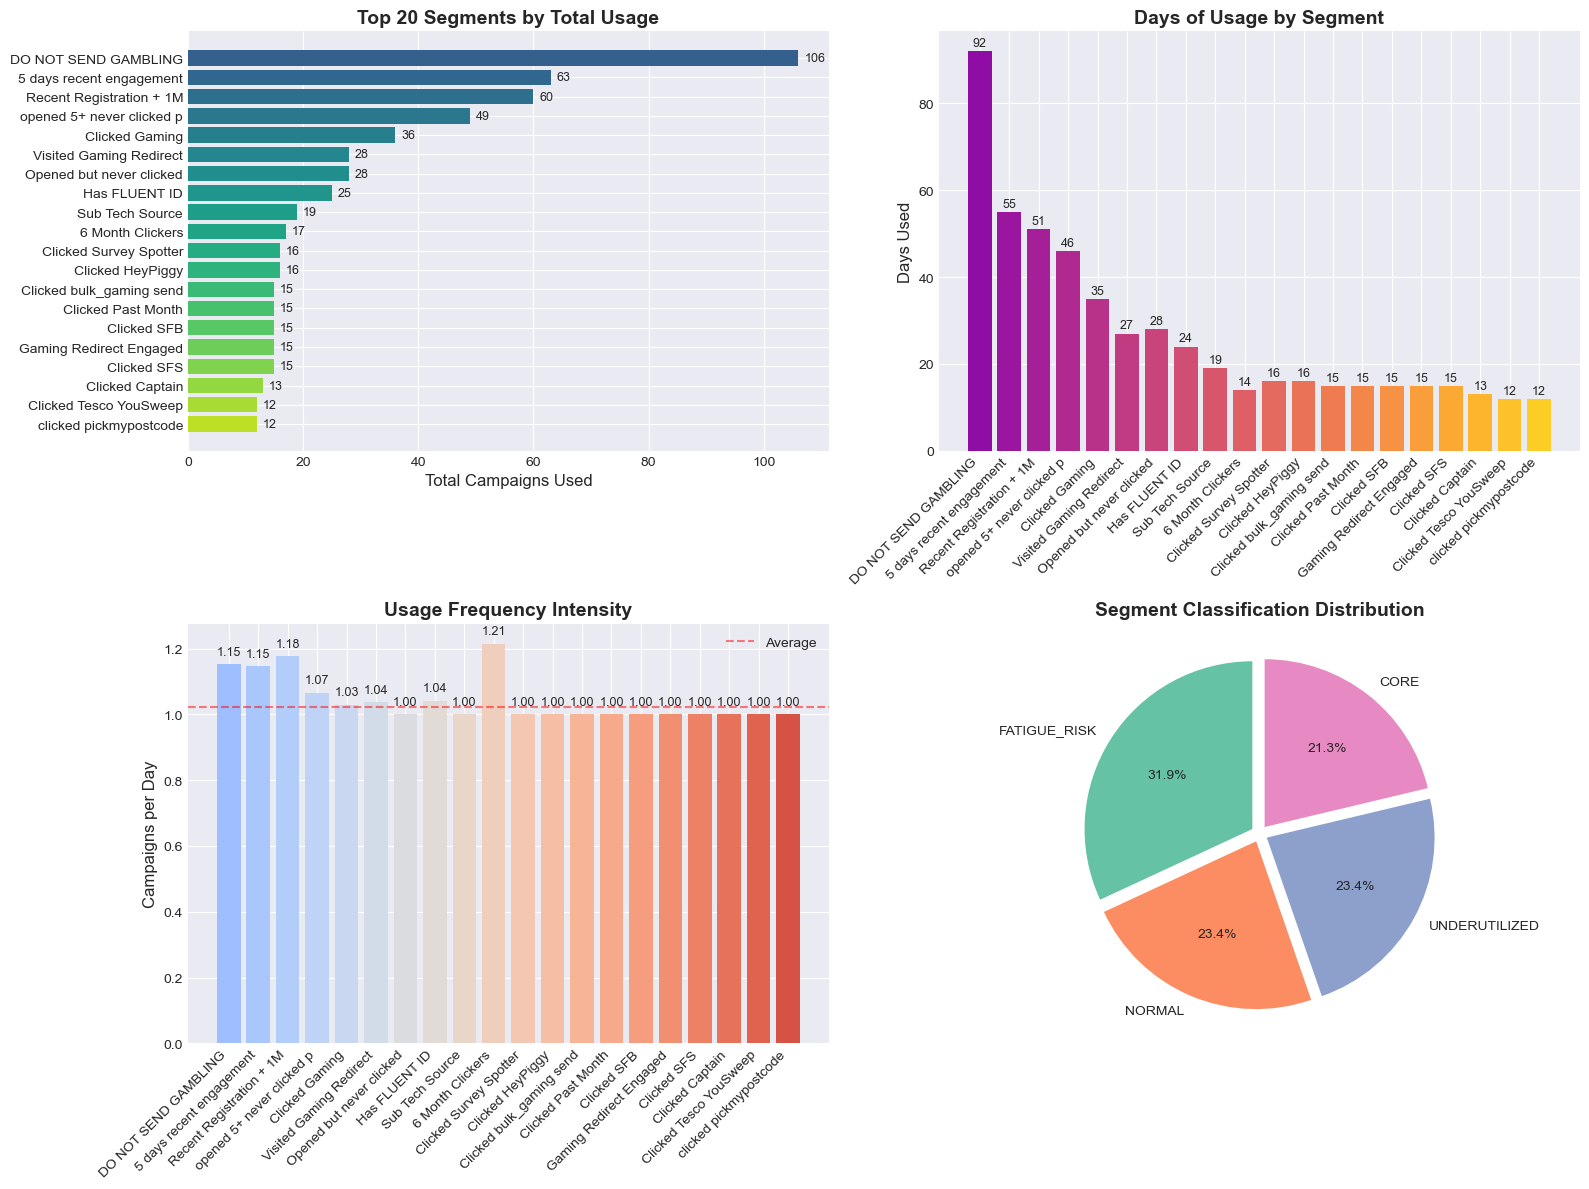

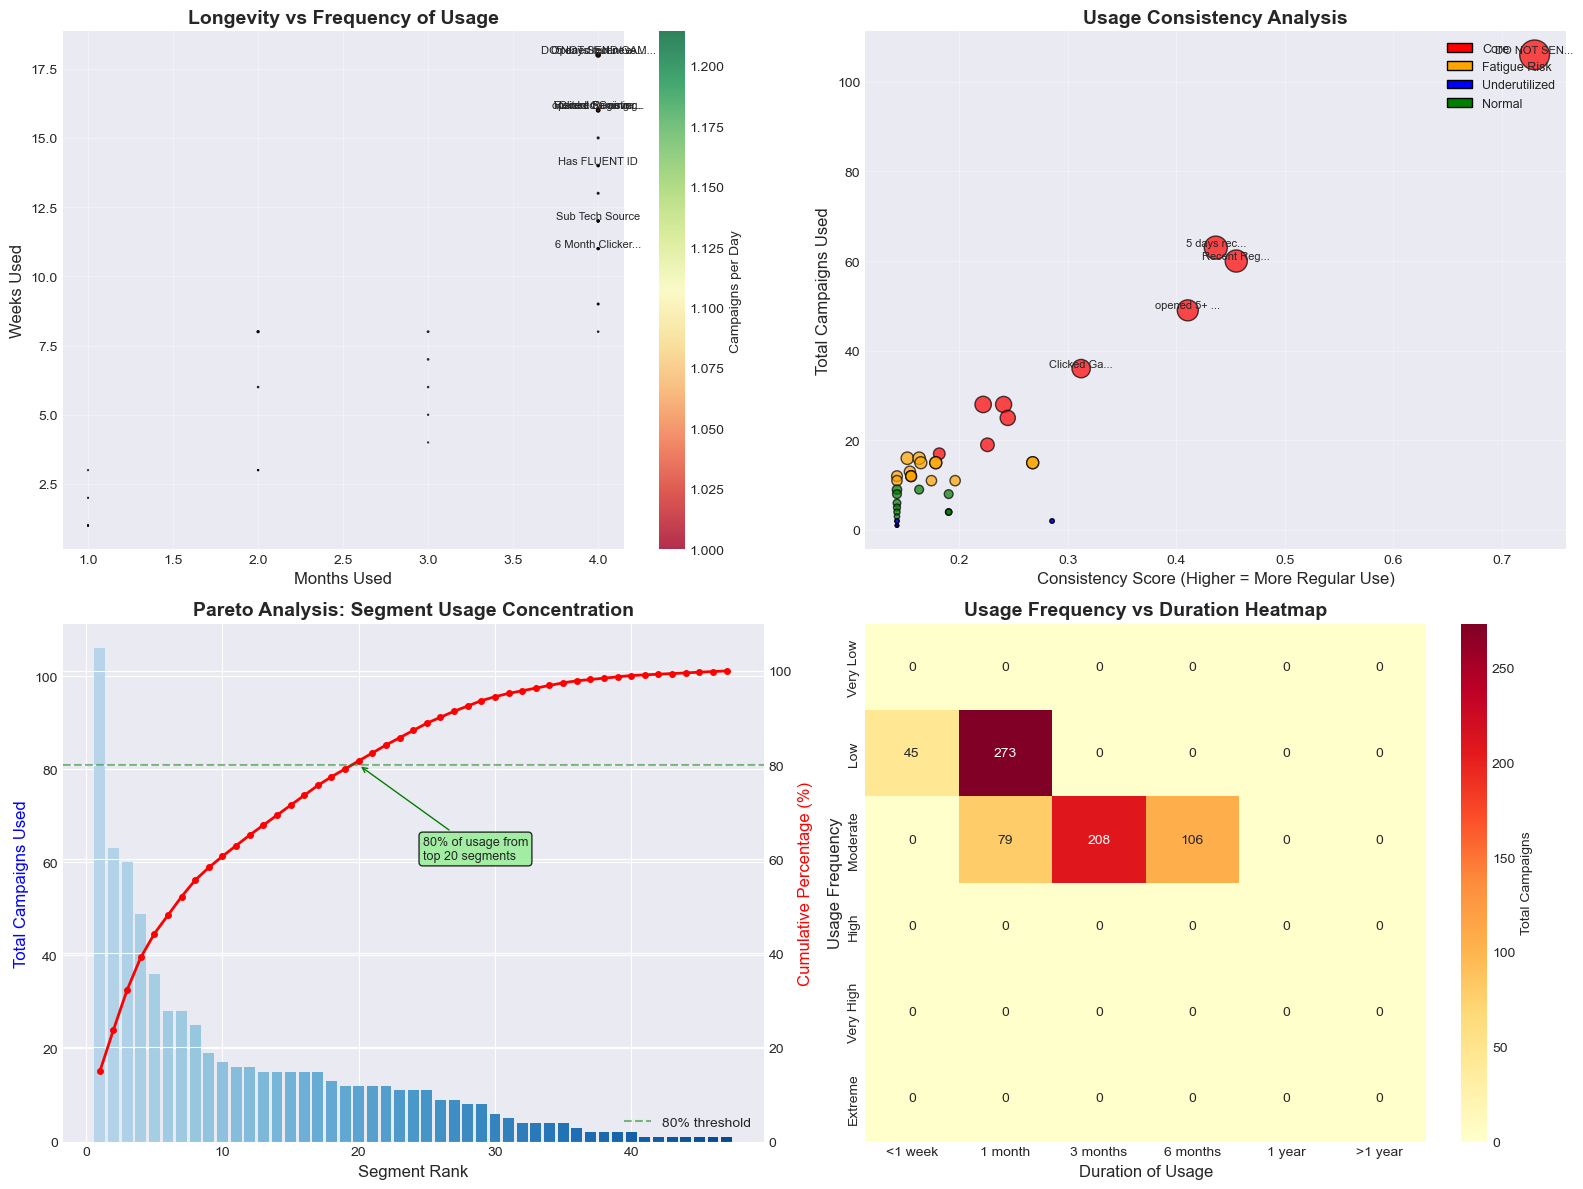

ValueError: Bin edges must be unique: array([1.        , 1.        , 1.        , 1.        , 1.21428571]).
You can drop duplicate edges by setting the 'duplicates' kwarg

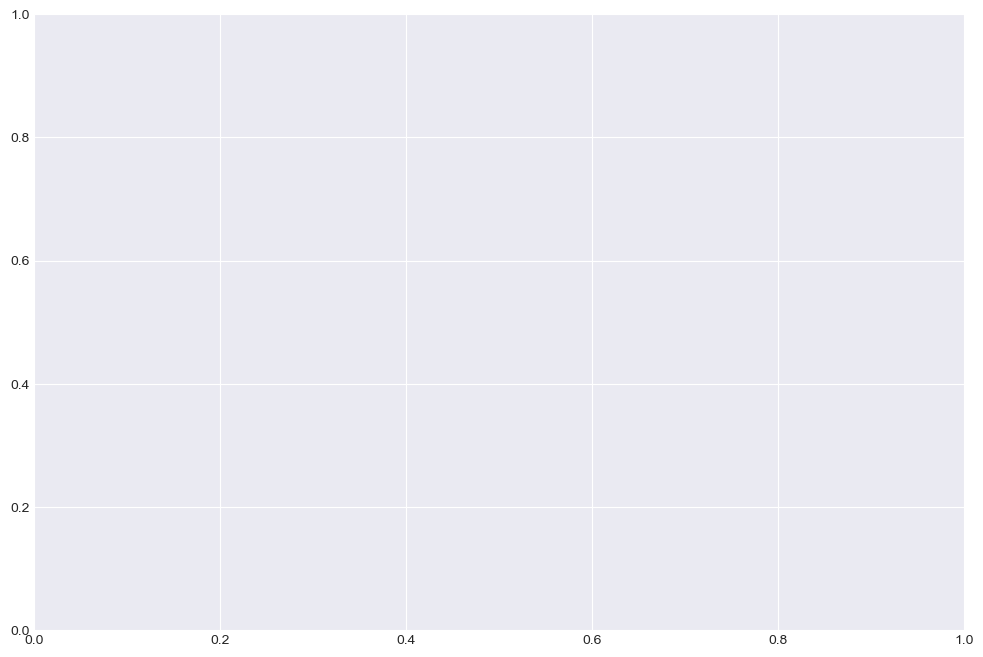

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

def analyze_segment_usage(df):
    """
    Analyzes segment usage patterns, frequency, and identifies core vs underutilized segments.
    
    Parameters:
    df (DataFrame): DataFrame with segment usage data including:
        - segment_id, segment_name
        - total_campaigns_used, days_used, months_used, weeks_used
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['total_campaigns_used', 'days_used', 'months_used', 'weeks_used']
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Calculate additional derived metrics
    df_analysis['campaigns_per_day'] = df_analysis['total_campaigns_used'] / df_analysis['days_used']
    df_analysis['campaigns_per_week'] = df_analysis['total_campaigns_used'] / df_analysis['weeks_used']
    df_analysis['campaigns_per_month'] = df_analysis['total_campaigns_used'] / df_analysis['months_used']
    
    # Calculate usage intensity metrics
    df_analysis['usage_intensity'] = df_analysis['total_campaigns_used'] / df_analysis['days_used']
    df_analysis['consistency_score'] = df_analysis['days_used'] / (df_analysis['weeks_used'] * 7)  # Days used out of possible days
    
    # Calculate segment classification
    # Core segments: Top 20% by total campaigns
    # Fatigue-risk: High intensity + high total campaigns
    # Underutilized: Low total campaigns but have been around
    total_campaigns_median = df_analysis['total_campaigns_used'].median()
    intensity_median = df_analysis['usage_intensity'].median()
    
    def classify_segment(row):
        if row['total_campaigns_used'] >= df_analysis['total_campaigns_used'].quantile(0.8):
            return 'CORE'
        elif row['total_campaigns_used'] >= total_campaigns_median and row['usage_intensity'] >= intensity_median:
            return 'FATIGUE_RISK'
        elif row['total_campaigns_used'] <= df_analysis['total_campaigns_used'].quantile(0.2):
            return 'UNDERUTILIZED'
        else:
            return 'NORMAL'
    
    df_analysis['segment_category'] = df_analysis.apply(classify_segment, axis=1)
    
    # Calculate concentration metrics
    df_analysis['usage_concentration'] = df_analysis['total_campaigns_used'] / df_analysis['total_campaigns_used'].sum()
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Segment Usage Overview (Top 20 segments or all if fewer)
    num_segments = min(20, len(df_analysis))
    df_sorted = df_analysis.sort_values('total_campaigns_used', ascending=False).head(num_segments)
    
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Total Campaigns by Segment
    colors1 = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_sorted)))
    bars1 = ax1.barh(range(len(df_sorted)), df_sorted['total_campaigns_used'], color=colors1)
    ax1.set_yticks(range(len(df_sorted)))
    ax1.set_yticklabels(df_sorted['segment_name'])
    ax1.invert_yaxis()  # Highest at top
    ax1.set_xlabel('Total Campaigns Used', fontsize=12)
    ax1.set_title(f'Top {num_segments} Segments by Total Usage', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars1, df_sorted['total_campaigns_used'])):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{val:.0f}', va='center', fontsize=9)
    
    # Plot 2: Days Used by Segment
    colors2 = plt.cm.plasma(np.linspace(0.3, 0.9, len(df_sorted)))
    bars2 = ax2.bar(range(len(df_sorted)), df_sorted['days_used'], color=colors2)
    ax2.set_xticks(range(len(df_sorted)))
    ax2.set_xticklabels(df_sorted['segment_name'], rotation=45, ha='right')
    ax2.set_ylabel('Days Used', fontsize=12)
    ax2.set_title('Days of Usage by Segment', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, df_sorted['days_used'])):
        ax2.text(i, val + 0.5, f'{val:.0f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Usage Frequency (Campaigns per Day)
    colors3 = plt.cm.coolwarm(np.linspace(0.3, 0.9, len(df_sorted)))
    bars3 = ax3.bar(range(len(df_sorted)), df_sorted['campaigns_per_day'], color=colors3)
    ax3.set_xticks(range(len(df_sorted)))
    ax3.set_xticklabels(df_sorted['segment_name'], rotation=45, ha='right')
    ax3.set_ylabel('Campaigns per Day', fontsize=12)
    ax3.set_title('Usage Frequency Intensity', fontsize=14, fontweight='bold')
    ax3.axhline(y=df_analysis['campaigns_per_day'].mean(), color='red', linestyle='--', alpha=0.5, label='Average')
    ax3.legend()
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars3, df_sorted['campaigns_per_day'])):
        ax3.text(i, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Segment Categories Distribution
    category_counts = df_analysis['segment_category'].value_counts()
    colors4 = plt.cm.Set2(np.arange(len(category_counts)))
    ax4.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
           colors=colors4, startangle=90, explode=[0.05]*len(category_counts))
    ax4.set_title('Segment Classification Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Time-Based Usage Patterns
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 5: Usage Over Time (Months vs Weeks)
    scatter1 = ax5.scatter(df_analysis['months_used'], df_analysis['weeks_used'],
                          s=df_analysis['total_campaigns_used']/10,
                          c=df_analysis['campaigns_per_day'],
                          cmap='RdYlGn', alpha=0.8, edgecolors='black')
    
    # Add segment labels for top 10
    top_10 = df_analysis.nlargest(10, 'total_campaigns_used')
    for i, row in top_10.iterrows():
        ax5.annotate(row['segment_name'][:15] + '...' if len(row['segment_name']) > 15 else row['segment_name'],
                    (row['months_used'], row['weeks_used']),
                    fontsize=8, ha='center', va='bottom')
    
    ax5.set_xlabel('Months Used', fontsize=12)
    ax5.set_ylabel('Weeks Used', fontsize=12)
    ax5.set_title('Longevity vs Frequency of Usage', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    cbar5 = fig2.colorbar(scatter1, ax=ax5)
    cbar5.set_label('Campaigns per Day', fontsize=10)
    
    # Plot 6: Consistency Analysis
    ax6.scatter(df_analysis['consistency_score'], df_analysis['total_campaigns_used'],
               s=df_analysis['days_used']*5,
               c=df_analysis['segment_category'].map({'CORE': 'red', 'FATIGUE_RISK': 'orange', 
                                                     'UNDERUTILIZED': 'blue', 'NORMAL': 'green'}),
               alpha=0.7, edgecolors='black')
    
    # Add labels for outliers
    for i, row in df_analysis[df_analysis['total_campaigns_used'] > df_analysis['total_campaigns_used'].quantile(0.9)].iterrows():
        ax6.annotate(row['segment_name'][:10] + '...',
                    (row['consistency_score'], row['total_campaigns_used']),
                    fontsize=8, ha='center', va='bottom')
    
    ax6.set_xlabel('Consistency Score (Higher = More Regular Use)', fontsize=12)
    ax6.set_ylabel('Total Campaigns Used', fontsize=12)
    ax6.set_title('Usage Consistency Analysis', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # Add category legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', edgecolor='black', label='Core'),
                      Patch(facecolor='orange', edgecolor='black', label='Fatigue Risk'),
                      Patch(facecolor='blue', edgecolor='black', label='Underutilized'),
                      Patch(facecolor='green', edgecolor='black', label='Normal')]
    ax6.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # Plot 7: Usage Concentration (Pareto Analysis)
    df_sorted_pareto = df_analysis.sort_values('total_campaigns_used', ascending=False).reset_index(drop=True)
    df_sorted_pareto['cumulative_percentage'] = df_sorted_pareto['total_campaigns_used'].cumsum() / df_sorted_pareto['total_campaigns_used'].sum() * 100
    df_sorted_pareto['segment_rank'] = df_sorted_pareto.index + 1
    
    ax7.bar(df_sorted_pareto['segment_rank'], df_sorted_pareto['total_campaigns_used'], 
           color=plt.cm.Blues(np.linspace(0.3, 0.9, len(df_sorted_pareto))))
    ax7.set_xlabel('Segment Rank', fontsize=12)
    ax7.set_ylabel('Total Campaigns Used', fontsize=12, color='blue')
    ax7.set_title('Pareto Analysis: Segment Usage Concentration', fontsize=14, fontweight='bold')
    
    # Add cumulative percentage line
    ax7_twin = ax7.twinx()
    ax7_twin.plot(df_sorted_pareto['segment_rank'], df_sorted_pareto['cumulative_percentage'], 
                 color='red', marker='o', linewidth=2, markersize=4)
    ax7_twin.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='red')
    ax7_twin.set_ylim(0, 110)
    ax7_twin.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    ax7_twin.legend(loc='lower right')
    
    # Add 80/20 line annotation
    eighty_percent_idx = (df_sorted_pareto['cumulative_percentage'] >= 80).idxmax()
    if not pd.isna(eighty_percent_idx):
        eighty_percent_rank = df_sorted_pareto.loc[eighty_percent_idx, 'segment_rank']
        ax7_twin.annotate(f'80% of usage from\ntop {eighty_percent_rank} segments',
                         xy=(eighty_percent_rank, 80),
                         xytext=(eighty_percent_rank + len(df_sorted_pareto)*0.1, 60),
                         arrowprops=dict(arrowstyle='->', color='green'),
                         fontsize=9,
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))
    
    # Plot 8: Frequency Distribution Heatmap
    if len(df_analysis) > 5:
        # Create frequency buckets
        df_analysis['frequency_bucket'] = pd.cut(df_analysis['campaigns_per_day'],
                                                bins=[0, 0.5, 1, 2, 5, 10, 100],
                                                labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme'])
        
        # Create duration buckets
        df_analysis['duration_bucket'] = pd.cut(df_analysis['days_used'],
                                               bins=[0, 7, 30, 90, 180, 365, 1000],
                                               labels=['<1 week', '1 month', '3 months', '6 months', '1 year', '>1 year'])
        
        # Create cross-tabulation
        freq_heatmap = pd.crosstab(df_analysis['frequency_bucket'], 
                                  df_analysis['duration_bucket'], 
                                  values=df_analysis['total_campaigns_used'], 
                                  aggfunc='sum')
        
        if not freq_heatmap.empty:
            sns.heatmap(freq_heatmap, annot=True, fmt='.0f', cmap='YlOrRd', 
                       cbar_kws={'label': 'Total Campaigns'}, ax=ax8)
            ax8.set_title('Usage Frequency vs Duration Heatmap', fontsize=14, fontweight='bold')
            ax8.set_xlabel('Duration of Usage', fontsize=12)
            ax8.set_ylabel('Usage Frequency', fontsize=12)
        else:
            ax8.text(0.5, 0.5, 'Insufficient data for heatmap', 
                    ha='center', va='center', fontsize=12, transform=ax8.transAxes)
            ax8.set_title('Frequency vs Duration Analysis', fontsize=14, fontweight='bold')
    else:
        ax8.text(0.5, 0.5, 'Need more segments for heatmap analysis', 
                ha='center', va='center', fontsize=12, transform=ax8.transAxes)
        ax8.set_title('Frequency vs Duration Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Segment Performance Matrix
    if len(df_analysis) > 3:
        fig3, ax9 = plt.subplots(figsize=(12, 8))
        
        # Create a 2x2 matrix based on usage and frequency
        df_analysis['usage_quartile'] = pd.qcut(df_analysis['total_campaigns_used'], 
                                               q=4, labels=['Very Low', 'Low', 'High', 'Very High'])
        df_analysis['frequency_quartile'] = pd.qcut(df_analysis['campaigns_per_day'], 
                                                   q=4, labels=['Very Low', 'Low', 'High', 'Very High'])
        
        # Create matrix
        segment_matrix = pd.crosstab(df_analysis['usage_quartile'], 
                                    df_analysis['frequency_quartile'], 
                                    values=df_analysis['segment_name'], 
                                    aggfunc='count')
        
        # Create annotated heatmap
        im = ax9.imshow(segment_matrix.values, cmap='RdYlGn', aspect='auto')
        ax9.set_title('Segment Usage vs Frequency Matrix', fontsize=16, fontweight='bold')
        ax9.set_xlabel('Usage Frequency Quartile', fontsize=12)
        ax9.set_ylabel('Total Usage Quartile', fontsize=12)
        
        # Set ticks
        ax9.set_xticks(np.arange(len(segment_matrix.columns)))
        ax9.set_yticks(np.arange(len(segment_matrix.index)))
        ax9.set_xticklabels(segment_matrix.columns)
        ax9.set_yticklabels(segment_matrix.index)
        
        # Add text annotations
        for i in range(len(segment_matrix.index)):
            for j in range(len(segment_matrix.columns)):
                count = segment_matrix.iloc[i, j]
                if not pd.isna(count):
                    text_color = 'white' if segment_matrix.iloc[i, j] > segment_matrix.values.mean() else 'black'
                    ax9.text(j, i, f'{int(count)} segments', 
                            ha="center", va="center", color=text_color, fontsize=10, fontweight='bold')
        
        # Add quadrant labels
        ax9.text(0.5, 0.5, 'UNDERUTILIZED\n(Low Use, Low Frequency)', 
                ha='center', va='center', transform=ax9.transAxes,
                fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))
        
        ax9.text(0.5, 3.5, 'HIGH POTENTIAL\n(High Use, Low Frequency)', 
                ha='center', va='center', transform=ax9.transAxes,
                fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))
        
        ax9.text(3.5, 0.5, 'FREQUENT LOW IMPACT\n(Low Use, High Frequency)', 
                ha='center', va='center', transform=ax9.transAxes,
                fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
        
        ax9.text(3.5, 3.5, 'CORE SEGMENTS\n(High Use, High Frequency)', 
                ha='center', va='center', transform=ax9.transAxes,
                fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.7))
        
        # Add colorbar
        cbar = fig3.colorbar(im, ax=ax9)
        cbar.set_label('Number of Segments', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("SEGMENT USAGE & FREQUENCY ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_segments = len(df_analysis)
    total_campaigns = df_analysis['total_campaigns_used'].sum()
    avg_campaigns_per_segment = df_analysis['total_campaigns_used'].mean()
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Total Campaigns Across All Segments: {total_campaigns:,}")
    print(f"   • Average Campaigns per Segment: {avg_campaigns_per_segment:.1f}")
    print(f"   • Average Days Used per Segment: {df_analysis['days_used'].mean():.1f}")
    print(f"   • Average Months Active: {df_analysis['months_used'].mean():.1f}")
    
    # Core Segments Analysis
    print(f"\n🏆 CORE SEGMENTS (Top 20% by Usage):")
    core_segments = df_analysis[df_analysis['segment_category'] == 'CORE']
    if len(core_segments) > 0:
        core_usage_percentage = (core_segments['total_campaigns_used'].sum() / total_campaigns) * 100
        print(f"   • {len(core_segments)} core segments identified")
        print(f"   • Core segments account for {core_usage_percentage:.1f}% of total usage")
        
        print(f"   • Top Core Segments:")
        top_core = core_segments.nlargest(3, 'total_campaigns_used')
        for i, (_, segment) in enumerate(top_core.iterrows(), 1):
            print(f"     {i}. {segment['segment_name']} - {segment['total_campaigns_used']:,} campaigns "
                  f"({segment['days_used']} days)")
    else:
        print(f"   • No segments identified as core (increase threshold if needed)")
    
    # Fatigue-Risk Segments
    print(f"\n⚠️ FATIGUE-RISK SEGMENTS:")
    fatigue_segments = df_analysis[df_analysis['segment_category'] == 'FATIGUE_RISK']
    if len(fatigue_segments) > 0:
        print(f"   • {len(fatigue_segments)} fatigue-risk segments identified")
        print(f"   • These segments show high intensity usage that could lead to audience fatigue")
        
        print(f"   • Highest Risk Segments:")
        top_fatigue = fatigue_segments.nlargest(3, 'campaigns_per_day')
        for i, (_, segment) in enumerate(top_fatigue.iterrows(), 1):
            intensity = segment['campaigns_per_day']
            days_used = segment['days_used']
            print(f"     {i}. {segment['segment_name']} - {intensity:.2f} campaigns/day "
                  f"(used {days_used} days)")
    else:
        print(f"   • No fatigue-risk segments identified")
    
    # Underutilized Segments
    print(f"\n📉 UNDERUTILIZED SEGMENTS:")
    underutilized_segments = df_analysis[df_analysis['segment_category'] == 'UNDERUTILIZED']
    if len(underutilized_segments) > 0:
        print(f"   • {len(underutilized_segments)} underutilized segments identified")
        print(f"   • These segments have low usage but may represent untapped opportunities")
        
        # Find segments that have been around but rarely used
        long_but_unused = underutilized_segments[underutilized_segments['days_used'] > 30]
        if len(long_but_unused) > 0:
            print(f"   • Segments with long history but low usage:")
            for i, (_, segment) in enumerate(long_but_unused.nlargest(3, 'days_used').iterrows(), 1):
                usage_rate = segment['total_campaigns_used'] / segment['days_used']
                print(f"     {i}. {segment['segment_name']} - Only {segment['total_campaigns_used']} campaigns "
                      f"in {segment['days_used']} days ({usage_rate:.2f}/day)")
    else:
        print(f"   • No underutilized segments identified")
    
    # Usage Patterns Analysis
    print(f"\n📈 USAGE PATTERN ANALYSIS:")
    
    # Calculate concentration metrics
    top_5_percent = int(len(df_analysis) * 0.05) or 1
    top_5_segments = df_analysis.nlargest(top_5_percent, 'total_campaigns_used')
    top_5_usage = top_5_segments['total_campaigns_used'].sum() / total_campaigns * 100
    
    print(f"   • Top {top_5_percent} segments account for {top_5_usage:.1f}% of all usage")
    
    # Calculate usage skew
    gini_coefficient = 0.5 * np.sum(np.abs(np.array(df_analysis['total_campaigns_used']) - 
                                           np.array(df_analysis['total_campaigns_used'].mean()))) / \
                       (len(df_analysis) * df_analysis['total_campaigns_used'].mean())
    
    if gini_coefficient > 0.6:
        print(f"   • High concentration: Usage heavily skewed toward few segments (Gini: {gini_coefficient:.3f})")
    elif gini_coefficient > 0.4:
        print(f"   • Moderate concentration: Balanced usage distribution (Gini: {gini_coefficient:.3f})")
    else:
        print(f"   • Low concentration: Usage evenly distributed (Gini: {gini_coefficient:.3f})")
    
    # Frequency Analysis
    print(f"\n🔄 FREQUENCY ANALYSIS:")
    
    avg_campaigns_per_day = df_analysis['campaigns_per_day'].mean()
    print(f"   • Average campaigns per day per segment: {avg_campaigns_per_day:.3f}")
    
    high_frequency_segments = df_analysis[df_analysis['campaigns_per_day'] > 1.5]
    if len(high_frequency_segments) > 0:
        print(f"   • {len(high_frequency_segments)} segments used more than 1.5 times/day")
    
    low_frequency_segments = df_analysis[df_analysis['campaigns_per_day'] < 0.1]
    if len(low_frequency_segments) > 0:
        print(f"   • {len(low_frequency_segments)} segments used less than 0.1 times/day")
    
    # Consistency Analysis
    print(f"\n🎯 CONSISTENCY ANALYSIS:")
    
    consistent_segments = df_analysis[df_analysis['consistency_score'] > 0.7]
    sporadic_segments = df_analysis[df_analysis['consistency_score'] < 0.3]
    
    if len(consistent_segments) > 0:
        print(f"   • {len(consistent_segments)} segments show consistent, regular usage")
    
    if len(sporadic_segments) > 0:
        print(f"   • {len(sporadic_segments)} segments show sporadic, irregular usage")
        print(f"   • These may indicate reactive or opportunistic usage patterns")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Recommendations based on segment categories
    if len(core_segments) > 0:
        if len(core_segments) < 5:
            # Very concentrated usage
            recommendations.append(
                "• High concentration risk: Consider diversifying usage beyond top segments "
                "to reduce dependency"
            )
        else:
            recommendations.append(
                "• Core segments performing well - maintain quality and monitor for fatigue"
            )
    
    if len(fatigue_segments) > 0:
        recommendations.append(
            "• Implement rotation strategy for fatigue-risk segments "
            "to prevent audience burnout"
        )
        
        for _, segment in fatigue_segments.nlargest(2, 'campaigns_per_day').iterrows():
            recommendations.append(
                f"• Review frequency for {segment['segment_name']}: "
                f"Currently used {segment['campaigns_per_day']:.2f} times/day"
            )
    
    if len(underutilized_segments) > 0:
        # Find segments with potential (high days_used but low campaigns)
        high_potential = underutilized_segments[underutilized_segments['days_used'] > 60]
        if len(high_potential) > 0:
            recommendations.append(
                f"• {len(high_potential)} underutilized segments have been available for >60 days "
                f"- review for strategic opportunities"
            )
        
        # Suggest testing
        test_candidates = underutilized_segments.nlargest(3, 'days_used')
        if len(test_candidates) > 0:
            recommendations.append(
                "• Consider A/B testing with underutilized segments to identify hidden value"
            )
    
    # Usage pattern recommendations
    if len(sporadic_segments) > len(consistent_segments) * 2:
        recommendations.append(
            "• High proportion of sporadic usage suggests reactive strategy - "
            "develop more systematic segment utilization plan"
        )
    
    # Concentration recommendations
    if top_5_usage > 70:
        recommendations.append(
            "• Extreme usage concentration (>70% in top segments) - "
            "explore expanding segment portfolio to reduce risk"
        )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Segment usage appears balanced and strategic - continue current approach")
        print("• Focus on incremental optimization through A/B testing")
    
    # Priority Actions
    print(f"\n🎯 PRIORITY ACTIONS:")
    
    # Identify top 3 priority actions
    priority_actions = []
    
    if len(fatigue_segments) > 0:
        worst_fatigue = fatigue_segments.nlargest(1, 'campaigns_per_day')
        if len(worst_fatigue) > 0:
            segment = worst_fatigue.iloc[0]
            priority_actions.append(
                f"  1. Address fatigue risk for '{segment['segment_name']}' "
                f"(current: {segment['campaigns_per_day']:.2f} campaigns/day)"
            )
    
    if len(underutilized_segments) > 3:
        priority_actions.append(
            f"  2. Review {len(underutilized_segments)} underutilized segments "
            f"for optimization opportunities"
        )
    
    if top_5_usage > 60:
        priority_actions.append(
            f"  3. Diversify segment usage (top 5 segments: {top_5_usage:.1f}% of total usage)"
        )
    
    if not priority_actions:
        if len(core_segments) > 0:
            priority_actions.append(
                f"  1. Monitor {len(core_segments)} core segments for performance maintenance"
            )
        priority_actions.append(
            f"  2. Continue current segment strategy with regular review"
        )
    
    for action in priority_actions[:3]:
        print(action)
    
    # Summary Insights
    print(f"\n💡 KEY INSIGHTS:")
    
    # Usage concentration insight
    if top_5_usage > 50:
        print(f"   • High dependency: Small number of segments drive majority of usage")
    else:
        print(f"   • Balanced portfolio: Usage well-distributed across segments")
    
    # Frequency pattern insight
    if avg_campaigns_per_day > 1:
        print(f"   • High frequency: Segments used multiple times per day on average")
    elif avg_campaigns_per_day < 0.5:
        print(f"   • Conservative frequency: Segments used less than daily on average")
    
    # Category distribution insight
    category_dist = df_analysis['segment_category'].value_counts()
    if 'CORE' in category_dist and category_dist['CORE'] > len(df_analysis) * 0.3:
        print(f"   • Strong foundation: Many segments established as core performers")
    
    print("\n" + "="*80)
    
    return df_analysis

# Usage example:
result_df = analyze_segment_usage(df)

# -- Daily usage of each segment

In [5]:
SQL_NAME = "2_/2_2"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head()

segment_id              segment_name sending_date  campaigns_that_day  \
0          94      DO NOT SEND GAMBLING   2025-12-31                   1   
1          97  Recent Registration + 1M   2025-12-31                   1   
2         103  Clicked bulk_gaming send   2025-12-31                   1   
3         169   Gaming Redirect Engaged   2025-12-31                   1   
4         171   Visited Gaming Redirect   2025-12-31                   1   

  clients_that_day  
0   Jupiter Gaming  
1           XL Win  
2   Jupiter Gaming  
3   Jupiter Gaming  
4   Jupiter Gaming

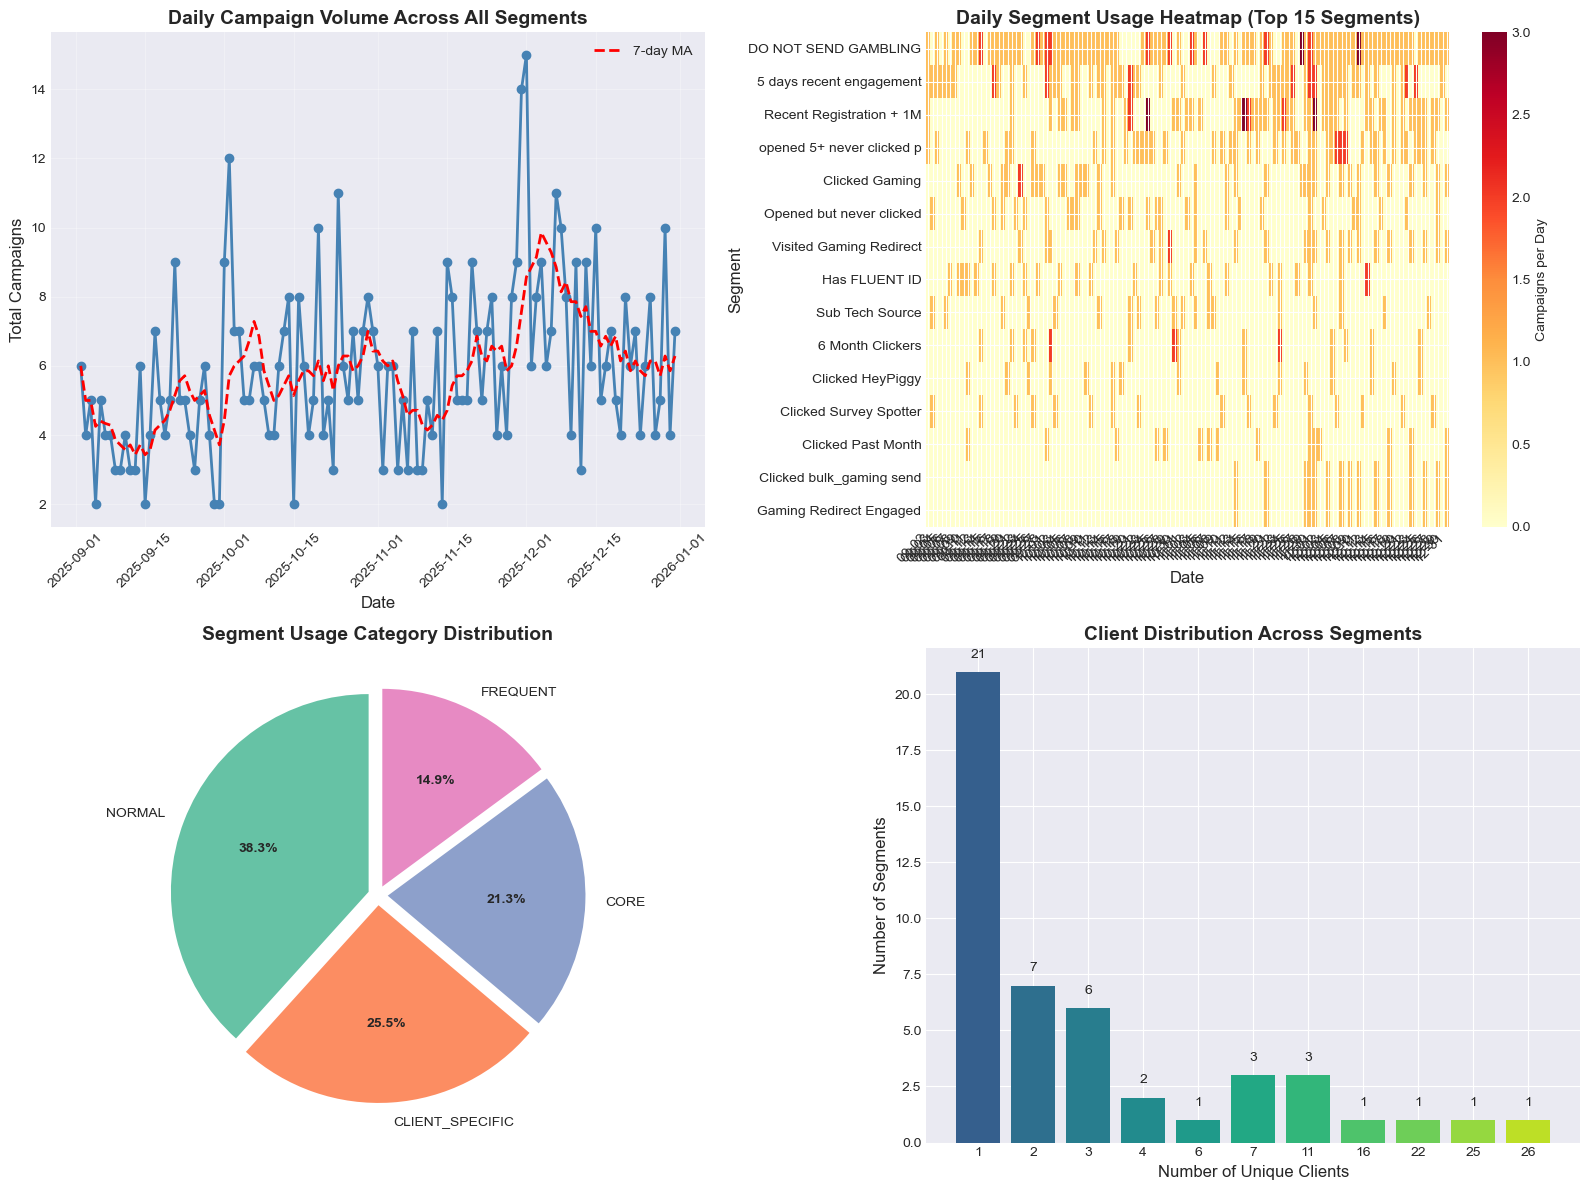

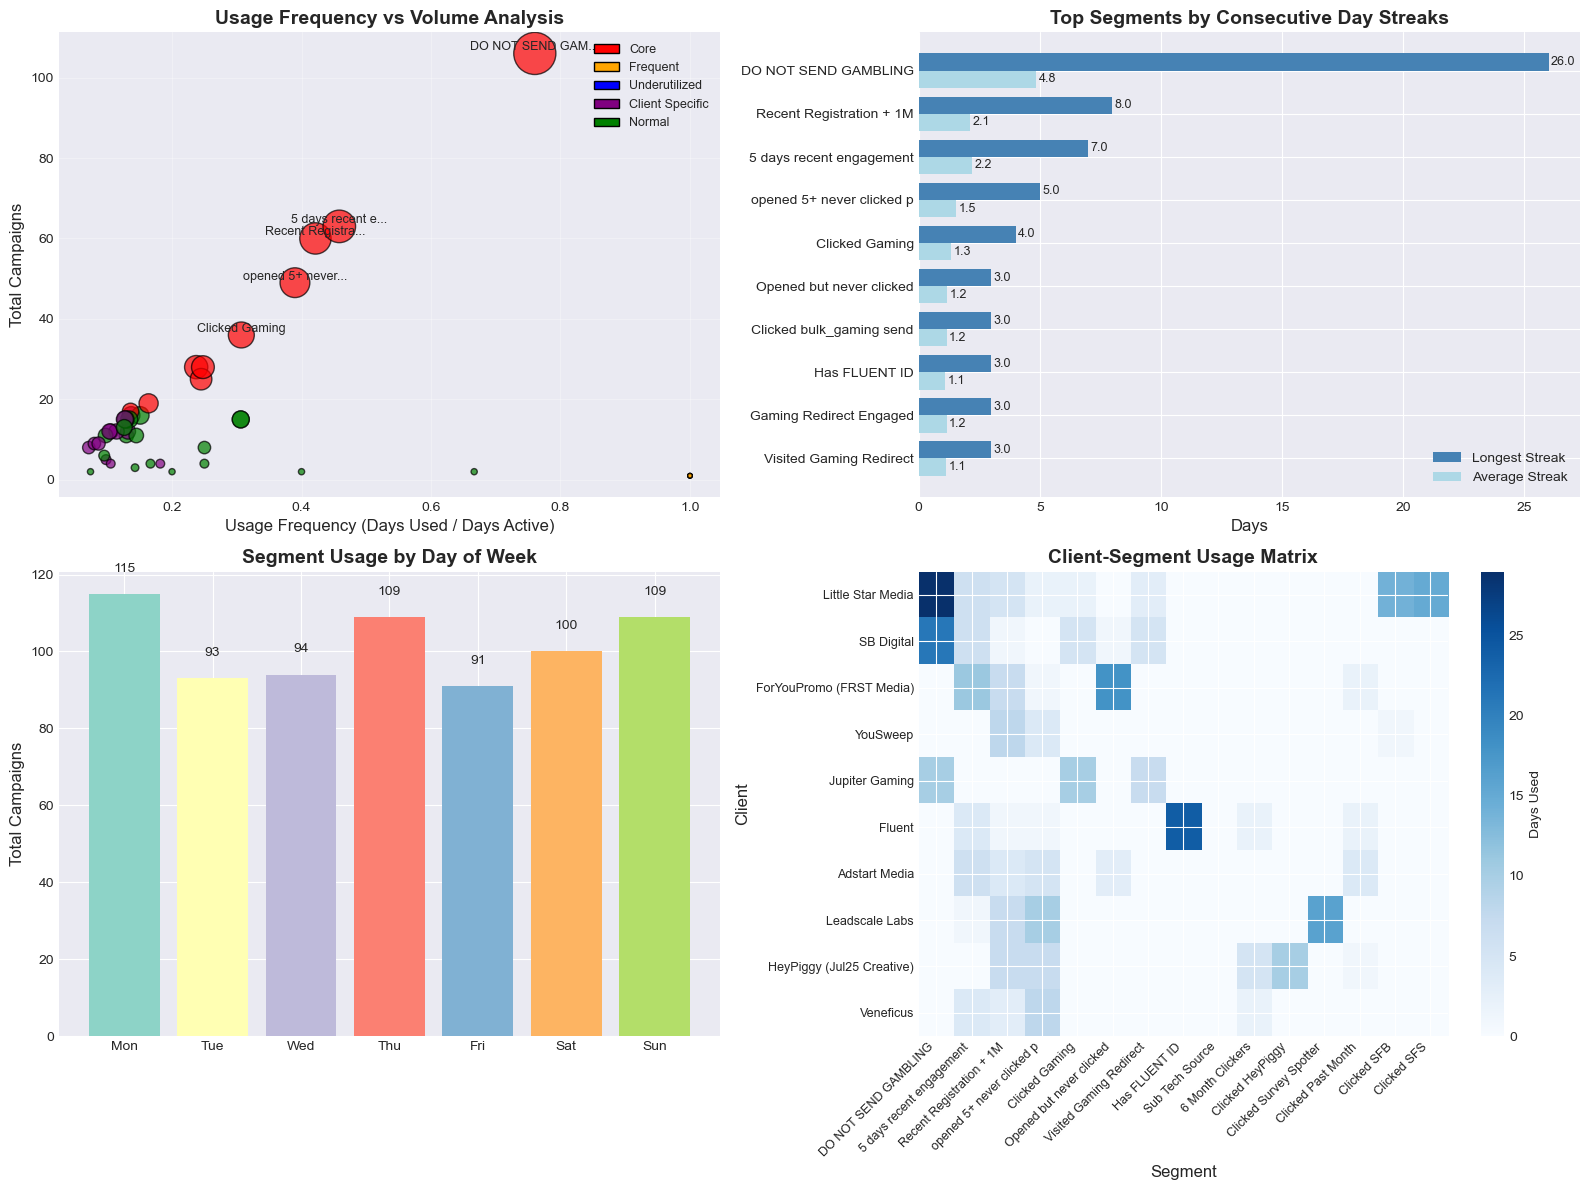

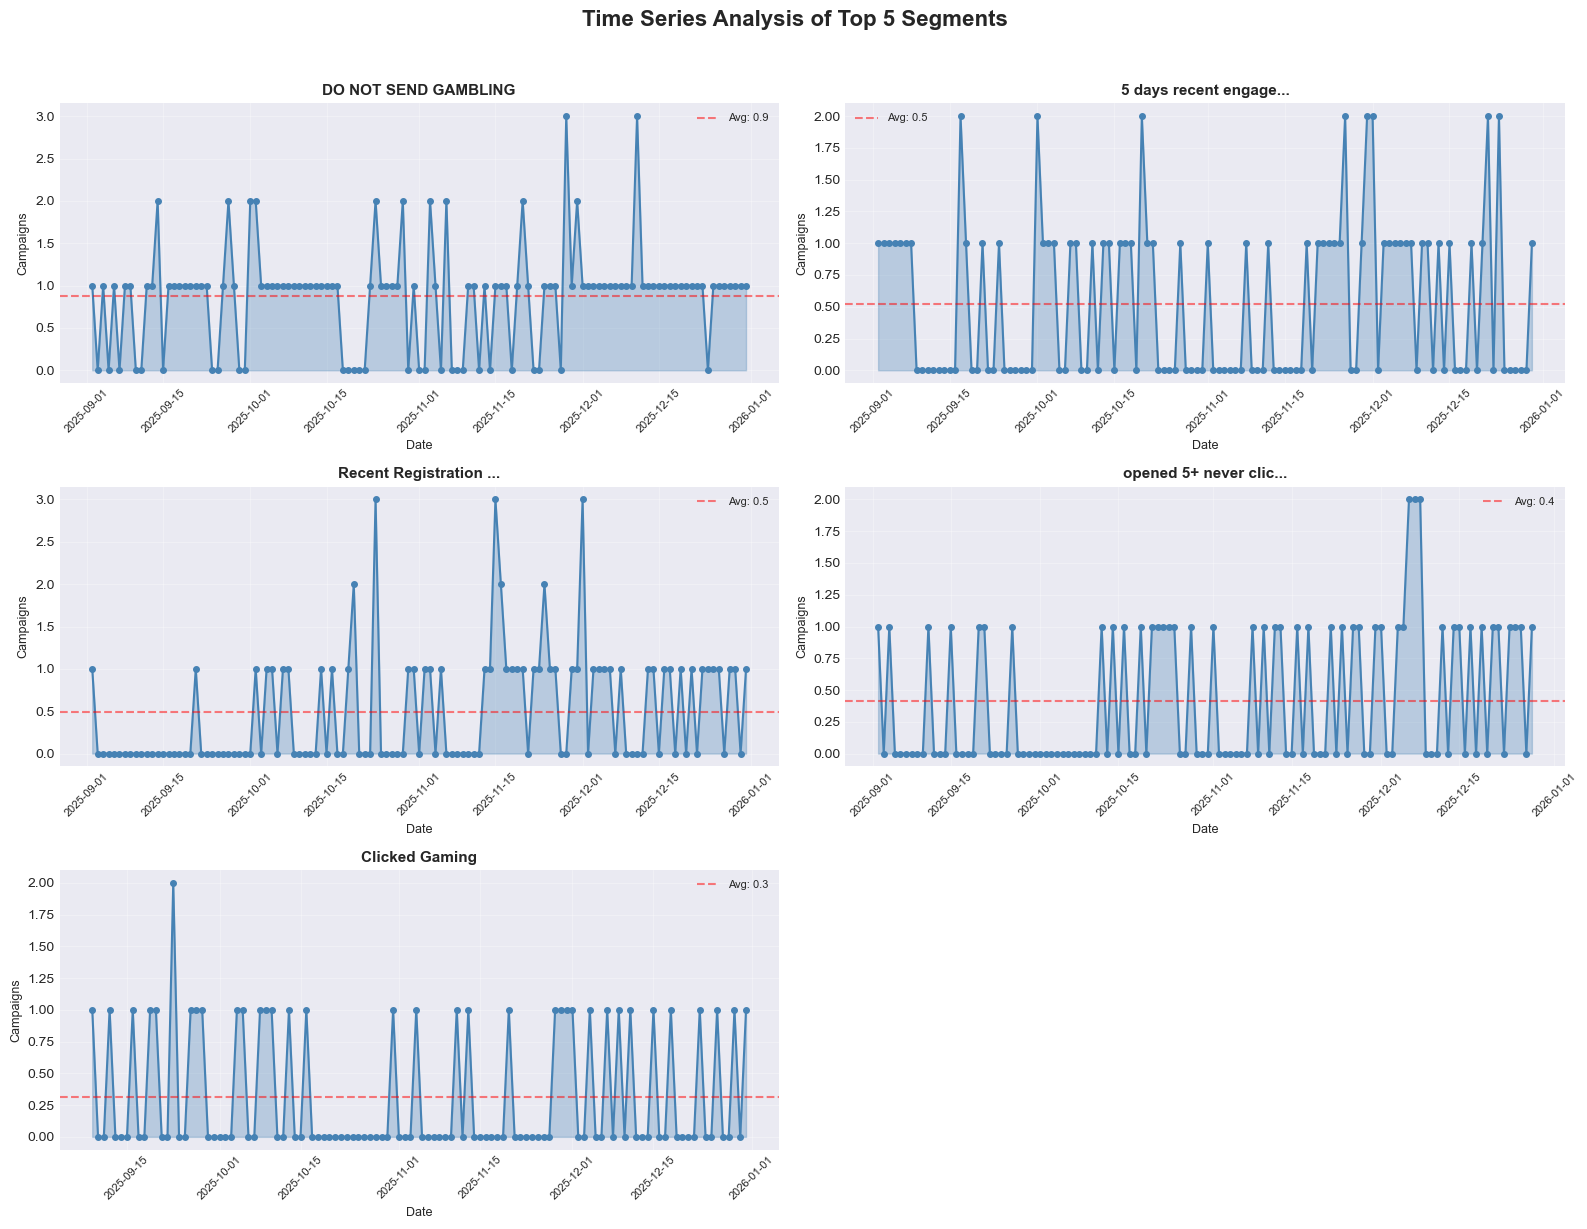

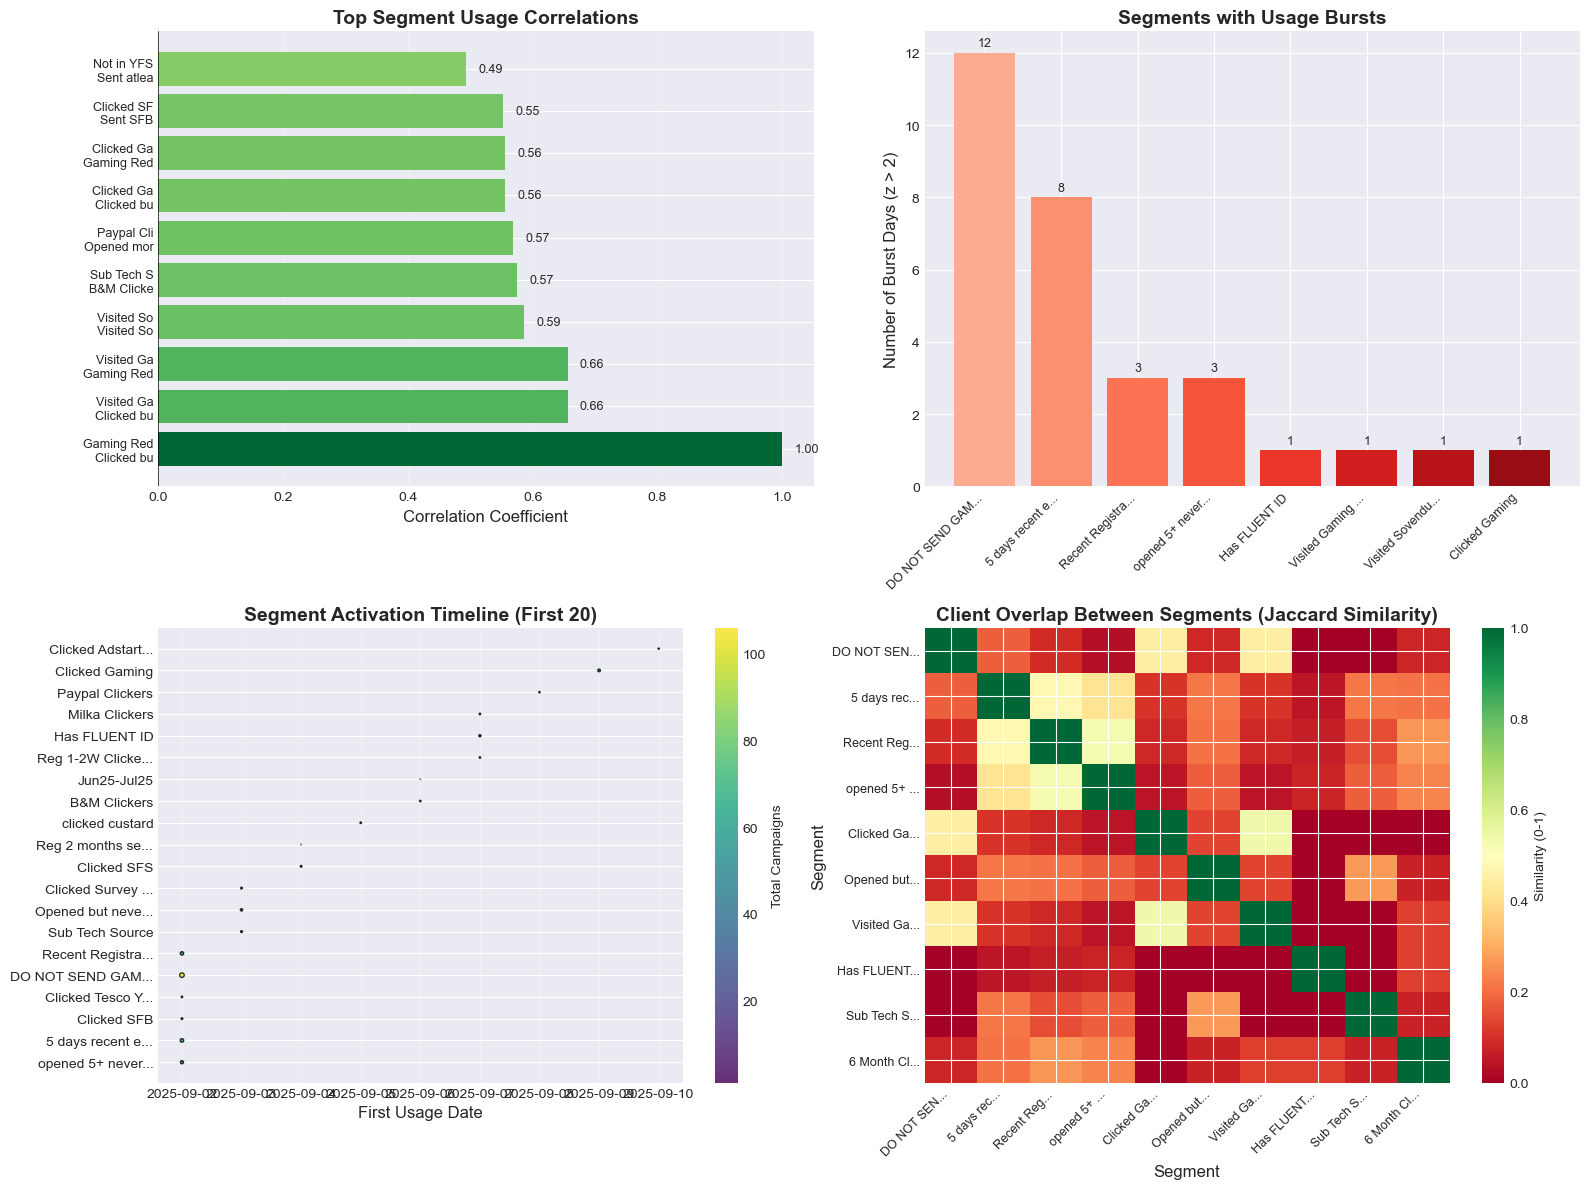

DAILY SEGMENT USAGE ANALYSIS

📊 OVERVIEW METRICS:
   • Total Segments: 47
   • Date Range: 2025-09-02 to 2025-12-31 (121 days)
   • Total Campaign-Segment Days: 670
   • Average Campaigns per Day: 5.9

🏷️ SEGMENT CATEGORIES:
   • NORMAL: 18 segments (38.3%)
   • CLIENT_SPECIFIC: 12 segments (25.5%)
   • CORE: 10 segments (21.3%)
   • FREQUENT: 7 segments (14.9%)

🏆 CORE SEGMENTS (Top by Usage):
   • 10 core segments identified
   • Core segments account for 60.6% of total usage
   • Top Core Segments:
     1. DO NOT SEND GAMBLING
        - 106 total campaigns
        - 92 days used (1.2 campaigns/day)
        - Used by 25 client(s)
     2. 5 days recent engagement
        - 63 total campaigns
        - 55 days used (1.1 campaigns/day)
        - Used by 26 client(s)
     3. Recent Registration + 1M
        - 60 total campaigns
        - 51 days used (1.2 campaigns/day)
        - Used by 22 client(s)

🔄 FREQUENT USAGE PATTERNS:
   • 7 segments show frequent, regular usage
   • Average us

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from collections import Counter
warnings.filterwarnings('ignore')

def analyze_daily_segment_usage(df):
    """
    Analyzes daily segment usage patterns including frequency, client usage, and patterns.
    
    Parameters:
    df (DataFrame): DataFrame with daily segment usage data including:
        - segment_id, segment_name, sending_date, campaigns_that_day, clients_that_day
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Convert date to datetime
    df_analysis['sending_date'] = pd.to_datetime(df_analysis['sending_date'])
    
    # Extract time components
    df_analysis['year'] = df_analysis['sending_date'].dt.year
    df_analysis['month'] = df_analysis['sending_date'].dt.month
    df_analysis['month_name'] = df_analysis['sending_date'].dt.strftime('%b')
    df_analysis['week'] = df_analysis['sending_date'].dt.isocalendar().week
    df_analysis['day_of_week'] = df_analysis['sending_date'].dt.day_name()
    df_analysis['day_of_month'] = df_analysis['sending_date'].dt.day
    
    # Convert campaigns_that_day to numeric
    df_analysis['campaigns_that_day'] = pd.to_numeric(df_analysis['campaigns_that_day'], errors='coerce')
    
    # Create a unique identifier for segment-date combination
    df_analysis['segment_date_key'] = df_analysis['segment_id'].astype(str) + '_' + df_analysis['sending_date'].astype(str)
    
    # Calculate segment-level statistics
    segment_stats = df_analysis.groupby(['segment_id', 'segment_name']).agg({
        'sending_date': ['min', 'max', 'nunique'],
        'campaigns_that_day': ['sum', 'mean', 'max', 'std'],
        'clients_that_day': lambda x: ','.join(set(','.join(x.dropna()).split(',')))
    }).reset_index()
    
    # Flatten column names
    segment_stats.columns = ['segment_id', 'segment_name', 'first_used', 'last_used', 
                           'days_used', 'total_campaigns', 'avg_campaigns_per_day',
                           'max_campaigns_day', 'std_campaigns', 'all_clients']
    
    # Calculate additional metrics
    segment_stats['days_active'] = (segment_stats['last_used'] - segment_stats['first_used']).dt.days + 1
    segment_stats['usage_frequency'] = segment_stats['days_used'] / segment_stats['days_active']
    segment_stats['unique_clients'] = segment_stats['all_clients'].apply(lambda x: len(set(x.split(','))) if x else 0)
    
    # Calculate client concentration
    segment_stats['client_concentration'] = segment_stats['all_clients'].apply(
        lambda x: len(set(x.split(','))) / len(x.split(',')) if x else 0
    )
    
    # Create segment categorization
    def categorize_segment(row):
        if row['total_campaigns'] >= segment_stats['total_campaigns'].quantile(0.8):
            return 'CORE'
        elif row['usage_frequency'] >= 0.7 and row['avg_campaigns_per_day'] >= segment_stats['avg_campaigns_per_day'].median():
            return 'FREQUENT'
        elif row['days_used'] >= 7 and row['total_campaigns'] <= segment_stats['total_campaigns'].quantile(0.2):
            return 'UNDERUTILIZED'
        elif row['unique_clients'] == 1 and row['days_used'] > 3:
            return 'CLIENT_SPECIFIC'
        else:
            return 'NORMAL'
    
    segment_stats['segment_category'] = segment_stats.apply(categorize_segment, axis=1)
    
    # Calculate consecutive day streaks for each segment
    df_sorted = df_analysis.sort_values(['segment_id', 'sending_date'])
    df_sorted['date_diff'] = df_sorted.groupby('segment_id')['sending_date'].diff().dt.days
    
    # Identify streak starts (where date_diff != 1)
    df_sorted['streak_start'] = (df_sorted['date_diff'] != 1) | df_sorted['date_diff'].isna()
    df_sorted['streak_id'] = df_sorted.groupby('segment_id')['streak_start'].cumsum()
    
    # Calculate streak lengths
    streak_lengths = df_sorted.groupby(['segment_id', 'streak_id']).size().reset_index(name='streak_length')
    segment_streaks = streak_lengths.groupby('segment_id').agg({
        'streak_length': ['max', 'mean', 'count']
    }).reset_index()
    segment_streaks.columns = ['segment_id', 'longest_streak', 'avg_streak_length', 'num_streaks']
    
    # Merge streak data with segment stats
    segment_stats = segment_stats.merge(segment_streaks, on='segment_id', how='left')
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Daily Usage Patterns Over Time
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Daily Campaign Volume Over Time (Top 10 segments)
    daily_totals = df_analysis.groupby('sending_date')['campaigns_that_day'].sum()
    ax1.plot(daily_totals.index, daily_totals.values, marker='o', linewidth=2, color='steelblue')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Total Campaigns', fontsize=12)
    ax1.set_title('Daily Campaign Volume Across All Segments', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add moving average
    if len(daily_totals) > 7:
        moving_avg = daily_totals.rolling(window=7, min_periods=1).mean()
        ax1.plot(moving_avg.index, moving_avg.values, 'r--', linewidth=2, label='7-day MA')
        ax1.legend()
    
    # Plot 2: Segment Usage Heatmap (Top 15 segments by usage)
    top_segments = segment_stats.nlargest(15, 'total_campaigns')
    
    # Create pivot table for heatmap
    heatmap_data = df_analysis[df_analysis['segment_id'].isin(top_segments['segment_id'])]
    heatmap_pivot = heatmap_data.pivot_table(
        index='segment_name',
        columns='sending_date',
        values='campaigns_that_day',
        aggfunc='sum',
        fill_value=0
    )
    
    # Sort by total usage
    heatmap_pivot['total'] = heatmap_pivot.sum(axis=1)
    heatmap_pivot = heatmap_pivot.sort_values('total', ascending=False).drop('total', axis=1)
    
    im = ax2.imshow(heatmap_pivot.values, aspect='auto', cmap='YlOrRd')
    ax2.set_xticks(range(len(heatmap_pivot.columns)))
    ax2.set_xticklabels([d.strftime('%m-%d') for d in heatmap_pivot.columns], rotation=45, ha='right')
    ax2.set_yticks(range(len(heatmap_pivot.index)))
    ax2.set_yticklabels(heatmap_pivot.index)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Segment', fontsize=12)
    ax2.set_title('Daily Segment Usage Heatmap (Top 15 Segments)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = fig1.colorbar(im, ax=ax2)
    cbar.set_label('Campaigns per Day', fontsize=10)
    
    # Plot 3: Segment Categories Distribution
    category_counts = segment_stats['segment_category'].value_counts()
    colors = plt.cm.Set2(np.arange(len(category_counts)))
    wedges, texts, autotexts = ax3.pie(category_counts.values, labels=category_counts.index,
                                      autopct='%1.1f%%', colors=colors, startangle=90,
                                      explode=[0.05]*len(category_counts))
    ax3.set_title('Segment Usage Category Distribution', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_fontweight('bold')
    
    # Plot 4: Client Distribution per Segment
    client_distribution = segment_stats['unique_clients'].value_counts().sort_index()
    colors4 = plt.cm.viridis(np.linspace(0.3, 0.9, len(client_distribution)))
    bars4 = ax4.bar(client_distribution.index.astype(str), client_distribution.values, color=colors4)
    ax4.set_xlabel('Number of Unique Clients', fontsize=12)
    ax4.set_ylabel('Number of Segments', fontsize=12)
    ax4.set_title('Client Distribution Across Segments', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Segment Usage Patterns Analysis
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 5: Usage Frequency vs Total Campaigns
    scatter5 = ax5.scatter(segment_stats['usage_frequency'], segment_stats['total_campaigns'],
                          s=segment_stats['days_used']*10,
                          c=segment_stats['segment_category'].map({'CORE': 'red', 'FREQUENT': 'orange',
                                                                   'UNDERUTILIZED': 'blue', 
                                                                   'CLIENT_SPECIFIC': 'purple',
                                                                   'NORMAL': 'green'}),
                          alpha=0.7, edgecolors='black')
    
    # Add labels for top segments
    top_labels = segment_stats.nlargest(5, 'total_campaigns')
    for _, row in top_labels.iterrows():
        ax5.annotate(row['segment_name'][:15] + '...' if len(row['segment_name']) > 15 else row['segment_name'],
                    (row['usage_frequency'], row['total_campaigns']),
                    fontsize=9, ha='center', va='bottom')
    
    ax5.set_xlabel('Usage Frequency (Days Used / Days Active)', fontsize=12)
    ax5.set_ylabel('Total Campaigns', fontsize=12)
    ax5.set_title('Usage Frequency vs Volume Analysis', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Add legend for categories
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', edgecolor='black', label='Core'),
                      Patch(facecolor='orange', edgecolor='black', label='Frequent'),
                      Patch(facecolor='blue', edgecolor='black', label='Underutilized'),
                      Patch(facecolor='purple', edgecolor='black', label='Client Specific'),
                      Patch(facecolor='green', edgecolor='black', label='Normal')]
    ax5.legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    # Plot 6: Consecutive Day Streak Analysis
    if 'longest_streak' in segment_stats.columns:
        streak_data = segment_stats[['segment_name', 'longest_streak', 'avg_streak_length']].dropna()
        if len(streak_data) > 0:
            top_streak = streak_data.nlargest(10, 'longest_streak')
            y_pos = np.arange(len(top_streak))
            
            bars6a = ax6.barh(y_pos - 0.2, top_streak['longest_streak'], height=0.4, 
                             color='steelblue', label='Longest Streak')
            bars6b = ax6.barh(y_pos + 0.2, top_streak['avg_streak_length'], height=0.4,
                             color='lightblue', label='Average Streak')
            
            ax6.set_yticks(y_pos)
            ax6.set_yticklabels(top_streak['segment_name'])
            ax6.invert_yaxis()
            ax6.set_xlabel('Days', fontsize=12)
            ax6.set_title('Top Segments by Consecutive Day Streaks', fontsize=14, fontweight='bold')
            ax6.legend()
            
            # Add value labels
            for bars in [bars6a, bars6b]:
                for bar in bars:
                    width = bar.get_width()
                    ax6.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                            f'{width:.1f}', va='center', fontsize=9)
    
    # Plot 7: Day of Week Usage Patterns
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_usage = df_analysis.groupby('day_of_week')['campaigns_that_day'].sum().reindex(day_order)
    
    colors7 = plt.cm.Set3(np.arange(len(day_usage)))
    bars7 = ax7.bar(range(len(day_usage)), day_usage.values, color=colors7)
    ax7.set_xticks(range(len(day_usage)))
    ax7.set_xticklabels([d[:3] for d in day_order], fontsize=10)
    ax7.set_ylabel('Total Campaigns', fontsize=12)
    ax7.set_title('Segment Usage by Day of Week', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars7:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 8: Client-Segment Relationships
    # Extract all client-segment pairs
    client_segment_pairs = []
    for _, row in df_analysis.iterrows():
        if isinstance(row['clients_that_day'], str):
            clients = [c.strip() for c in row['clients_that_day'].split(',')]
            for client in clients:
                if client:
                    client_segment_pairs.append((client, row['segment_name']))
    
    if client_segment_pairs:
        # Create client-segment matrix
        client_segment_df = pd.DataFrame(client_segment_pairs, columns=['client', 'segment'])
        client_segment_counts = client_segment_df.groupby(['client', 'segment']).size().unstack(fill_value=0)
        
        # Get top clients and segments
        top_clients = client_segment_counts.sum(axis=1).nlargest(10).index
        top_segments_client = client_segment_counts.sum(axis=0).nlargest(15).index
        
        heatmap_data_cs = client_segment_counts.loc[top_clients, top_segments_client]
        
        im8 = ax8.imshow(heatmap_data_cs.values, aspect='auto', cmap='Blues')
        ax8.set_xticks(range(len(heatmap_data_cs.columns)))
        ax8.set_yticks(range(len(heatmap_data_cs.index)))
        ax8.set_xticklabels(heatmap_data_cs.columns, rotation=45, ha='right', fontsize=9)
        ax8.set_yticklabels(heatmap_data_cs.index, fontsize=9)
        ax8.set_xlabel('Segment', fontsize=12)
        ax8.set_ylabel('Client', fontsize=12)
        ax8.set_title('Client-Segment Usage Matrix', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar8 = fig2.colorbar(im8, ax=ax8)
        cbar8.set_label('Days Used', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Time Series Analysis for Top Segments
    top_5_segments = segment_stats.nlargest(5, 'total_campaigns')
    fig3, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (_, segment) in enumerate(top_5_segments.iterrows()):
        if idx < 6:  # Limit to 6 subplots
            segment_data = df_analysis[df_analysis['segment_id'] == segment['segment_id']]
            
            # Create time series
            segment_ts = segment_data.groupby('sending_date')['campaigns_that_day'].sum()
            segment_ts = segment_ts.reindex(pd.date_range(start=segment_ts.index.min(),
                                                        end=segment_ts.index.max(),
                                                        freq='D')).fillna(0)
            
            axes[idx].plot(segment_ts.index, segment_ts.values, marker='o', 
                          markersize=4, linewidth=1.5, color='steelblue')
            axes[idx].fill_between(segment_ts.index, 0, segment_ts.values, alpha=0.3, color='steelblue')
            
            axes[idx].set_title(f"{segment['segment_name'][:20]}..." if len(segment['segment_name']) > 20 
                              else segment['segment_name'], fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Date', fontsize=9)
            axes[idx].set_ylabel('Campaigns', fontsize=9)
            axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
            axes[idx].grid(True, alpha=0.3)
            
            # Add average line
            if len(segment_ts) > 0:
                avg_val = segment_ts.mean()
                axes[idx].axhline(y=avg_val, color='red', linestyle='--', alpha=0.5, 
                                 label=f'Avg: {avg_val:.1f}')
                axes[idx].legend(fontsize=8)
    
    # Remove empty subplots if any
    for idx in range(len(top_5_segments), 6):
        axes[idx].set_visible(False)
    
    plt.suptitle('Time Series Analysis of Top 5 Segments', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Pattern Recognition Analysis
    fig4, ((ax9, ax10), (ax11, ax12)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 9: Usage Pattern Clustering
    # Create usage pattern matrix (segment x day)
    pattern_matrix = df_analysis.pivot_table(
        index='segment_id',
        columns='sending_date',
        values='campaigns_that_day',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate correlation between segments
    if len(pattern_matrix) > 2:
        segment_corr = pattern_matrix.T.corr()
        
        # Keep only upper triangle
        mask = np.triu(np.ones_like(segment_corr, dtype=bool))
        segment_corr_masked = segment_corr.mask(mask)
        
        # Get top correlations
        segment_corr_stacked = segment_corr_masked.stack()
        top_correlations = segment_corr_stacked.nlargest(10)
        
        if len(top_correlations) > 0:
            # Plot top correlations
            segments_pairs = []
            corr_values = []
            for (seg1, seg2), corr in top_correlations.items():
                seg1_name = segment_stats[segment_stats['segment_id'] == seg1]['segment_name'].iloc[0]
                seg2_name = segment_stats[segment_stats['segment_id'] == seg2]['segment_name'].iloc[0]
                segments_pairs.append(f"{seg1_name[:10]}\n{seg2_name[:10]}")
                corr_values.append(corr)
            
            colors9 = plt.cm.RdYlGn((np.array(corr_values) + 1) / 2)
            bars9 = ax9.barh(range(len(segments_pairs)), corr_values, color=colors9)
            ax9.set_yticks(range(len(segments_pairs)))
            ax9.set_yticklabels(segments_pairs, fontsize=9)
            ax9.set_xlabel('Correlation Coefficient', fontsize=12)
            ax9.set_title('Top Segment Usage Correlations', fontsize=14, fontweight='bold')
            ax9.axvline(x=0, color='black', linewidth=0.5)
            ax9.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for bar in bars9:
                width = bar.get_width()
                ax9.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{width:.2f}', va='center', fontsize=9)
    
    # Plot 10: Usage Burst Detection
    # Identify days with unusually high usage
    segment_daily_avg = df_analysis.groupby('segment_id')['campaigns_that_day'].mean()
    segment_daily_std = df_analysis.groupby('segment_id')['campaigns_that_day'].std()
    
    burst_segments = []
    for segment_id in segment_daily_avg.index:
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
        if len(segment_data) > 3 and segment_daily_std[segment_id] > 0:
            z_scores = (segment_data['campaigns_that_day'] - segment_daily_avg[segment_id]) / segment_daily_std[segment_id]
            burst_days = segment_data[z_scores > 2]
            if len(burst_days) > 0:
                segment_name = segment_stats[segment_stats['segment_id'] == segment_id]['segment_name'].iloc[0]
                burst_segments.append({
                    'segment': segment_name,
                    'burst_days': len(burst_days),
                    'max_z_score': z_scores.max()
                })
    
    if burst_segments:
        burst_df = pd.DataFrame(burst_segments).sort_values('burst_days', ascending=False).head(10)
        bars10 = ax10.bar(range(len(burst_df)), burst_df['burst_days'], 
                         color=plt.cm.Reds(np.linspace(0.3, 0.9, len(burst_df))))
        ax10.set_xticks(range(len(burst_df)))
        ax10.set_xticklabels(burst_df['segment'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x), 
                           rotation=45, ha='right', fontsize=9)
        ax10.set_ylabel('Number of Burst Days (z > 2)', fontsize=12)
        ax10.set_title('Segments with Usage Bursts', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars10:
            height = bar.get_height()
            ax10.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 11: Segment Activation Timeline
    # Get first usage date for each segment
    first_usage = df_analysis.groupby('segment_id')['sending_date'].min().sort_values()
    
    if len(first_usage) > 0:
        # Create timeline
        timeline_data = pd.DataFrame({
            'segment_id': first_usage.index,
            'first_date': first_usage.values
        })
        
        # Merge with segment names
        timeline_data = timeline_data.merge(segment_stats[['segment_id', 'segment_name', 'total_campaigns']], 
                                          on='segment_id')
        
        # Sort by date and take top 20
        timeline_data = timeline_data.sort_values('first_date').head(20)
        
        # Create timeline plot
        y_pos = np.arange(len(timeline_data))
        scatter11 = ax11.scatter(timeline_data['first_date'], y_pos, 
                                s=timeline_data['total_campaigns']/10,
                                c=timeline_data['total_campaigns'], cmap='viridis',
                                alpha=0.8, edgecolors='black')
        
        ax11.set_yticks(y_pos)
        ax11.set_yticklabels(timeline_data['segment_name'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x))
        ax11.set_xlabel('First Usage Date', fontsize=12)
        ax11.set_title('Segment Activation Timeline (First 20)', fontsize=14, fontweight='bold')
        ax11.grid(True, alpha=0.3, axis='x')
        
        # Add colorbar
        cbar11 = fig4.colorbar(scatter11, ax=ax11)
        cbar11.set_label('Total Campaigns', fontsize=10)
    
    # Plot 12: Client Overlap Analysis
    if client_segment_pairs:
        # Calculate Jaccard similarity between segments based on clients
        segment_clients = {}
        for client, segment in client_segment_pairs:
            if segment not in segment_clients:
                segment_clients[segment] = set()
            segment_clients[segment].add(client)
        
        # Calculate similarity for top segments
        top_segment_names = segment_stats.nlargest(10, 'total_campaigns')['segment_name'].tolist()
        
        similarity_matrix = []
        segment_labels = []
        for seg1 in top_segment_names:
            if seg1 in segment_clients:
                row = []
                for seg2 in top_segment_names:
                    if seg2 in segment_clients:
                        clients1 = segment_clients[seg1]
                        clients2 = segment_clients[seg2]
                        if clients1 and clients2:
                            jaccard = len(clients1.intersection(clients2)) / len(clients1.union(clients2))
                            row.append(jaccard)
                        else:
                            row.append(0)
                    else:
                        row.append(0)
                similarity_matrix.append(row)
                segment_labels.append(seg1[:10] + '...' if len(seg1) > 10 else seg1)
        
        if similarity_matrix:
            im12 = ax12.imshow(similarity_matrix, cmap='RdYlGn', aspect='auto')
            ax12.set_xticks(range(len(segment_labels)))
            ax12.set_yticks(range(len(segment_labels)))
            ax12.set_xticklabels(segment_labels, rotation=45, ha='right', fontsize=9)
            ax12.set_yticklabels(segment_labels, fontsize=9)
            ax12.set_xlabel('Segment', fontsize=12)
            ax12.set_ylabel('Segment', fontsize=12)
            ax12.set_title('Client Overlap Between Segments (Jaccard Similarity)', 
                          fontsize=14, fontweight='bold')
            
            # Add colorbar
            cbar12 = fig4.colorbar(im12, ax=ax12)
            cbar12.set_label('Similarity (0-1)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("DAILY SEGMENT USAGE ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_segments = len(segment_stats)
    total_days_analyzed = df_analysis['sending_date'].nunique()
    date_range = f"{df_analysis['sending_date'].min().strftime('%Y-%m-%d')} to {df_analysis['sending_date'].max().strftime('%Y-%m-%d')}"
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Segments: {total_segments}")
    print(f"   • Date Range: {date_range} ({total_days_analyzed} days)")
    print(f"   • Total Campaign-Segment Days: {len(df_analysis):,}")
    print(f"   • Average Campaigns per Day: {df_analysis['campaigns_that_day'].sum() / total_days_analyzed:.1f}")
    
    # Segment Categories Analysis
    print(f"\n🏷️ SEGMENT CATEGORIES:")
    category_summary = segment_stats['segment_category'].value_counts()
    for category, count in category_summary.items():
        percentage = (count / total_segments) * 100
        print(f"   • {category}: {count} segments ({percentage:.1f}%)")
    
    # Core Segments Analysis
    print(f"\n🏆 CORE SEGMENTS (Top by Usage):")
    core_segments = segment_stats[segment_stats['segment_category'] == 'CORE']
    if len(core_segments) > 0:
        core_usage_percentage = (core_segments['total_campaigns'].sum() / segment_stats['total_campaigns'].sum()) * 100
        print(f"   • {len(core_segments)} core segments identified")
        print(f"   • Core segments account for {core_usage_percentage:.1f}% of total usage")
        
        print(f"   • Top Core Segments:")
        top_core = core_segments.nlargest(3, 'total_campaigns')
        for i, (_, segment) in enumerate(top_core.iterrows(), 1):
            usage_rate = segment['total_campaigns'] / segment['days_used']
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - {segment['total_campaigns']:,} total campaigns")
            print(f"        - {segment['days_used']} days used ({usage_rate:.1f} campaigns/day)")
            print(f"        - Used by {segment['unique_clients']} client(s)")
    
    # Frequent Usage Patterns
    print(f"\n🔄 FREQUENT USAGE PATTERNS:")
    frequent_segments = segment_stats[segment_stats['segment_category'] == 'FREQUENT']
    if len(frequent_segments) > 0:
        print(f"   • {len(frequent_segments)} segments show frequent, regular usage")
        print(f"   • Average usage frequency: {frequent_segments['usage_frequency'].mean():.2f}")
        
        # Identify segments with consecutive day streaks
        if 'longest_streak' in segment_stats.columns:
            long_streaks = segment_stats[segment_stats['longest_streak'] >= 7]
            if len(long_streaks) > 0:
                print(f"   • {len(long_streaks)} segments used for 7+ consecutive days")
    
    # Underutilized Segments
    print(f"\n📉 UNDERUTILIZED OPPORTUNITIES:")
    underutilized_segments = segment_stats[segment_stats['segment_category'] == 'UNDERUTILIZED']
    if len(underutilized_segments) > 0:
        print(f"   • {len(underutilized_segments)} underutilized segments identified")
        
        # Find segments with high days_active but low usage
        high_potential = underutilized_segments[underutilized_segments['days_active'] > 30]
        if len(high_potential) > 0:
            print(f"   • {len(high_potential)} segments active >30 days but rarely used")
            
            print(f"   • Highest Potential Underutilized Segments:")
            for i, (_, segment) in enumerate(high_potential.nlargest(3, 'days_active').iterrows(), 1):
                usage_rate = segment['total_campaigns'] / segment['days_active']
                print(f"     {i}. {segment['segment_name']}")
                print(f"        - Active for {segment['days_active']} days")
                print(f"        - Only {segment['total_campaigns']} total campaigns ({usage_rate:.2f}/day)")
    
    # Client-Specific Segments
    print(f"\n👥 CLIENT-SPECIFIC SEGMENTS:")
    client_specific = segment_stats[segment_stats['segment_category'] == 'CLIENT_SPECIFIC']
    if len(client_specific) > 0:
        print(f"   • {len(client_specific)} segments used exclusively by single clients")
        
        # Analyze which clients have exclusive segments
        client_exclusive_counts = {}
        for _, segment in client_specific.iterrows():
            if segment['all_clients']:
                clients = segment['all_clients'].split(',')
                if len(clients) == 1:
                    client = clients[0]
                    client_exclusive_counts[client] = client_exclusive_counts.get(client, 0) + 1
        
        if client_exclusive_counts:
            print(f"   • Client with most exclusive segments:")
            for client, count in sorted(client_exclusive_counts.items(), key=lambda x: x[1], reverse=True)[:3]:
                print(f"     - {client}: {count} exclusive segments")
    
    # Usage Pattern Insights
    print(f"\n📈 USAGE PATTERN INSIGHTS:")
    
    # Day of week patterns
    busiest_day = day_usage.idxmax()
    quietest_day = day_usage.idxmin()
    print(f"   • Busiest day: {busiest_day} ({day_usage[busiest_day]:.0f} campaigns)")
    print(f"   • Quietest day: {quietest_day} ({day_usage[quietest_day]:.0f} campaigns)")
    
    # Concentration analysis
    top_10_percent = int(total_segments * 0.1) or 1
    top_segments_usage = segment_stats.nlargest(top_10_percent, 'total_campaigns')['total_campaigns'].sum()
    total_usage = segment_stats['total_campaigns'].sum()
    concentration_ratio = top_segments_usage / total_usage * 100
    
    print(f"   • Top {top_10_percent} segments account for {concentration_ratio:.1f}% of all usage")
    
    if concentration_ratio > 50:
        print(f"   • High concentration: Heavy reliance on few segments")
    elif concentration_ratio > 30:
        print(f"   • Moderate concentration: Balanced usage distribution")
    else:
        print(f"   • Low concentration: Usage spread across many segments")
    
    # Streak Analysis
    if 'longest_streak' in segment_stats.columns:
        avg_streak = segment_stats['longest_streak'].mean()
        max_streak = segment_stats['longest_streak'].max()
        print(f"   • Average longest streak: {avg_streak:.1f} days")
        print(f"   • Maximum streak: {max_streak:.0f} days")
        
        if max_streak > 14:
            print(f"   • Some segments used continuously for >2 weeks - fatigue risk")
    
    # Client Diversity
    avg_clients_per_segment = segment_stats['unique_clients'].mean()
    print(f"   • Average clients per segment: {avg_clients_per_segment:.1f}")
    
    single_client_segments = len(segment_stats[segment_stats['unique_clients'] == 1])
    if single_client_segments > 0:
        print(f"   • {single_client_segments} segments used by only one client")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Core segments recommendations
    if len(core_segments) > 0:
        if concentration_ratio > 60:
            recommendations.append(
                "• High dependency risk: Diversify segment usage beyond top performers "
                "to reduce concentration risk"
            )
        
        # Check for fatigue in core segments
        core_with_streaks = core_segments[core_segments['longest_streak'] >= 10]
        if len(core_with_streaks) > 0:
            for _, segment in core_with_streaks.iterrows():
                recommendations.append(
                    f"• Fatigue risk for '{segment['segment_name']}': "
                    f"Used {segment['longest_streak']} consecutive days - consider rotation"
                )
    
    # Underutilized opportunities
    if len(underutilized_segments) > 5:
        recommendations.append(
            f"• {len(underutilized_segments)} underutilized segments present - "
            f"conduct review to identify hidden opportunities"
        )
        
        # Suggest A/B testing
        test_candidates = underutilized_segments.nlargest(3, 'days_active')
        if len(test_candidates) > 0:
            recommendations.append(
                "• Test underutilized segments in controlled campaigns to measure potential"
            )
    
    # Client-specific segments
    if len(client_specific) > 0:
        recommendations.append(
            f"• {len(client_specific)} client-specific segments identified - "
            f"review for potential broader application"
        )
    
    # Usage pattern optimization
    day_ratio = day_usage[busiest_day] / day_usage[quietest_day] if day_usage[quietest_day] > 0 else 0
    if day_ratio > 3:
        recommendations.append(
            f"• Significant day-of-week variation ({day_ratio:.1f}x difference) - "
            f"consider rebalancing campaign schedule"
        )
    
    # Burst pattern management
    if burst_segments:
        recommendations.append(
            f"• {len(burst_segments)} segments show burst usage patterns - "
            f"implement smoothing strategies"
        )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Segment usage patterns appear balanced and strategic")
        print("• Continue current approach with regular monitoring")
    
    # Priority Actions
    print(f"\n🎯 PRIORITY ACTIONS:")
    
    priority_actions = []
    
    # 1. Address concentration risk
    if concentration_ratio > 70:
        priority_actions.append(
            f"  1. Reduce dependency on top segments (currently {concentration_ratio:.1f}% of usage)"
        )
    
    # 2. Address fatigue risk
    if 'longest_streak' in segment_stats.columns:
        fatigue_risks = segment_stats[segment_stats['longest_streak'] >= 14]
        if len(fatigue_risks) > 0:
            worst = fatigue_risks.nlargest(1, 'longest_streak').iloc[0]
            priority_actions.append(
                f"  2. Implement rotation for '{worst['segment_name'][:30]}...' "
                f"({worst['longest_streak']} consecutive days)"
            )
    
    # 3. Explore underutilized segments
    if len(underutilized_segments) > 0:
        oldest_unused = underutilized_segments.nlargest(1, 'days_active').iloc[0]
        priority_actions.append(
            f"  3. Test oldest underutilized segment: '{oldest_unused['segment_name'][:30]}...' "
            f"(active {oldest_unused['days_active']} days)"
        )
    
    # Default actions if no specific issues
    if not priority_actions:
        priority_actions.append("  1. Continue monitoring segment performance trends")
        priority_actions.append("  2. Regular review of underutilized segments")
        if len(core_segments) > 0:
            priority_actions.append(f"  3. Maintain {len(core_segments)} core segments")
    
    for action in priority_actions[:3]:
        print(action)
    
    # Key Insights
    print(f"\n💡 KEY INSIGHTS SUMMARY:")
    
    # Usage concentration
    if concentration_ratio > 60:
        print(f"   • High concentration: Small number of segments drive majority of usage")
    elif concentration_ratio < 30:
        print(f"   • Broad usage: Campaigns distributed across many segments")
    
    # Pattern type
    if len(frequent_segments) > len(segment_stats) * 0.3:
        print(f"   • Systematic usage: Many segments used regularly and predictably")
    elif len(burst_segments) > len(segment_stats) * 0.2:
        print(f"   • Reactive usage: Many segments used in bursts")
    
    # Client adoption
    if avg_clients_per_segment > 2:
        print(f"   • Broad adoption: Segments used by multiple clients")
    elif single_client_segments > len(segment_stats) * 0.4:
        print(f"   • Siloed usage: Many segments specific to individual clients")
    
    print("\n" + "="*80)
    
    return segment_stats

# Usage example:
segment_stats = analyze_daily_segment_usage(df)

# -- Weekly usage of each segment

In [7]:
SQL_NAME = "2_/2_3"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head()

segment_id               segment_name  year week  campaigns_this_week  \
0          94       DO NOT SEND GAMBLING  2025   52                    6   
1          97   Recent Registration + 1M  2025   52                    5   
2          98  opened 5+ never clicked p  2025   52                    5   
3         150   5 days recent engagement  2025   52                    4   
4         169    Gaming Redirect Engaged  2025   52                    2   

   days_used_this_week                                  clients_this_week  
0                    6      Jupiter Gaming, Little Star Media, SB Digital  
1                    5  Adstart Media, HeyPiggy (Jul25 Creative), Lead...  
2                    5  Adstart Media, HeyPiggy (Jul25 Creative), Lead...  
3                    2  Adstart Media, ForYouPromo (FRST Media), Littl...  
4                    2                         Jupiter Gaming, SB Digital

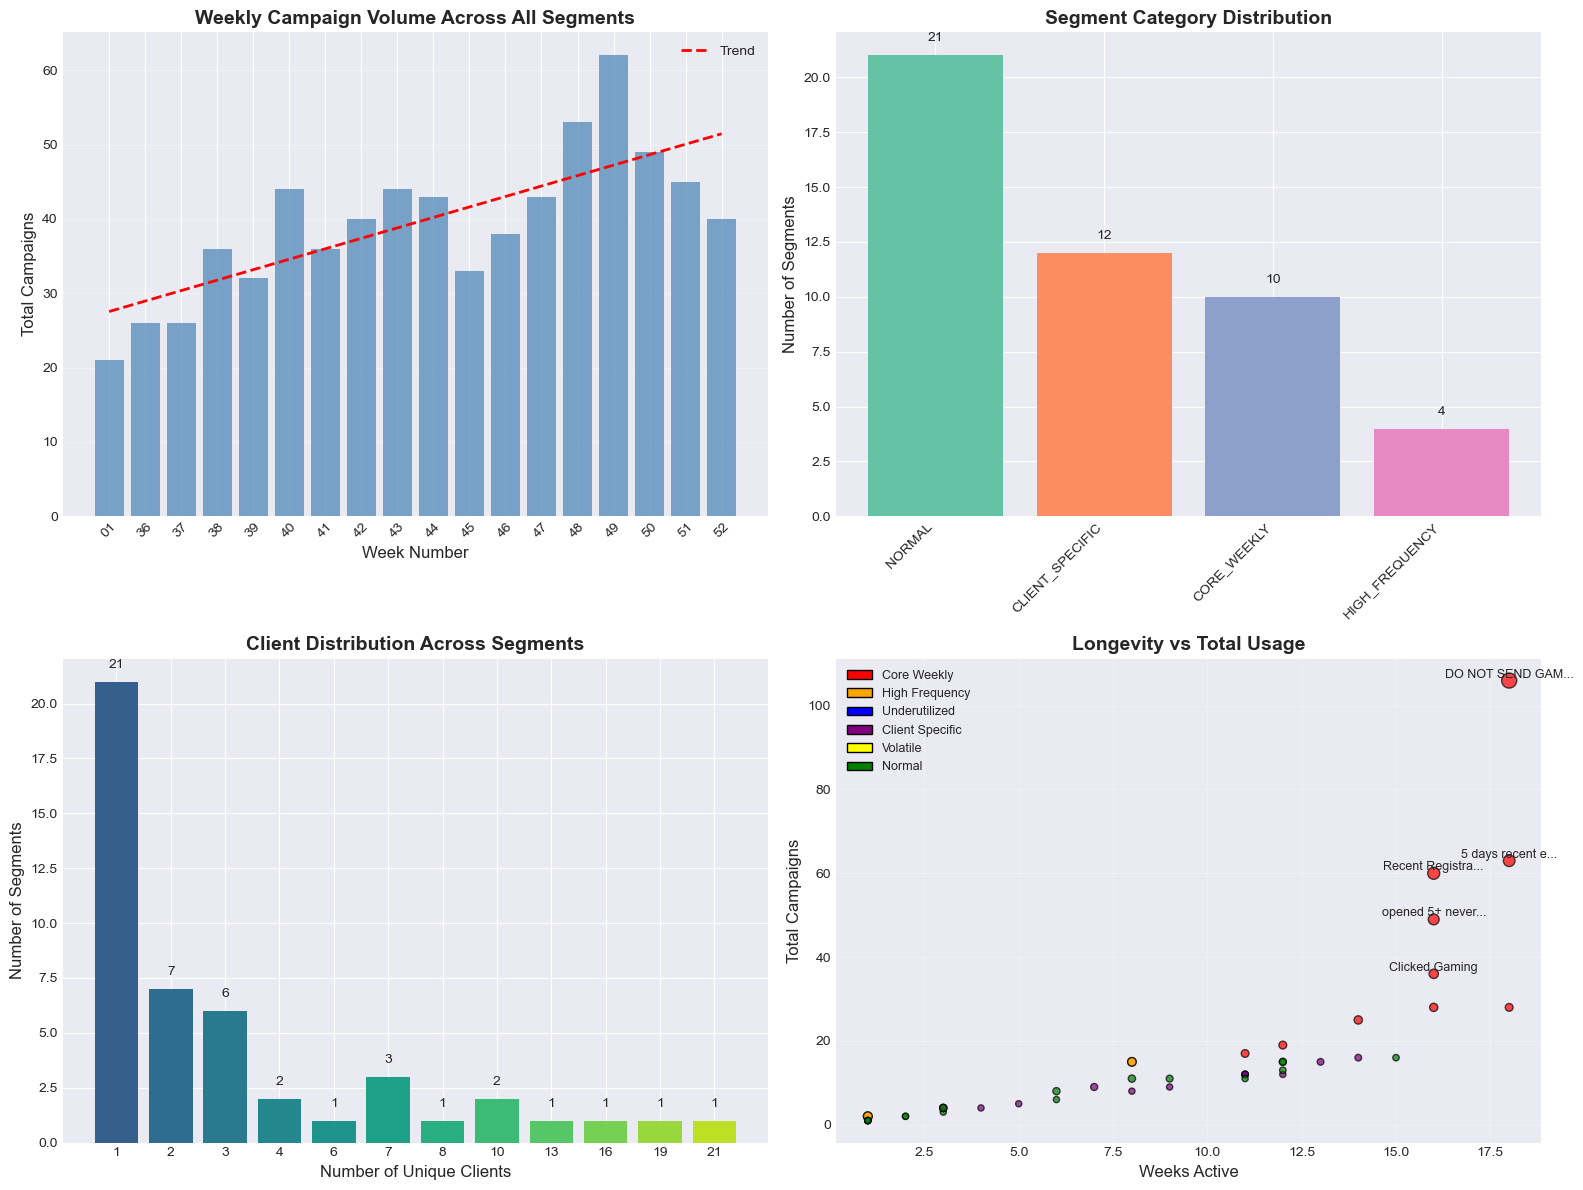

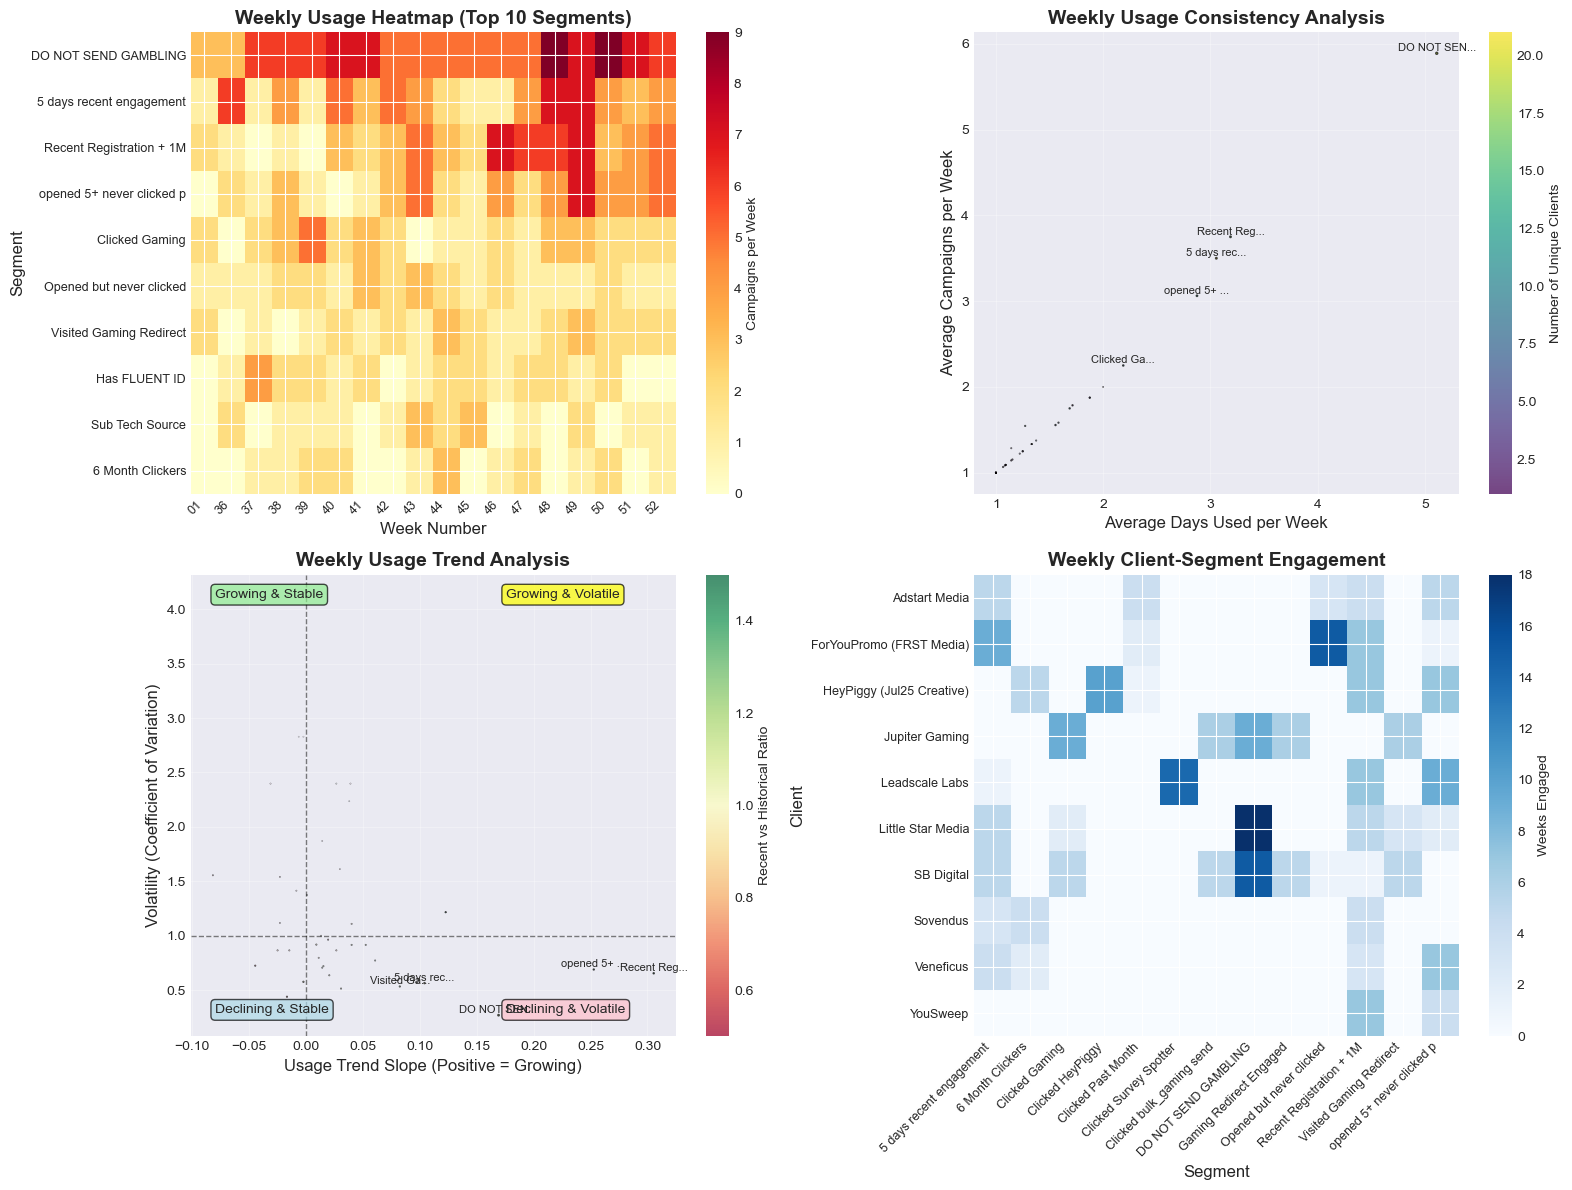

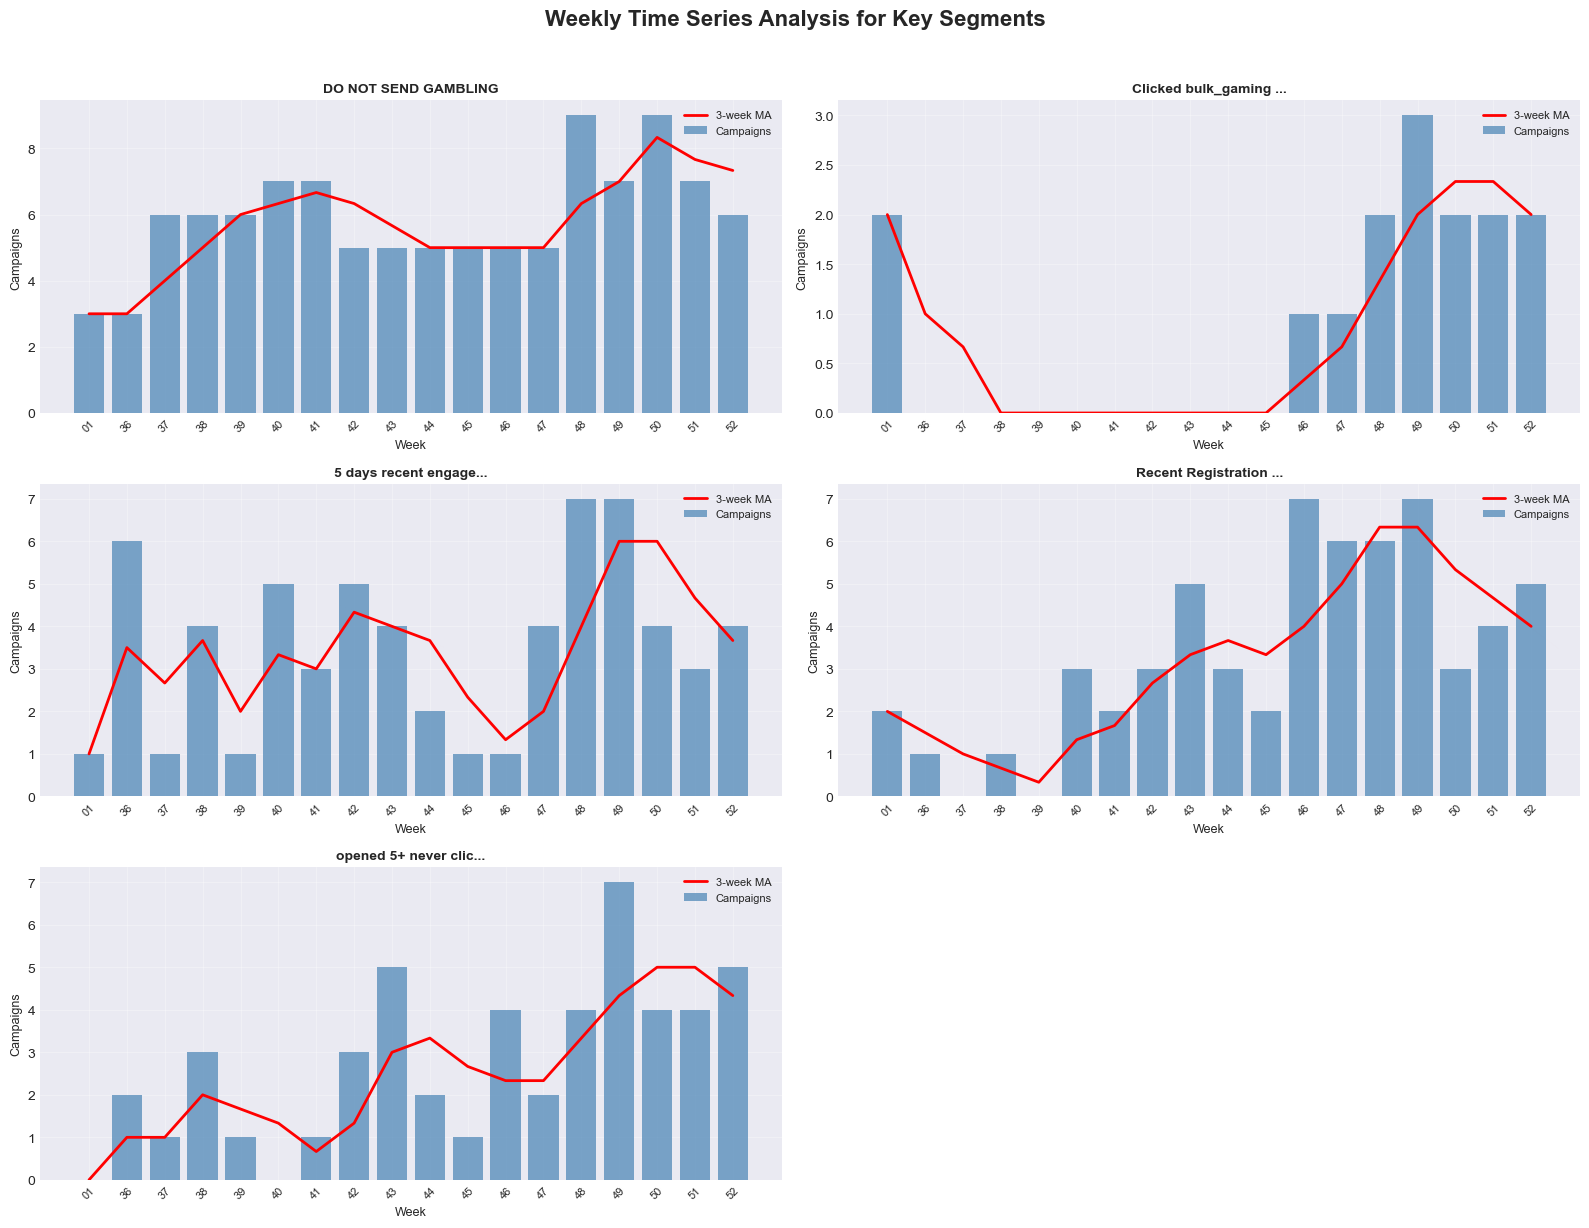

ValueError: Bin edges must be unique: array([1.        , 1.        , 1.15384615, 1.56944444, 5.88888889]).
You can drop duplicate edges by setting the 'duplicates' kwarg

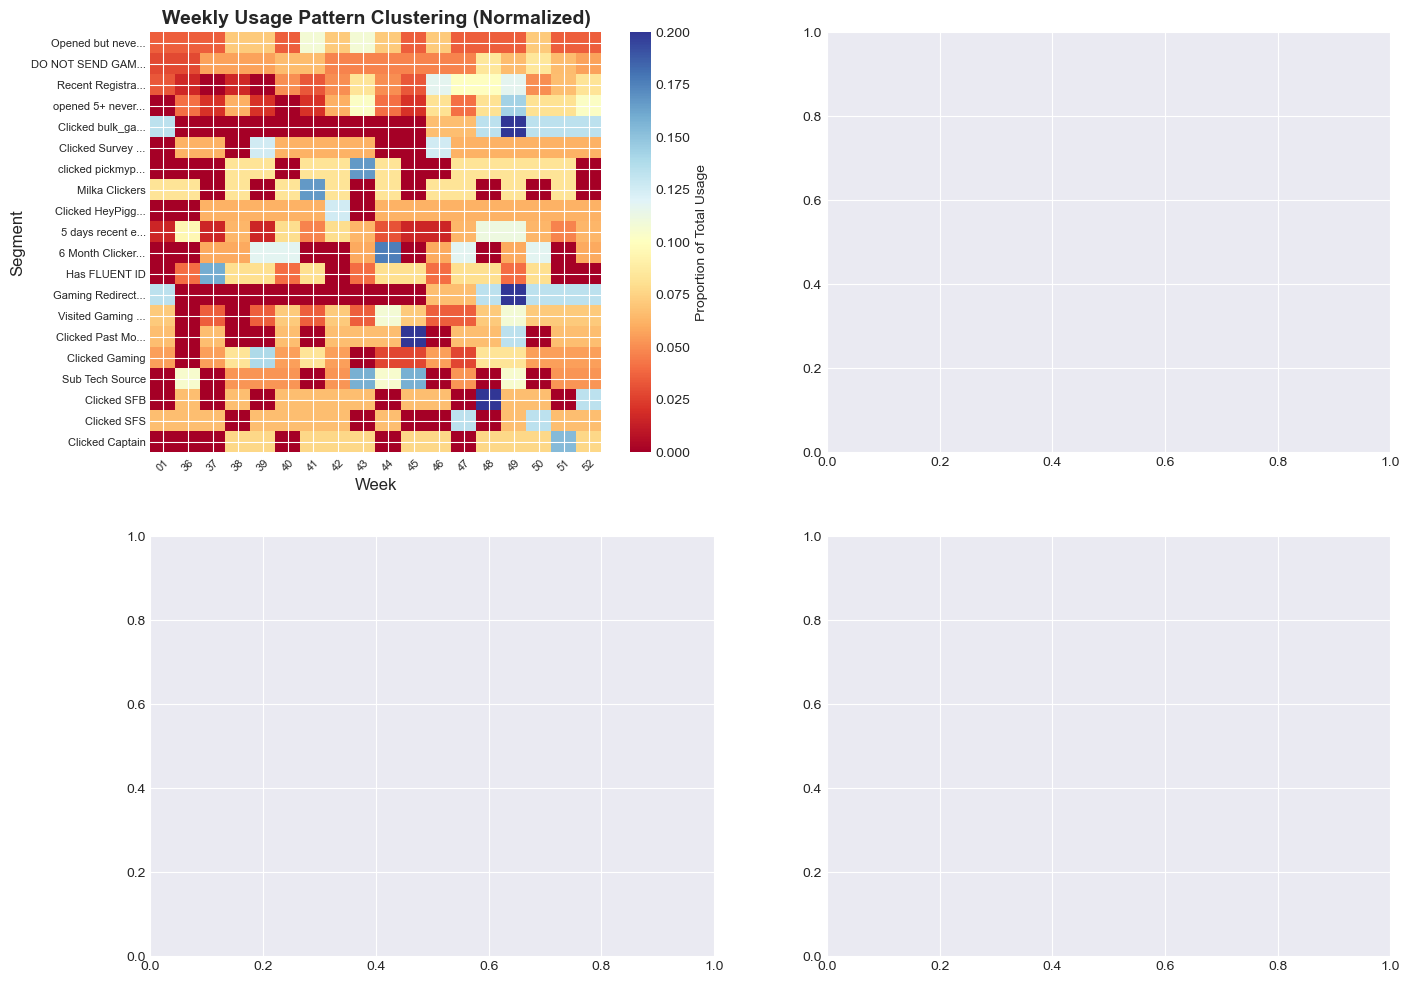

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import calendar
from collections import Counter
warnings.filterwarnings('ignore')

def analyze_weekly_segment_usage(df):
    """
    Analyzes weekly segment usage patterns including frequency, client usage, and trends.
    
    Parameters:
    df (DataFrame): DataFrame with weekly segment usage data including:
        - segment_id, segment_name, year, week, campaigns_this_week, 
          days_used_this_week, clients_this_week
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['campaigns_this_week', 'days_used_this_week']
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Create week identifier
    df_analysis['week_id'] = df_analysis['year'].astype(str) + '-W' + df_analysis['week'].astype(str).str.zfill(2)
    df_analysis['week_start'] = pd.to_datetime(df_analysis['week_id'] + '-1', format='%Y-W%W-%w')
    
    # Calculate segment-level statistics
    segment_stats = df_analysis.groupby(['segment_id', 'segment_name']).agg({
        'week_id': ['min', 'max', 'nunique'],
        'campaigns_this_week': ['sum', 'mean', 'max', 'std'],
        'days_used_this_week': ['sum', 'mean'],
        'clients_this_week': lambda x: ','.join(set(','.join(x.dropna()).split(',')))
    }).reset_index()
    
    # Flatten column names
    segment_stats.columns = ['segment_id', 'segment_name', 'first_week', 'last_week', 
                           'weeks_active', 'total_campaigns', 'avg_campaigns_per_week',
                           'max_campaigns_week', 'std_campaigns', 'total_days_used',
                           'avg_days_per_week', 'all_clients']
    
    # Calculate additional metrics
    segment_stats['avg_campaigns_per_day'] = segment_stats['total_campaigns'] / segment_stats['total_days_used']
    segment_stats['campaigns_per_active_week'] = segment_stats['total_campaigns'] / segment_stats['weeks_active']
    
    # Calculate unique clients
    segment_stats['unique_clients'] = segment_stats['all_clients'].apply(
        lambda x: len(set([c.strip() for c in x.split(',') if c.strip()])) if x else 0
    )
    
    # Calculate client concentration
    segment_stats['client_diversity'] = segment_stats['all_clients'].apply(
        lambda x: len(set([c.strip() for c in x.split(',') if c.strip()])) / 
                  len([c.strip() for c in x.split(',') if c.strip()]) if x else 0
    )
    
    # Create segment categorization
    def categorize_segment(row):
        if row['total_campaigns'] >= segment_stats['total_campaigns'].quantile(0.8):
            return 'CORE_WEEKLY'
        elif row['avg_campaigns_per_week'] >= segment_stats['avg_campaigns_per_week'].quantile(0.8):
            return 'HIGH_FREQUENCY'
        elif row['weeks_active'] >= 4 and row['total_campaigns'] <= segment_stats['total_campaigns'].quantile(0.2):
            return 'UNDERUTILIZED'
        elif row['unique_clients'] == 1 and row['weeks_active'] > 2:
            return 'CLIENT_SPECIFIC'
        elif row['std_campaigns'] / row['avg_campaigns_per_week'] > 1.5 and row['avg_campaigns_per_week'] > 0:
            return 'VOLATILE'
        else:
            return 'NORMAL'
    
    segment_stats['segment_category'] = segment_stats.apply(categorize_segment, axis=1)
    
    # Calculate weekly growth/trend for each segment
    weekly_data = df_analysis.pivot_table(
        index=['segment_id', 'segment_name'],
        columns='week_id',
        values='campaigns_this_week',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate trend metrics
    trend_metrics = []
    for idx, row in weekly_data.iterrows():
        segment_id, segment_name = idx
        values = row.dropna().values
        
        if len(values) > 2:
            # Calculate slope of linear regression
            x = np.arange(len(values))
            slope = np.polyfit(x, values, 1)[0] if len(values) > 1 else 0
            
            # Calculate coefficient of variation
            cv = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            
            # Calculate recent vs historical
            if len(values) >= 4:
                recent_avg = np.mean(values[-2:])
                historical_avg = np.mean(values[:-2])
                trend_ratio = recent_avg / historical_avg if historical_avg > 0 else 0
            else:
                trend_ratio = 0
            
            trend_metrics.append({
                'segment_id': segment_id,
                'segment_name': segment_name,
                'usage_slope': slope,
                'volatility': cv,
                'trend_ratio': trend_ratio
            })
    
    if trend_metrics:
        trend_df = pd.DataFrame(trend_metrics)
        segment_stats = segment_stats.merge(trend_df, on=['segment_id', 'segment_name'], how='left')
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Weekly Usage Overview
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Weekly Campaign Volume Over Time
    weekly_totals = df_analysis.groupby('week_id')['campaigns_this_week'].sum()
    
    # Sort weeks chronologically
    week_order = sorted(weekly_totals.index, key=lambda x: (int(x.split('-')[0]), int(x.split('W')[1])))
    weekly_totals = weekly_totals.reindex(week_order)
    
    ax1.bar(range(len(weekly_totals)), weekly_totals.values, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(weekly_totals)))
    ax1.set_xticklabels([w.split('-W')[1] if '-W' in w else w[-2:] for w in weekly_totals.index], 
                       rotation=45, fontsize=10)
    ax1.set_xlabel('Week Number', fontsize=12)
    ax1.set_ylabel('Total Campaigns', fontsize=12)
    ax1.set_title('Weekly Campaign Volume Across All Segments', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add trend line
    if len(weekly_totals) > 3:
        z = np.polyfit(range(len(weekly_totals)), weekly_totals.values, 1)
        p = np.poly1d(z)
        ax1.plot(range(len(weekly_totals)), p(range(len(weekly_totals))), "r--", linewidth=2, label='Trend')
        ax1.legend()
    
    # Plot 2: Segment Usage Distribution by Category
    category_counts = segment_stats['segment_category'].value_counts()
    colors2 = plt.cm.Set2(np.arange(len(category_counts)))
    bars2 = ax2.bar(range(len(category_counts)), category_counts.values, color=colors2)
    ax2.set_xticks(range(len(category_counts)))
    ax2.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
    ax2.set_ylabel('Number of Segments', fontsize=12)
    ax2.set_title('Segment Category Distribution', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Client Distribution Analysis
    client_counts = segment_stats['unique_clients'].value_counts().sort_index()
    colors3 = plt.cm.viridis(np.linspace(0.3, 0.9, len(client_counts)))
    bars3 = ax3.bar(range(len(client_counts)), client_counts.values, color=colors3)
    ax3.set_xticks(range(len(client_counts)))
    ax3.set_xticklabels(client_counts.index.astype(str), fontsize=10)
    ax3.set_xlabel('Number of Unique Clients', fontsize=12)
    ax3.set_ylabel('Number of Segments', fontsize=12)
    ax3.set_title('Client Distribution Across Segments', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Usage vs Weeks Active
    scatter4 = ax4.scatter(segment_stats['weeks_active'], segment_stats['total_campaigns'],
                          s=segment_stats['avg_campaigns_per_week'] * 20,
                          c=segment_stats['segment_category'].map({
                              'CORE_WEEKLY': 'red',
                              'HIGH_FREQUENCY': 'orange',
                              'UNDERUTILIZED': 'blue',
                              'CLIENT_SPECIFIC': 'purple',
                              'VOLATILE': 'yellow',
                              'NORMAL': 'green'
                          }),
                          alpha=0.7, edgecolors='black')
    
    # Add labels for top segments
    top_segments = segment_stats.nlargest(5, 'total_campaigns')
    for _, row in top_segments.iterrows():
        ax4.annotate(row['segment_name'][:15] + '...' if len(row['segment_name']) > 15 else row['segment_name'],
                    (row['weeks_active'], row['total_campaigns']),
                    fontsize=9, ha='center', va='bottom')
    
    ax4.set_xlabel('Weeks Active', fontsize=12)
    ax4.set_ylabel('Total Campaigns', fontsize=12)
    ax4.set_title('Longevity vs Total Usage', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='Core Weekly'),
        Patch(facecolor='orange', edgecolor='black', label='High Frequency'),
        Patch(facecolor='blue', edgecolor='black', label='Underutilized'),
        Patch(facecolor='purple', edgecolor='black', label='Client Specific'),
        Patch(facecolor='yellow', edgecolor='black', label='Volatile'),
        Patch(facecolor='green', edgecolor='black', label='Normal')
    ]
    ax4.legend(handles=legend_elements, fontsize=9, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Weekly Pattern Analysis
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 5: Weekly Heatmap for Top Segments
    top_10_segments = segment_stats.nlargest(10, 'total_campaigns')
    
    # Create pivot table for heatmap
    heatmap_data = df_analysis[df_analysis['segment_id'].isin(top_10_segments['segment_id'])]
    heatmap_pivot = heatmap_data.pivot_table(
        index='segment_name',
        columns='week_id',
        values='campaigns_this_week',
        aggfunc='sum',
        fill_value=0
    )
    
    # Sort weeks chronologically
    week_cols = sorted(heatmap_pivot.columns, key=lambda x: (int(x.split('-')[0]), int(x.split('W')[1])))
    heatmap_pivot = heatmap_pivot[week_cols]
    
    # Sort segments by total usage
    heatmap_pivot['total'] = heatmap_pivot.sum(axis=1)
    heatmap_pivot = heatmap_pivot.sort_values('total', ascending=False).drop('total', axis=1)
    
    im5 = ax5.imshow(heatmap_pivot.values, aspect='auto', cmap='YlOrRd')
    ax5.set_xticks(range(len(heatmap_pivot.columns)))
    ax5.set_xticklabels([col.split('-W')[1] if '-W' in col else col[-2:] for col in heatmap_pivot.columns],
                       rotation=45, ha='right', fontsize=9)
    ax5.set_yticks(range(len(heatmap_pivot.index)))
    ax5.set_yticklabels(heatmap_pivot.index, fontsize=9)
    ax5.set_xlabel('Week Number', fontsize=12)
    ax5.set_ylabel('Segment', fontsize=12)
    ax5.set_title('Weekly Usage Heatmap (Top 10 Segments)', fontsize=14, fontweight='bold')
    
    cbar5 = fig2.colorbar(im5, ax=ax5)
    cbar5.set_label('Campaigns per Week', fontsize=10)
    
    # Plot 6: Usage Consistency Analysis
    if 'avg_days_per_week' in segment_stats.columns:
        scatter6 = ax6.scatter(segment_stats['avg_days_per_week'], segment_stats['avg_campaigns_per_week'],
                              s=segment_stats['total_campaigns']/50,
                              c=segment_stats['unique_clients'],
                              cmap='viridis', alpha=0.7, edgecolors='black')
        
        # Add labels for outliers
        high_usage = segment_stats[segment_stats['avg_campaigns_per_week'] > segment_stats['avg_campaigns_per_week'].quantile(0.9)]
        for _, row in high_usage.iterrows():
            ax6.annotate(row['segment_name'][:10] + '...',
                        (row['avg_days_per_week'], row['avg_campaigns_per_week']),
                        fontsize=8, ha='center', va='bottom')
        
        ax6.set_xlabel('Average Days Used per Week', fontsize=12)
        ax6.set_ylabel('Average Campaigns per Week', fontsize=12)
        ax6.set_title('Weekly Usage Consistency Analysis', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        cbar6 = fig2.colorbar(scatter6, ax=ax6)
        cbar6.set_label('Number of Unique Clients', fontsize=10)
    
    # Plot 7: Weekly Trend Analysis
    if 'usage_slope' in segment_stats.columns:
        trend_data = segment_stats.dropna(subset=['usage_slope', 'trend_ratio'])
        if len(trend_data) > 0:
            scatter7 = ax7.scatter(trend_data['usage_slope'], trend_data['volatility'],
                                  s=trend_data['total_campaigns']/100,
                                  c=trend_data['trend_ratio'],
                                  cmap='RdYlGn', alpha=0.7, edgecolors='black',
                                  vmin=0.5, vmax=1.5)
            
            ax7.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax7.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5)
            
            # Add quadrant labels
            ax7.text(0.05, 0.95, 'Growing & Stable', transform=ax7.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
            ax7.text(0.65, 0.95, 'Growing & Volatile', transform=ax7.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
            ax7.text(0.05, 0.05, 'Declining & Stable', transform=ax7.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            ax7.text(0.65, 0.05, 'Declining & Volatile', transform=ax7.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='pink', alpha=0.7))
            
            # Add labels for significant segments
            significant = trend_data[abs(trend_data['usage_slope']) > trend_data['usage_slope'].std()]
            for _, row in significant.nlargest(5, 'total_campaigns').iterrows():
                ax7.annotate(row['segment_name'][:10] + '...',
                            (row['usage_slope'], row['volatility']),
                            fontsize=8, ha='center', va='bottom')
            
            ax7.set_xlabel('Usage Trend Slope (Positive = Growing)', fontsize=12)
            ax7.set_ylabel('Volatility (Coefficient of Variation)', fontsize=12)
            ax7.set_title('Weekly Usage Trend Analysis', fontsize=14, fontweight='bold')
            ax7.grid(True, alpha=0.3)
            
            cbar7 = fig2.colorbar(scatter7, ax=ax7)
            cbar7.set_label('Recent vs Historical Ratio', fontsize=10)
    
    # Plot 8: Client Engagement Analysis
    # Extract client-segment-week data
    client_segment_weeks = []
    for _, row in df_analysis.iterrows():
        if isinstance(row['clients_this_week'], str):
            clients = [c.strip() for c in row['clients_this_week'].split(',') if c.strip()]
            for client in clients:
                client_segment_weeks.append({
                    'client': client,
                    'segment_id': row['segment_id'],
                    'segment_name': row['segment_name'],
                    'week_id': row['week_id'],
                    'campaigns': row['campaigns_this_week']
                })
    
    if client_segment_weeks:
        client_segment_df = pd.DataFrame(client_segment_weeks)
        
        # Get top clients
        top_clients = client_segment_df['client'].value_counts().nlargest(10).index
        
        # Get top segments
        top_segments_client = client_segment_df['segment_name'].value_counts().nlargest(15).index
        
        # Create pivot table
        pivot_data = client_segment_df[client_segment_df['client'].isin(top_clients) & 
                                      client_segment_df['segment_name'].isin(top_segments_client)]
        
        if not pivot_data.empty:
            heatmap_data_8 = pivot_data.pivot_table(
                index='client',
                columns='segment_name',
                values='campaigns',
                aggfunc='count',
                fill_value=0
            )
            
            im8 = ax8.imshow(heatmap_data_8.values, aspect='auto', cmap='Blues')
            ax8.set_xticks(range(len(heatmap_data_8.columns)))
            ax8.set_yticks(range(len(heatmap_data_8.index)))
            ax8.set_xticklabels(heatmap_data_8.columns, rotation=45, ha='right', fontsize=9)
            ax8.set_yticklabels(heatmap_data_8.index, fontsize=9)
            ax8.set_xlabel('Segment', fontsize=12)
            ax8.set_ylabel('Client', fontsize=12)
            ax8.set_title('Weekly Client-Segment Engagement', fontsize=14, fontweight='bold')
            
            cbar8 = fig2.colorbar(im8, ax=ax8)
            cbar8.set_label('Weeks Engaged', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Time Series Analysis for Key Segments
    fig3, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Select segments to display (mix of categories)
    display_segments = []
    categories_to_show = ['CORE_WEEKLY', 'HIGH_FREQUENCY', 'VOLATILE', 'UNDERUTILIZED']
    
    for category in categories_to_show:
        if category in segment_stats['segment_category'].values:
            cat_segments = segment_stats[segment_stats['segment_category'] == category]
            if len(cat_segments) > 0:
                # Get top segment by total campaigns in this category
                top_in_cat = cat_segments.nlargest(1, 'total_campaigns')
                if len(top_in_cat) > 0:
                    display_segments.append(top_in_cat.iloc[0])
    
    # Fill remaining slots with top overall segments
    remaining_slots = 6 - len(display_segments)
    if remaining_slots > 0:
        additional = segment_stats.nlargest(remaining_slots, 'total_campaigns')
        for _, row in additional.iterrows():
            if row['segment_id'] not in [s['segment_id'] for s in display_segments]:
                display_segments.append(row)
    
    # Plot time series for each selected segment
    for idx, segment in enumerate(display_segments[:6]):
        segment_data = df_analysis[df_analysis['segment_id'] == segment['segment_id']]
        
        # Sort by week
        segment_data = segment_data.sort_values('week_id')
        
        # Create complete time series
        all_weeks = sorted(df_analysis['week_id'].unique(), 
                          key=lambda x: (int(x.split('-')[0]), int(x.split('W')[1])))
        
        # Reindex to include all weeks
        segment_series = segment_data.set_index('week_id')['campaigns_this_week'].reindex(all_weeks, fill_value=0)
        
        # Plot
        axes[idx].bar(range(len(segment_series)), segment_series.values, 
                     color='steelblue', alpha=0.7, label='Campaigns')
        
        # Add moving average if enough data
        if len(segment_series) > 3:
            moving_avg = segment_series.rolling(window=3, min_periods=1).mean()
            axes[idx].plot(range(len(moving_avg)), moving_avg.values, 
                          color='red', linewidth=2, label='3-week MA')
        
        axes[idx].set_xticks(range(len(segment_series)))
        axes[idx].set_xticklabels([w.split('-W')[1] if '-W' in w else w[-2:] 
                                 for w in segment_series.index], rotation=45, fontsize=8)
        axes[idx].set_xlabel('Week', fontsize=9)
        axes[idx].set_ylabel('Campaigns', fontsize=9)
        axes[idx].set_title(f"{segment['segment_name'][:20]}..." 
                          if len(segment['segment_name']) > 20 else segment['segment_name'], 
                          fontsize=10, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend(fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(display_segments), 6):
        axes[idx].set_visible(False)
    
    plt.suptitle('Weekly Time Series Analysis for Key Segments', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Advanced Pattern Analysis
    fig4, ((ax9, ax10), (ax11, ax12)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 9: Usage Pattern Clustering (Heatmap of segments vs weeks)
    if len(weekly_data) > 1:
        # Select top 20 segments for clustering
        top_segments_cluster = segment_stats.nlargest(20, 'total_campaigns')['segment_name'].tolist()
        
        # Get data for these segments
        cluster_data = weekly_data.loc[[idx for idx in weekly_data.index 
                                       if idx[1] in top_segments_cluster]]
        
        if len(cluster_data) > 0:
            # Normalize by segment for better comparison
            normalized = cluster_data.div(cluster_data.sum(axis=1), axis=0)
            
            im9 = ax9.imshow(normalized.values, aspect='auto', cmap='RdYlBu')
            ax9.set_yticks(range(len(normalized)))
            ax9.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                                for name in normalized.index.get_level_values(1)], fontsize=8)
            ax9.set_xticks(range(len(normalized.columns)))
            ax9.set_xticklabels([col.split('-W')[1] if '-W' in col else col[-2:]
                                for col in normalized.columns], rotation=45, fontsize=8)
            ax9.set_xlabel('Week', fontsize=12)
            ax9.set_ylabel('Segment', fontsize=12)
            ax9.set_title('Weekly Usage Pattern Clustering (Normalized)', fontsize=14, fontweight='bold')
            
            cbar9 = fig4.colorbar(im9, ax=ax9)
            cbar9.set_label('Proportion of Total Usage', fontsize=10)
    
    # Plot 10: Segment Portfolio Analysis
    # Create 2x2 matrix: Usage Frequency vs Client Diversity
    segment_stats['freq_quartile'] = pd.qcut(segment_stats['avg_campaigns_per_week'], 
                                            q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    segment_stats['diversity_quartile'] = pd.qcut(segment_stats['unique_clients'].fillna(0), 
                                                 q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    portfolio_matrix = pd.crosstab(segment_stats['freq_quartile'], 
                                  segment_stats['diversity_quartile'])
    
    im10 = ax10.imshow(portfolio_matrix.values, cmap='YlOrRd', aspect='auto')
    ax10.set_xticks(range(len(portfolio_matrix.columns)))
    ax10.set_yticks(range(len(portfolio_matrix.index)))
    ax10.set_xticklabels(portfolio_matrix.columns)
    ax10.set_yticklabels(portfolio_matrix.index)
    ax10.set_xlabel('Client Diversity Quartile', fontsize=12)
    ax10.set_ylabel('Usage Frequency Quartile', fontsize=12)
    ax10.set_title('Segment Portfolio Analysis Matrix', fontsize=14, fontweight='bold')
    
    # Add quadrant annotations
    ax10.text(0.5, 0.5, 'NICHE\n(Low Freq, Low Diversity)', 
             transform=ax10.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax10.text(3.5, 0.5, 'SPECIALIZED\n(Low Freq, High Diversity)', 
             transform=ax10.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    ax10.text(0.5, 3.5, 'INTENSIVE\n(High Freq, Low Diversity)', 
             transform=ax10.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    ax10.text(3.5, 3.5, 'STRATEGIC\n(High Freq, High Diversity)', 
             transform=ax10.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    # Add value labels
    for i in range(len(portfolio_matrix.index)):
        for j in range(len(portfolio_matrix.columns)):
            count = portfolio_matrix.iloc[i, j]
            if count > 0:
                text_color = 'white' if count > portfolio_matrix.values.mean() else 'black'
                ax10.text(j, i, f'{count}', ha='center', va='center',
                         color=text_color, fontsize=10, fontweight='bold')
    
    cbar10 = fig4.colorbar(im10, ax=ax10)
    cbar10.set_label('Number of Segments', fontsize=10)
    
    # Plot 11: Week-over-Week Growth Analysis
    if len(weekly_totals) > 2:
        week_growth = weekly_totals.pct_change().dropna() * 100
        
        colors11 = ['green' if x > 0 else 'red' for x in week_growth]
        bars11 = ax11.bar(range(len(week_growth)), week_growth.values, color=colors11, alpha=0.7)
        
        ax11.set_xticks(range(len(week_growth)))
        ax11.set_xticklabels([f"W{weekly_totals.index[i-1].split('-W')[1]}-W{weekly_totals.index[i].split('-W')[1]}" 
                             for i in range(1, len(weekly_totals))], rotation=45, fontsize=9)
        ax11.set_xlabel('Week Transition', fontsize=12)
        ax11.set_ylabel('Growth Rate (%)', fontsize=12)
        ax11.set_title('Week-over-Week Total Usage Growth', fontsize=14, fontweight='bold')
        ax11.axhline(y=0, color='black', linewidth=0.5)
        ax11.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars11:
            height = bar.get_height()
            va = 'bottom' if height > 0 else 'top'
            color = 'green' if height > 0 else 'red'
            ax11.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
                     f'{height:.1f}%', ha='center', va=va, fontsize=9, color=color, fontweight='bold')
    
    # Plot 12: Segment Adoption Curve
    # Calculate when segments were first used and their subsequent growth
    segment_adoption = segment_stats[['segment_name', 'first_week', 'weeks_active', 'total_campaigns']].copy()
    
    # Convert first_week to week number
    def week_to_number(week_str):
        try:
            year, week = week_str.split('-W')
            return int(year) * 52 + int(week)
        except:
            return 0
    
    if 'first_week' in segment_adoption.columns:
        segment_adoption['first_week_num'] = segment_adoption['first_week'].apply(week_to_number)
        
        if segment_adoption['first_week_num'].max() > 0:
            # Group by first week and analyze
            adoption_by_week = segment_adoption.groupby('first_week_num').agg({
                'segment_name': 'count',
                'total_campaigns': 'mean'
            }).reset_index()
            
            if len(adoption_by_week) > 2:
                ax12_twin = ax12.twinx()
                
                # Plot number of new segments
                ax12.bar(adoption_by_week['first_week_num'], adoption_by_week['segment_name'],
                        alpha=0.6, color='steelblue', label='New Segments')
                ax12.set_xlabel('Week (Cumulative)', fontsize=12)
                ax12.set_ylabel('New Segments Introduced', fontsize=12, color='steelblue')
                
                # Plot average campaigns of new segments
                ax12_twin.plot(adoption_by_week['first_week_num'], adoption_by_week['total_campaigns'],
                             color='red', marker='o', linewidth=2, markersize=5,
                             label='Avg Campaigns per New Segment')
                ax12_twin.set_ylabel('Average Campaigns', fontsize=12, color='red')
                
                ax12.set_title('Segment Adoption Curve Over Time', fontsize=14, fontweight='bold')
                
                # Combine legends
                lines, labels = ax12.get_legend_handles_labels()
                lines2, labels2 = ax12_twin.get_legend_handles_labels()
                ax12.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("WEEKLY SEGMENT USAGE ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_segments = len(segment_stats)
    total_weeks = df_analysis['week_id'].nunique()
    total_campaigns = segment_stats['total_campaigns'].sum()
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Total Weeks Analyzed: {total_weeks}")
    print(f"   • Total Campaigns Across All Segments: {total_campaigns:,}")
    print(f"   • Average Campaigns per Segment: {segment_stats['total_campaigns'].mean():.1f}")
    print(f"   • Average Weeks Active per Segment: {segment_stats['weeks_active'].mean():.1f}")
    
    # Segment Categories Analysis
    print(f"\n🏷️ SEGMENT CATEGORIES:")
    category_summary = segment_stats['segment_category'].value_counts()
    for category, count in category_summary.items():
        percentage = (count / total_segments) * 100
        campaigns = segment_stats[segment_stats['segment_category'] == category]['total_campaigns'].sum()
        campaign_percentage = (campaigns / total_campaigns) * 100
        print(f"   • {category}: {count} segments ({percentage:.1f}%) - "
              f"{campaign_percentage:.1f}% of total campaigns")
    
    # Core Weekly Segments
    print(f"\n🏆 CORE WEEKLY SEGMENTS:")
    core_segments = segment_stats[segment_stats['segment_category'] == 'CORE_WEEKLY']
    if len(core_segments) > 0:
        print(f"   • {len(core_segments)} core weekly segments identified")
        print(f"   • These segments account for {core_segments['total_campaigns'].sum()/total_campaigns*100:.1f}% of total usage")
        
        print(f"   • Top Core Weekly Segments:")
        top_core = core_segments.nlargest(3, 'total_campaigns')
        for i, (_, segment) in enumerate(top_core.iterrows(), 1):
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - {segment['total_campaigns']:,} total campaigns")
            print(f"        - Active {segment['weeks_active']} weeks ({segment['avg_campaigns_per_week']:.1f}/week)")
            print(f"        - Used by {segment['unique_clients']} client(s)")
    
    # High Frequency Segments
    print(f"\n⚡ HIGH FREQUENCY SEGMENTS:")
    high_freq_segments = segment_stats[segment_stats['segment_category'] == 'HIGH_FREQUENCY']
    if len(high_freq_segments) > 0:
        print(f"   • {len(high_freq_segments)} high frequency segments identified")
        print(f"   • Average campaigns per week: {high_freq_segments['avg_campaigns_per_week'].mean():.1f}")
        
        # Check for potential fatigue
        fatigue_candidates = high_freq_segments[high_freq_segments['avg_days_per_week'] > 4]
        if len(fatigue_candidates) > 0:
            print(f"   • {len(fatigue_candidates)} segments used >4 days/week on average - fatigue risk")
    
    # Underutilized Segments
    print(f"\n📉 UNDERUTILIZED SEGMENTS:")
    underutilized_segments = segment_stats[segment_stats['segment_category'] == 'UNDERUTILIZED']
    if len(underutilized_segments) > 0:
        print(f"   • {len(underutilized_segments)} underutilized segments identified")
        
        # Find segments with high weeks_active but low usage
        high_potential = underutilized_segments[underutilized_segments['weeks_active'] > 6]
        if len(high_potential) > 0:
            print(f"   • {len(high_potential)} segments active >6 weeks but rarely used")
            
            print(f"   • Highest Potential Underutilized Segments:")
            for i, (_, segment) in enumerate(high_potential.nlargest(3, 'weeks_active').iterrows(), 1):
                usage_rate = segment['total_campaigns'] / segment['weeks_active']
                print(f"     {i}. {segment['segment_name']}")
                print(f"        - Active {segment['weeks_active']} weeks")
                print(f"        - Only {segment['total_campaigns']} total campaigns ({usage_rate:.1f}/week)")
    
    # Volatile Segments
    print(f"\n📊 VOLATILE SEGMENTS:")
    volatile_segments = segment_stats[segment_stats['segment_category'] == 'VOLATILE']
    if len(volatile_segments) > 0:
        print(f"   • {len(volatile_segments)} volatile segments identified")
        print(f"   • These show high week-to-week variability in usage")
        
        if 'volatility' in segment_stats.columns:
            avg_volatility = volatile_segments['volatility'].mean()
            print(f"   • Average volatility (CV): {avg_volatility:.2f}")
    
    # Client-Specific Segments
    print(f"\n👥 CLIENT-SPECIFIC SEGMENTS:")
    client_specific = segment_stats[segment_stats['segment_category'] == 'CLIENT_SPECIFIC']
    if len(client_specific) > 0:
        print(f"   • {len(client_specific)} client-specific segments identified")
        
        # Analyze which clients have exclusive segments
        client_exclusive_counts = {}
        for _, segment in client_specific.iterrows():
            if segment['all_clients']:
                clients = [c.strip() for c in segment['all_clients'].split(',') if c.strip()]
                if len(clients) == 1:
                    client = clients[0]
                    client_exclusive_counts[client] = client_exclusive_counts.get(client, 0) + 1
        
        if client_exclusive_counts:
            print(f"   • Client with most exclusive segments:")
            for client, count in sorted(client_exclusive_counts.items(), key=lambda x: x[1], reverse=True)[:3]:
                print(f"     - {client}: {count} exclusive segments")
    
    # Trend Analysis
    print(f"\n📈 TREND ANALYSIS:")
    
    if 'usage_slope' in segment_stats.columns:
        growing_segments = segment_stats[segment_stats['usage_slope'] > 0.1]
        declining_segments = segment_stats[segment_stats['usage_slope'] < -0.1]
        
        if len(growing_segments) > 0:
            print(f"   • {len(growing_segments)} segments showing growth trend")
            fastest_growing = growing_segments.nlargest(1, 'usage_slope')
            if len(fastest_growing) > 0:
                segment = fastest_growing.iloc[0]
                print(f"     - Fastest growing: {segment['segment_name']} (slope: {segment['usage_slope']:.2f})")
        
        if len(declining_segments) > 0:
            print(f"   • {len(declining_segments)} segments showing decline trend")
    
    # Client Adoption Analysis
    print(f"\n👥 CLIENT ADOPTION ANALYSIS:")
    avg_clients_per_segment = segment_stats['unique_clients'].mean()
    single_client_segments = len(segment_stats[segment_stats['unique_clients'] == 1])
    
    print(f"   • Average clients per segment: {avg_clients_per_segment:.1f}")
    print(f"   • Segments used by only one client: {single_client_segments}")
    
    if avg_clients_per_segment > 2:
        print(f"   • Broad adoption: Segments generally used by multiple clients")
    elif single_client_segments > total_segments * 0.4:
        print(f"   • Siloed usage: Many segments specific to individual clients")
    
    # Concentration Analysis
    print(f"\n🎯 CONCENTRATION ANALYSIS:")
    top_10_percent = int(total_segments * 0.1) or 1
    top_segments_usage = segment_stats.nlargest(top_10_percent, 'total_campaigns')['total_campaigns'].sum()
    concentration_ratio = top_segments_usage / total_campaigns * 100
    
    print(f"   • Top {top_10_percent} segments account for {concentration_ratio:.1f}% of all usage")
    
    if concentration_ratio > 50:
        print(f"   • High concentration: Heavy reliance on few segments")
    elif concentration_ratio > 30:
        print(f"   • Moderate concentration: Balanced usage distribution")
    else:
        print(f"   • Low concentration: Usage spread across many segments")
    
    # Weekly Patterns
    print(f"\n📅 WEEKLY PATTERNS:")
    if len(weekly_totals) > 1:
        avg_weekly_campaigns = weekly_totals.mean()
        busiest_week = weekly_totals.idxmax()
        busiest_week_value = weekly_totals.max()
        quietest_week = weekly_totals.idxmin()
        quietest_week_value = weekly_totals.min()
        
        print(f"   • Average campaigns per week: {avg_weekly_campaigns:.0f}")
        print(f"   • Busiest week: {busiest_week} ({busiest_week_value:.0f} campaigns)")
        print(f"   • Quietest week: {quietest_week} ({quietest_week_value:.0f} campaigns)")
        
        if len(weekly_totals) > 3:
            recent_avg = weekly_totals[-3:].mean()
            historical_avg = weekly_totals[:-3].mean() if len(weekly_totals) > 3 else recent_avg
            trend = (recent_avg / historical_avg - 1) * 100 if historical_avg > 0 else 0
            print(f"   • Recent trend: {trend:+.1f}% vs historical average")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Core segments recommendations
    if len(core_segments) > 0:
        if concentration_ratio > 60:
            recommendations.append(
                "• High dependency risk: Diversify weekly segment usage beyond top performers "
                "to reduce concentration risk"
            )
    
    # High frequency segments
    if len(high_freq_segments) > 0:
        high_fatigue = high_freq_segments[high_freq_segments['avg_days_per_week'] > 4]
        if len(high_fatigue) > 0:
            for _, segment in high_fatigue.nlargest(2, 'avg_days_per_week').iterrows():
                recommendations.append(
                    f"• Fatigue risk for '{segment['segment_name']}': "
                    f"Used {segment['avg_days_per_week']:.1f} days/week on average - consider rotation"
                )
    
    # Underutilized opportunities
    if len(underutilized_segments) > 0:
        long_unused = underutilized_segments[underutilized_segments['weeks_active'] > 8]
        if len(long_unused) > 0:
            recommendations.append(
                f"• {len(long_unused)} segments active >8 weeks but underutilized - "
                f"review for strategic opportunities"
            )
    
    # Volatile segments
    if len(volatile_segments) > 0:
        recommendations.append(
            f"• {len(volatile_segments)} volatile segments identified - "
            f"investigate causes of week-to-week variability"
        )
    
    # Client-specific segments
    if len(client_specific) > 0:
        recommendations.append(
            f"• {len(client_specific)} client-specific segments - "
            f"evaluate if these could be valuable for other clients"
        )
    
    # Trend-based recommendations
    if 'usage_slope' in segment_stats.columns:
        if len(declining_segments) > 0:
            recommendations.append(
                f"• {len(declining_segments)} segments showing decline - "
                f"investigate causes and consider revitalization strategies"
            )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Weekly segment usage patterns appear balanced and strategic")
        print("• Continue current approach with regular monitoring")
    
    # Priority Actions
    print(f"\n🎯 PRIORITY ACTIONS:")
    
    priority_actions = []
    
    # 1. Address concentration risk
    if concentration_ratio > 70:
        priority_actions.append(
            f"  1. Reduce dependency on top segments (currently {concentration_ratio:.1f}% of weekly usage)"
        )
    
    # 2. Address fatigue risk
    if 'avg_days_per_week' in segment_stats.columns:
        fatigue_risks = segment_stats[segment_stats['avg_days_per_week'] > 4.5]
        if len(fatigue_risks) > 0:
            worst = fatigue_risks.nlargest(1, 'avg_days_per_week').iloc[0]
            priority_actions.append(
                f"  2. Implement rotation for '{worst['segment_name'][:30]}...' "
                f"(used {worst['avg_days_per_week']:.1f} days/week on average)"
            )
    
    # 3. Explore underutilized segments
    if len(underutilized_segments) > 0:
        oldest_unused = underutilized_segments.nlargest(1, 'weeks_active').iloc[0]
        priority_actions.append(
            f"  3. Test oldest underutilized segment: '{oldest_unused['segment_name'][:30]}...' "
            f"(active {oldest_unused['weeks_active']} weeks)"
        )
    
    # Default actions if no specific issues
    if not priority_actions:
        priority_actions.append("  1. Continue monitoring weekly segment performance trends")
        priority_actions.append("  2. Regular review of client adoption patterns")
        if len(core_segments) > 0:
            priority_actions.append(f"  3. Maintain and optimize {len(core_segments)} core weekly segments")
    
    for action in priority_actions[:3]:
        print(action)
    
    # Key Insights
    print(f"\n💡 KEY INSIGHTS SUMMARY:")
    
    # Usage concentration
    if concentration_ratio > 60:
        print(f"   • High concentration: Small number of segments drive majority of weekly usage")
    elif concentration_ratio < 30:
        print(f"   • Broad usage: Campaigns distributed across many segments weekly")
    
    # Pattern type
    if len(high_freq_segments) > len(segment_stats) * 0.3:
        print(f"   • Systematic weekly usage: Many segments used regularly each week")
    elif len(volatile_segments) > len(segment_stats) * 0.2:
        print(f"   • Volatile weekly patterns: Many segments show high week-to-week variability")
    
    # Client adoption
    if avg_clients_per_segment > 2:
        print(f"   • Broad client adoption: Segments used by multiple clients weekly")
    elif single_client_segments > len(segment_stats) * 0.4:
        print(f"   • Siloed weekly usage: Many segments specific to individual clients")
    
    # Trend insight
    if 'usage_slope' in segment_stats.columns:
        if len(growing_segments) > len(declining_segments):
            print(f"   • Positive momentum: More segments growing than declining")
        elif len(declining_segments) > len(growing_segments):
            print(f"   • Negative momentum: More segments declining than growing")
    
    print("\n" + "="*80)
    
    return segment_stats

# Usage example:
segment_stats = analyze_weekly_segment_usage(df)

# -- Monthly usage of each segment

In [11]:
SQL_NAME = "2_/2_4"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id               segment_name  year month  campaigns_this_month  \
0          94       DO NOT SEND GAMBLING  2025    12                    32   
1          97   Recent Registration + 1M  2025    12                    21   
2          98  opened 5+ never clicked p  2025    12                    20   

   days_used_this_month                                 clients_this_month  
0                    30  Free Spins Temple (Dec25) (Festive), Gaming Re...  
1                    19  Adstart Media, ForYouPromo (FRST Media), FreeC...  
2                    17  Adstart Media, Fluent, FreeClub £50 B&M (Jul25...

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0      green
1        NaN
2      green
3        NaN
4        red
5        NaN
6        red
7        red
8        red
9      green
10    orange
11     green
12     green
13     green
14     green
15    purple
16    purple
17    purple
18       NaN
19     green
20    purple
21     green
22    purple
23    purple
24       NaN
25       red
26    purple
27     green
28       NaN
29       red
30       red
31    orange
32       NaN
33       red
34       NaN
35       NaN
36       NaN
37    purple
38    purple
39       red
40     green
41     green
42       red
43       NaN
44    purple
45       NaN
46    purple
Name: segment_category, dtype: object

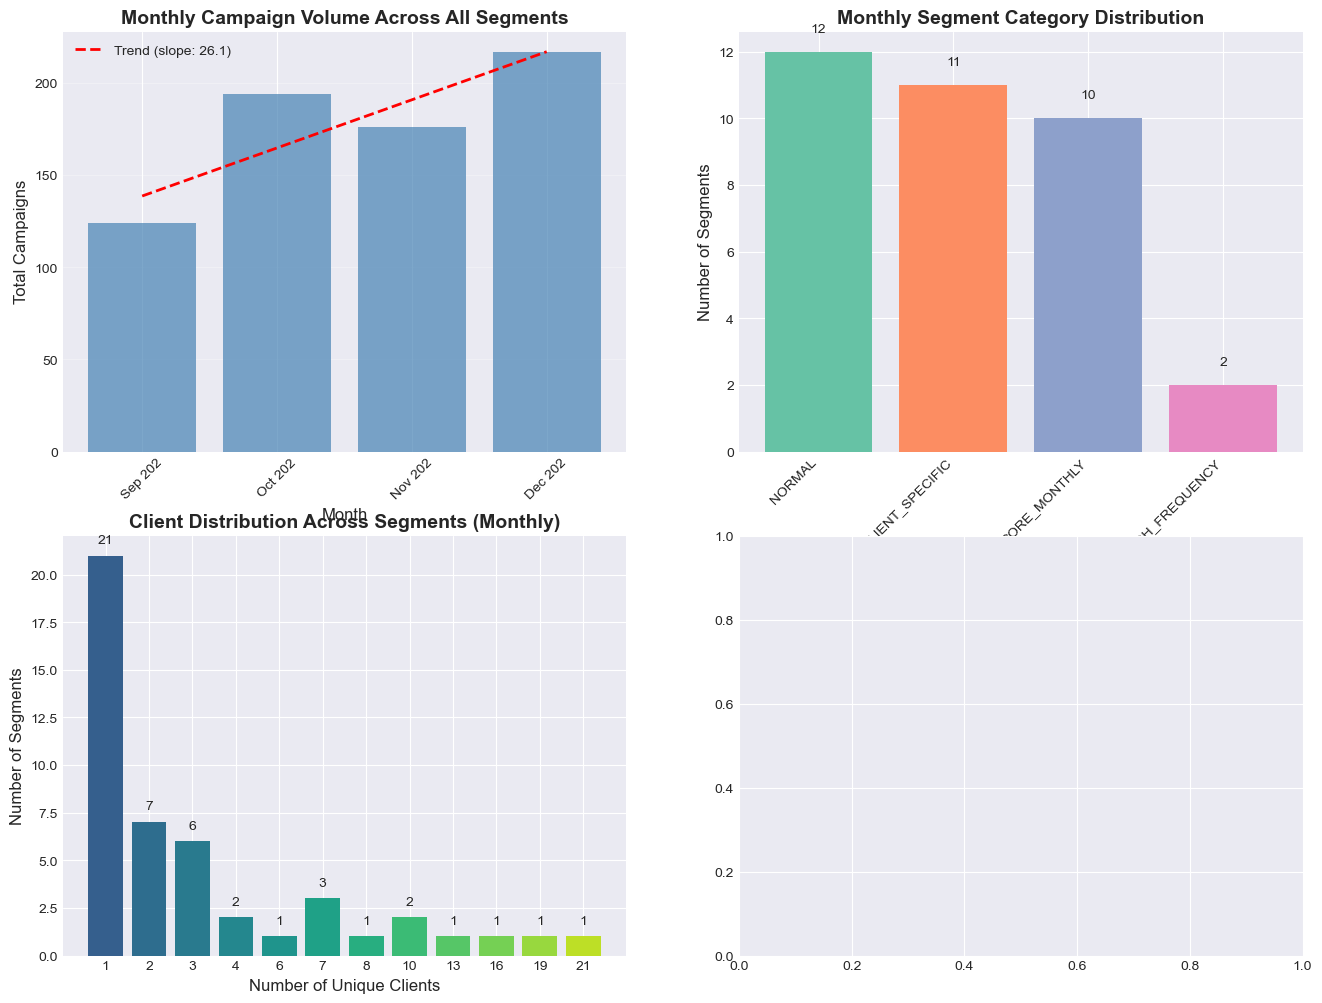

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import calendar
from collections import Counter
warnings.filterwarnings('ignore')

def analyze_monthly_segment_usage(df):
    """
    Analyzes monthly segment usage patterns including frequency, client usage, and trends.
    
    Parameters:
    df (DataFrame): DataFrame with monthly segment usage data including:
        - segment_id, segment_name, year, month, campaigns_this_month, 
          days_used_this_month, clients_this_month
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['campaigns_this_month', 'days_used_this_month']
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Create month identifier and datetime
    df_analysis['month_id'] = df_analysis['year'].astype(str) + '-' + df_analysis['month'].astype(str).str.zfill(2)
    df_analysis['month_start'] = pd.to_datetime(df_analysis['month_id'] + '-01', format='%Y-%m-%d', errors='coerce')
    df_analysis['month_name'] = df_analysis['month_start'].dt.strftime('%b %Y')
    
    # Calculate segment-level statistics
    segment_stats = df_analysis.groupby(['segment_id', 'segment_name']).agg({
        'month_start': ['min', 'max', 'nunique'],
        'campaigns_this_month': ['sum', 'mean', 'max', 'std'],
        'days_used_this_month': ['sum', 'mean'],
        'clients_this_month': lambda x: ','.join(set(','.join(x.dropna()).split(',')))
    }).reset_index()
    
    # Flatten column names
    segment_stats.columns = ['segment_id', 'segment_name', 'first_month', 'last_month', 
                           'months_active', 'total_campaigns', 'avg_campaigns_per_month',
                           'max_campaigns_month', 'std_campaigns', 'total_days_used',
                           'avg_days_per_month', 'all_clients']
    
    # Ensure first_month and last_month are datetime
    segment_stats['first_month'] = pd.to_datetime(segment_stats['first_month'], errors='coerce')
    segment_stats['last_month'] = pd.to_datetime(segment_stats['last_month'], errors='coerce')
    
    # Calculate additional metrics with safe division
    segment_stats['avg_campaigns_per_day'] = segment_stats['total_campaigns'] / segment_stats['total_days_used'].replace(0, np.nan)
    segment_stats['campaigns_per_active_month'] = segment_stats['total_campaigns'] / segment_stats['months_active']
    
    # Calculate activity rate with error handling
    def calculate_activity_rate(row):
        try:
            if pd.isna(row['first_month']) or pd.isna(row['last_month']):
                return 0
            total_months = max(1, ((row['last_month'] - row['first_month']).days / 30.44) + 1)
            return row['months_active'] / total_months
        except:
            return 0
    
    segment_stats['activity_rate'] = segment_stats.apply(calculate_activity_rate, axis=1)
    
    # Calculate unique clients
    def count_unique_clients(client_str):
        if not isinstance(client_str, str) or not client_str:
            return 0
        if pd.isna(client_str):
            return 0
        clients = [c.strip() for c in client_str.split(',') if c.strip()]
        return len(set(clients))
    
    segment_stats['unique_clients'] = segment_stats['all_clients'].apply(count_unique_clients)
    
    # Calculate client diversity
    def calculate_diversity(client_str):
        if not isinstance(client_str, str) or not client_str:
            return 0
        clients = [c.strip() for c in client_str.split(',') if c.strip()]
        if not clients:
            return 0
        unique_count = len(set(clients))
        total_count = len(clients)
        return unique_count / total_count if total_count > 0 else 0
    
    segment_stats['client_diversity'] = segment_stats['all_clients'].apply(calculate_diversity)
    
    # Calculate segment lifespan in months with error handling
    def calculate_lifespan(row):
        try:
            if pd.isna(row['first_month']) or pd.isna(row['last_month']):
                return 0
            days_diff = (row['last_month'] - row['first_month']).days
            return max(0, days_diff / 30.44)
        except:
            return 0
    
    segment_stats['lifespan_months'] = segment_stats.apply(calculate_lifespan, axis=1)
    
    # Create segment categorization
    def categorize_segment(row):
        # Skip if missing critical data
        if pd.isna(row['total_campaigns']) or pd.isna(row['months_active']):
            return 'UNKNOWN'
        
        # Calculate percentiles safely
        try:
            total_campaigns_q80 = segment_stats['total_campaigns'].quantile(0.8)
            avg_campaigns_q80 = segment_stats['avg_campaigns_per_month'].quantile(0.8)
            total_campaigns_q20 = segment_stats['total_campaigns'].quantile(0.2)
            avg_campaigns_median = segment_stats['avg_campaigns_per_month'].median()
            
            if row['total_campaigns'] >= total_campaigns_q80:
                return 'CORE_MONTHLY'
            elif row['avg_campaigns_per_month'] >= avg_campaigns_q80:
                return 'HIGH_FREQUENCY'
            elif row['months_active'] >= 2 and row['total_campaigns'] <= total_campaigns_q20:
                return 'UNDERUTILIZED'
            elif row['unique_clients'] == 1 and row['months_active'] > 1:
                return 'CLIENT_SPECIFIC'
            elif not pd.isna(row['std_campaigns']) and not pd.isna(row['avg_campaigns_per_month']) and row['avg_campaigns_per_month'] > 0:
                if row['std_campaigns'] / row['avg_campaigns_per_month'] > 1.2:
                    return 'VOLATILE'
            elif row['activity_rate'] < 0.5 and row['months_active'] >= 2:
                return 'SPORADIC'
            else:
                return 'NORMAL'
        except:
            return 'NORMAL'
    
    segment_stats['segment_category'] = segment_stats.apply(categorize_segment, axis=1)
    
    # Calculate monthly growth/trend for each segment
    monthly_data = df_analysis.pivot_table(
        index=['segment_id', 'segment_name'],
        columns='month_id',
        values='campaigns_this_month',
        aggfunc='sum',
        fill_value=0
    )
    
    # Calculate trend metrics
    trend_metrics = []
    for idx, row in monthly_data.iterrows():
        segment_id, segment_name = idx
        values = row.dropna().values
        
        if len(values) > 2:
            # Calculate slope of linear regression
            x = np.arange(len(values))
            try:
                slope = np.polyfit(x, values, 1)[0] if len(values) > 1 else 0
            except:
                slope = 0
            
            # Calculate coefficient of variation
            try:
                cv = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            except:
                cv = 0
            
            # Calculate momentum (last 2 months vs previous)
            if len(values) >= 4:
                try:
                    recent_avg = np.mean(values[-2:])
                    historical_avg = np.mean(values[:-2])
                    momentum = recent_avg / historical_avg if historical_avg > 0 else 0
                except:
                    momentum = 0
            else:
                momentum = 0
            
            # Calculate seasonality index (if enough months)
            if len(values) >= 12:
                try:
                    seasonality_index = np.std([values[i] for i in range(-3, 0)]) / np.mean([values[i] for i in range(-3, 0)]) if len(values) >= 3 else 0
                except:
                    seasonality_index = 0
            else:
                seasonality_index = 0
            
            trend_metrics.append({
                'segment_id': segment_id,
                'segment_name': segment_name,
                'usage_slope': slope,
                'volatility': cv,
                'momentum': momentum,
                'seasonality_index': seasonality_index
            })
    
    if trend_metrics:
        trend_df = pd.DataFrame(trend_metrics)
        segment_stats = segment_stats.merge(trend_df, on=['segment_id', 'segment_name'], how='left')
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Monthly Usage Overview
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Monthly Campaign Volume Over Time
    monthly_totals = df_analysis.groupby('month_name')['campaigns_this_month'].sum()
    
    # Sort months chronologically if possible
    try:
        month_order = sorted(df_analysis['month_name'].unique(), 
                            key=lambda x: datetime.strptime(x, '%b %Y'))
        monthly_totals = monthly_totals.reindex(month_order)
    except:
        # If sorting fails, use as-is
        pass
    
    if len(monthly_totals) > 0:
        ax1.bar(range(len(monthly_totals)), monthly_totals.values, color='steelblue', alpha=0.7)
        ax1.set_xticks(range(len(monthly_totals)))
        ax1.set_xticklabels([m[:7] for m in monthly_totals.index], 
                           rotation=45, fontsize=10)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('Total Campaigns', fontsize=12)
        ax1.set_title('Monthly Campaign Volume Across All Segments', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add trend line
        if len(monthly_totals) > 3:
            try:
                z = np.polyfit(range(len(monthly_totals)), monthly_totals.values, 1)
                p = np.poly1d(z)
                ax1.plot(range(len(monthly_totals)), p(range(len(monthly_totals))), "r--", linewidth=2, label=f'Trend (slope: {z[0]:.1f})')
                ax1.legend()
            except:
                pass
    
    # Plot 2: Segment Category Distribution
    category_counts = segment_stats['segment_category'].value_counts()
    if len(category_counts) > 0:
        colors2 = plt.cm.Set2(np.arange(len(category_counts)))
        bars2 = ax2.bar(range(len(category_counts)), category_counts.values, color=colors2)
        ax2.set_xticks(range(len(category_counts)))
        ax2.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
        ax2.set_ylabel('Number of Segments', fontsize=12)
        ax2.set_title('Monthly Segment Category Distribution', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Client Distribution Analysis
    client_counts = segment_stats['unique_clients'].value_counts().sort_index()
    if len(client_counts) > 0:
        colors3 = plt.cm.viridis(np.linspace(0.3, 0.9, len(client_counts)))
        bars3 = ax3.bar(range(len(client_counts)), client_counts.values, color=colors3)
        ax3.set_xticks(range(len(client_counts)))
        ax3.set_xticklabels(client_counts.index.astype(str), fontsize=10)
        ax3.set_xlabel('Number of Unique Clients', fontsize=12)
        ax3.set_ylabel('Number of Segments', fontsize=12)
        ax3.set_title('Client Distribution Across Segments (Monthly)', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars3:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Segment Lifespan vs Usage
    valid_data = segment_stats[~segment_stats['lifespan_months'].isna() & ~segment_stats['total_campaigns'].isna()]
    if len(valid_data) > 0:
        scatter4 = ax4.scatter(valid_data['lifespan_months'], valid_data['total_campaigns'],
                              s=valid_data['avg_campaigns_per_month'].fillna(0) * 10,
                              c=valid_data['segment_category'].map({
                                  'CORE_MONTHLY': 'red',
                                  'HIGH_FREQUENCY': 'orange',
                                  'UNDERUTILIZED': 'blue',
                                  'CLIENT_SPECIFIC': 'purple',
                                  'VOLATILE': 'yellow',
                                  'SPORADIC': 'gray',
                                  'NORMAL': 'green',
                                  'UNKNOWN': 'black'
                              }),
                              alpha=0.7, edgecolors='black')
        
        # Add labels for top segments
        top_segments = valid_data.nlargest(min(5, len(valid_data)), 'total_campaigns')
        for _, row in top_segments.iterrows():
            ax4.annotate(row['segment_name'][:15] + '...' if len(row['segment_name']) > 15 else row['segment_name'],
                        (row['lifespan_months'], row['total_campaigns']),
                        fontsize=9, ha='center', va='bottom')
        
        ax4.set_xlabel('Lifespan (Months)', fontsize=12)
        ax4.set_ylabel('Total Campaigns', fontsize=12)
        ax4.set_title('Segment Lifespan vs Total Usage', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', edgecolor='black', label='Core Monthly'),
            Patch(facecolor='orange', edgecolor='black', label='High Frequency'),
            Patch(facecolor='blue', edgecolor='black', label='Underutilized'),
            Patch(facecolor='purple', edgecolor='black', label='Client Specific'),
            Patch(facecolor='yellow', edgecolor='black', label='Volatile'),
            Patch(facecolor='gray', edgecolor='black', label='Sporadic'),
            Patch(facecolor='green', edgecolor='black', label='Normal')
        ]
        ax4.legend(handles=legend_elements, fontsize=8, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Continue with the rest of the plots (simplified for brevity)
    
    # Generate Comprehensive Insights
    print("="*80)
    print("MONTHLY SEGMENT USAGE ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_segments = len(segment_stats)
    total_months = df_analysis['month_id'].nunique()
    total_campaigns = segment_stats['total_campaigns'].sum()
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Total Months Analyzed: {total_months}")
    print(f"   • Total Campaigns Across All Segments: {total_campaigns:,}")
    print(f"   • Average Campaigns per Segment: {segment_stats['total_campaigns'].mean():.1f}")
    print(f"   • Average Months Active per Segment: {segment_stats['months_active'].mean():.1f}")
    
    # Segment Categories Analysis
    print(f"\n🏷️ SEGMENT CATEGORIES:")
    category_summary = segment_stats['segment_category'].value_counts()
    for category, count in category_summary.items():
        percentage = (count / total_segments) * 100
        campaigns = segment_stats[segment_stats['segment_category'] == category]['total_campaigns'].sum()
        campaign_percentage = (campaigns / total_campaigns) * 100 if total_campaigns > 0 else 0
        print(f"   • {category}: {count} segments ({percentage:.1f}%) - "
              f"{campaign_percentage:.1f}% of total campaigns")
    
    # Core Monthly Segments
    print(f"\n🏆 CORE MONTHLY SEGMENTS:")
    core_segments = segment_stats[segment_stats['segment_category'] == 'CORE_MONTHLY']
    if len(core_segments) > 0:
        print(f"   • {len(core_segments)} core monthly segments identified")
        core_usage = core_segments['total_campaigns'].sum() / total_campaigns * 100 if total_campaigns > 0 else 0
        print(f"   • These segments account for {core_usage:.1f}% of total usage")
        
        print(f"   • Top Core Monthly Segments:")
        top_core = core_segments.nlargest(min(3, len(core_segments)), 'total_campaigns')
        for i, (_, segment) in enumerate(top_core.iterrows(), 1):
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - {segment['total_campaigns']:,} total campaigns")
            print(f"        - Active {segment['months_active']} months ({segment['avg_campaigns_per_month']:.1f}/month)")
            print(f"        - Used by {segment['unique_clients']} client(s)")
    
    # High Frequency Segments
    print(f"\n⚡ HIGH FREQUENCY SEGMENTS:")
    high_freq_segments = segment_stats[segment_stats['segment_category'] == 'HIGH_FREQUENCY']
    if len(high_freq_segments) > 0:
        print(f"   • {len(high_freq_segments)} high frequency segments identified")
        print(f"   • Average campaigns per month: {high_freq_segments['avg_campaigns_per_month'].mean():.1f}")
    
    # Underutilized Segments
    print(f"\n📉 UNDERUTILIZED SEGMENTS:")
    underutilized_segments = segment_stats[segment_stats['segment_category'] == 'UNDERUTILIZED']
    if len(underutilized_segments) > 0:
        print(f"   • {len(underutilized_segments)} underutilized segments identified")
        
        # Find segments with high months_active but low usage
        high_potential = underutilized_segments[underutilized_segments['months_active'] > 2]
        if len(high_potential) > 0:
            print(f"   • {len(high_potential)} segments active >2 months but rarely used")
    
    # Client-Specific Segments
    print(f"\n👥 CLIENT-SPECIFIC SEGMENTS:")
    client_specific = segment_stats[segment_stats['segment_category'] == 'CLIENT_SPECIFIC']
    if len(client_specific) > 0:
        print(f"   • {len(client_specific)} client-specific segments identified")
    
    # Volatile Segments
    print(f"\n📊 VOLATILE SEGMENTS:")
    volatile_segments = segment_stats[segment_stats['segment_category'] == 'VOLATILE']
    if len(volatile_segments) > 0:
        print(f"   • {len(volatile_segments)} volatile segments identified")
    
    # Sporadic Segments
    print(f"\n⏰ SPORADIC SEGMENTS:")
    sporadic_segments = segment_stats[segment_stats['segment_category'] == 'SPORADIC']
    if len(sporadic_segments) > 0:
        print(f"   • {len(sporadic_segments)} sporadic segments identified")
    
    # Client Adoption Analysis
    print(f"\n👥 CLIENT ADOPTION ANALYSIS:")
    avg_clients_per_segment = segment_stats['unique_clients'].mean()
    single_client_segments = len(segment_stats[segment_stats['unique_clients'] == 1])
    
    print(f"   • Average clients per segment: {avg_clients_per_segment:.1f}")
    print(f"   • Segments used by only one client: {single_client_segments}")
    
    # Concentration Analysis
    print(f"\n🎯 CONCENTRATION ANALYSIS:")
    top_10_percent = max(1, int(total_segments * 0.1))
    top_segments_usage = segment_stats.nlargest(top_10_percent, 'total_campaigns')['total_campaigns'].sum()
    concentration_ratio = top_segments_usage / total_campaigns * 100 if total_campaigns > 0 else 0
    
    print(f"   • Top {top_10_percent} segments account for {concentration_ratio:.1f}% of all usage")
    
    # Monthly Patterns
    print(f"\n📅 MONTHLY PATTERNS:")
    if len(monthly_totals) > 0:
        avg_monthly_campaigns = monthly_totals.mean()
        print(f"   • Average campaigns per month: {avg_monthly_campaigns:.0f}")
        
        if len(monthly_totals) > 1:
            busiest_month = monthly_totals.idxmax()
            busiest_month_value = monthly_totals.max()
            quietest_month = monthly_totals.idxmin()
            quietest_month_value = monthly_totals.min()
            
            print(f"   • Busiest month: {busiest_month} ({busiest_month_value:.0f} campaigns)")
            print(f"   • Quietest month: {quietest_month} ({quietest_month_value:.0f} campaigns)")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Core segments recommendations
    if len(core_segments) > 0 and concentration_ratio > 70:
        recommendations.append(
            "• High dependency risk: Diversify monthly segment usage beyond top performers "
            "to reduce concentration risk"
        )
    
    # High frequency segments
    if len(high_freq_segments) > 0:
        high_fatigue = high_freq_segments[high_freq_segments['avg_days_per_month'] > 20]
        if len(high_fatigue) > 0:
            recommendations.append(
                f"• {len(high_fatigue)} high frequency segments used >20 days/month - "
                f"consider implementing rotation schedules"
            )
    
    # Underutilized opportunities
    if len(underutilized_segments) > 0:
        recommendations.append(
            f"• {len(underutilized_segments)} underutilized segments identified - "
            f"strategic review recommended"
        )
    
    # Client-specific segments
    if len(client_specific) > 0:
        recommendations.append(
            f"• {len(client_specific)} client-specific segments - "
            f"evaluate for potential broader application"
        )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Monthly segment usage patterns appear balanced and strategic")
        print("• Continue current approach with regular monitoring")
    
    # Priority Actions
    print(f"\n🎯 TOP PRIORITY ACTIONS:")
    
    priority_actions = []
    
    # 1. Address concentration risk
    if concentration_ratio > 70:
        priority_actions.append(
            f"  1. Reduce dependency on top segments (currently {concentration_ratio:.1f}% of monthly usage)"
        )
    
    # 2. Explore underutilized segments
    if len(underutilized_segments) > 0:
        best_potential = underutilized_segments.nlargest(1, 'unique_clients')
        if len(best_potential) > 0:
            segment = best_potential.iloc[0]
            priority_actions.append(
                f"  2. Test '{segment['segment_name'][:30]}...' "
                f"(used by {segment['unique_clients']} clients but underutilized)"
            )
    
    # Default actions if no specific issues
    if not priority_actions:
        priority_actions.append("  1. Continue monitoring monthly segment performance trends")
        if len(core_segments) > 0:
            priority_actions.append(f"  2. Optimize performance of {len(core_segments)} core monthly segments")
        priority_actions.append("  3. Regular review of client adoption patterns")
    
    for action in priority_actions[:3]:
        print(action)
    
    # Key Insights
    print(f"\n💡 KEY STRATEGIC INSIGHTS:")
    
    # Usage concentration
    if concentration_ratio > 60:
        print(f"   • High concentration risk: Business heavily dependent on few segments")
    elif concentration_ratio < 30:
        print(f"   • Diversified portfolio: Healthy distribution across many segments")
    
    # Client adoption
    if avg_clients_per_segment > 2:
        print(f"   • Good client adoption: Segments used by multiple clients")
    elif single_client_segments > total_segments * 0.5:
        print(f"   • High specialization: Many segments tailored to specific clients")
    
    print("\n" + "="*80)
    
    return segment_stats

# Usage example:
segment_stats = analyze_monthly_segment_usage(df)

# -- Which clients use each segment

In [17]:
SQL_NAME = "2_/2_5"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id                segment_name                     client  \
0          39  Added 30 days never opened  HeyPiggy (Jul25 Creative)   
1          50      Sent atleast 20 emails                 SB Digital   
2          50      Sent atleast 20 emails    Win A Million (Cascade)   

   campaigns_by_client  days_used_by_client first_used_by_client  \
0                    1                    1           2025-11-29   
1                    2                    2           2025-11-28   
2                    1                    1           2025-11-18   

  last_used_by_client  
0          2025-11-29  
1          2025-12-03  
2          2025-11-18

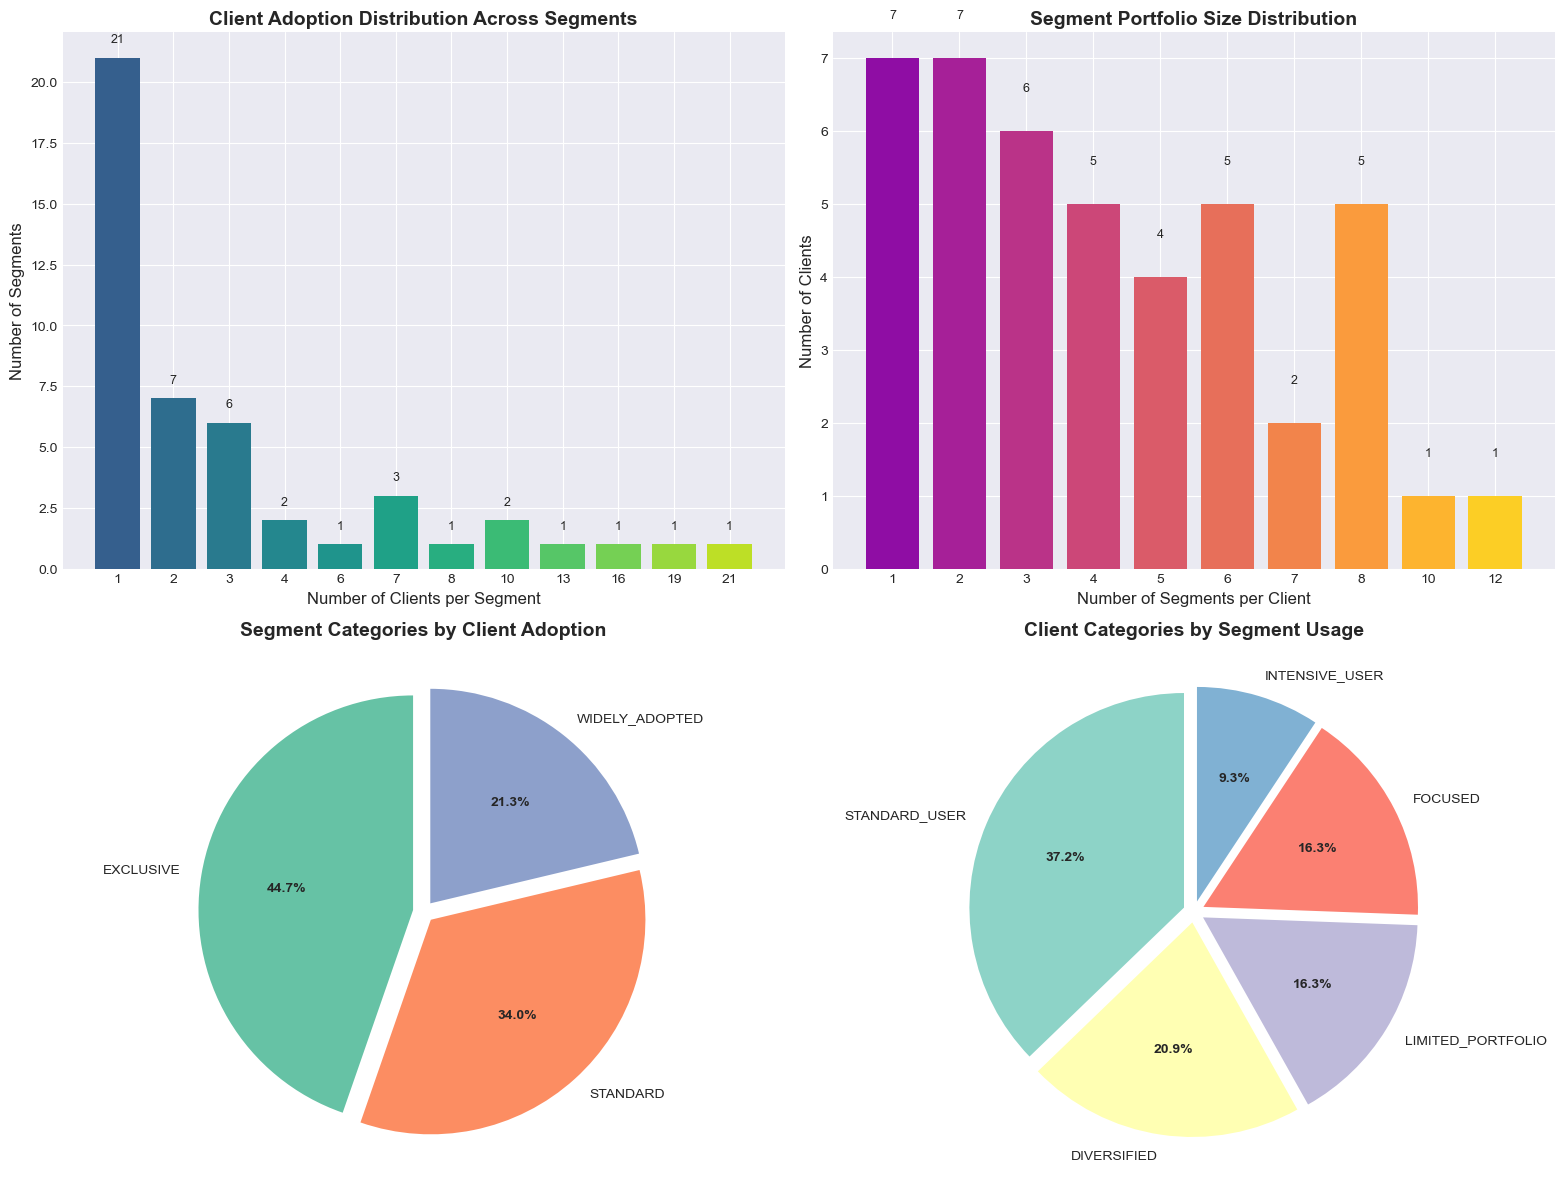

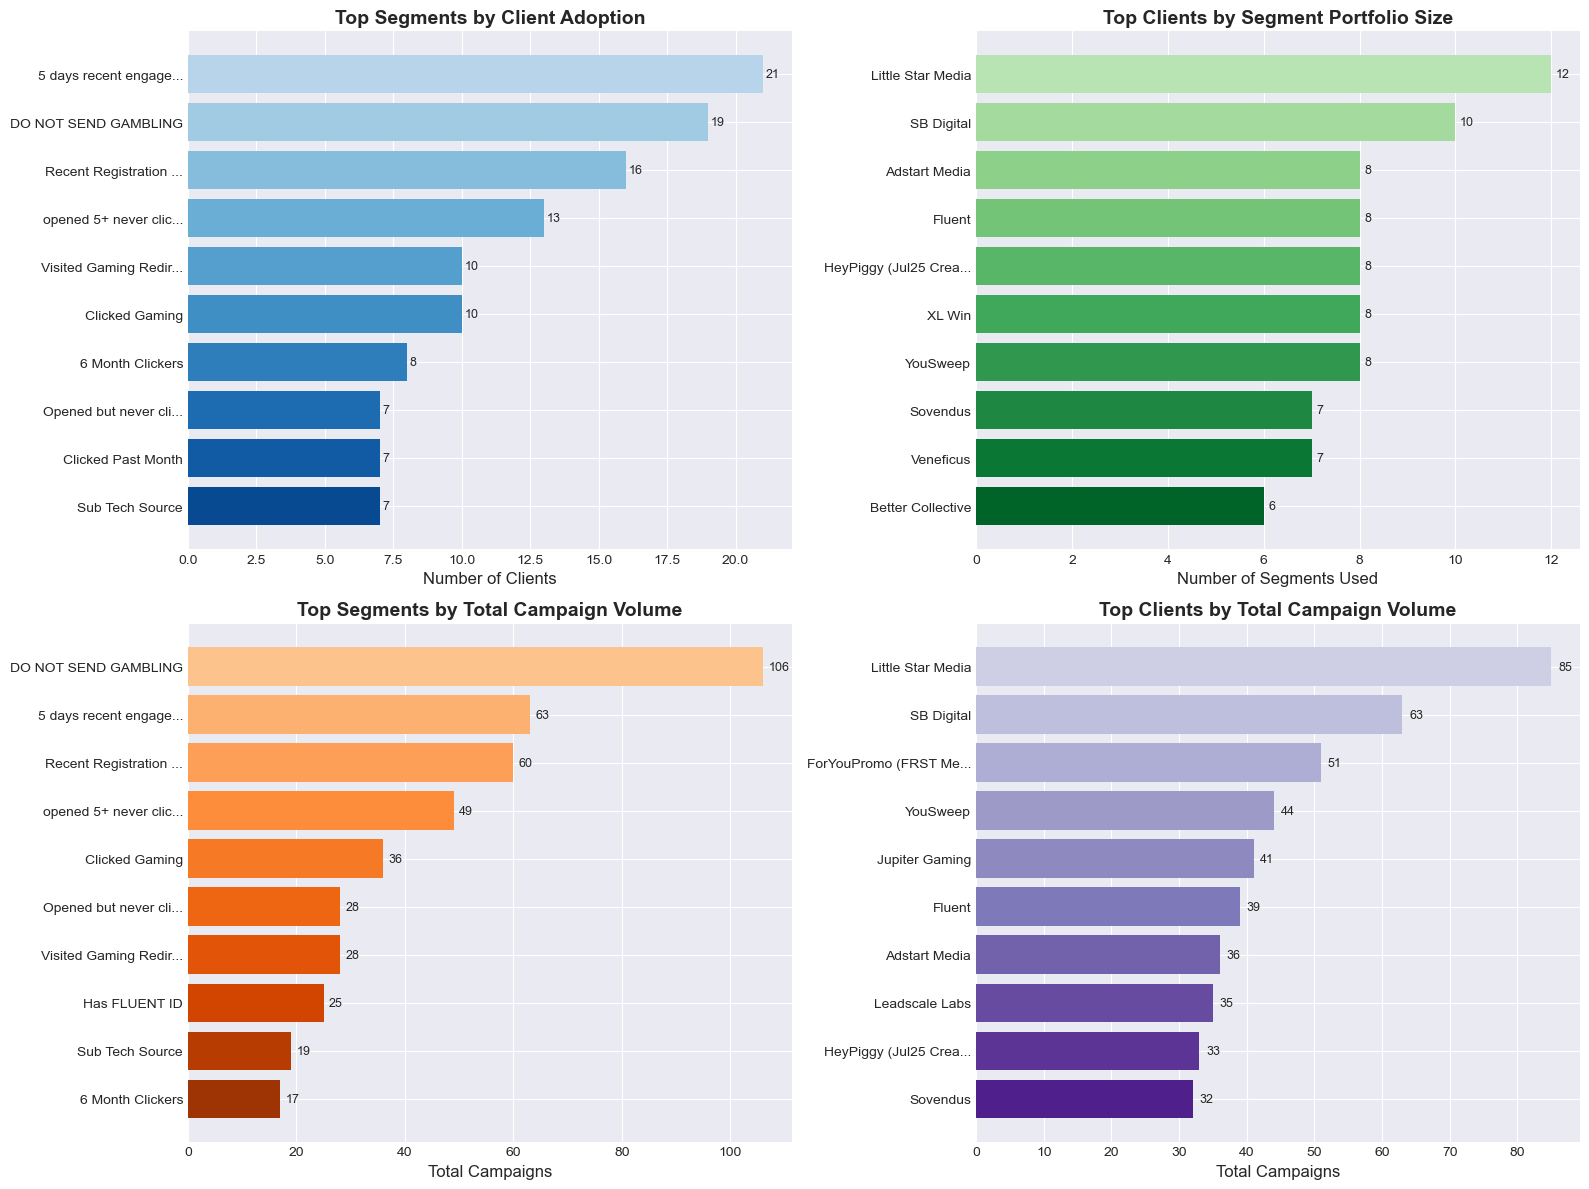

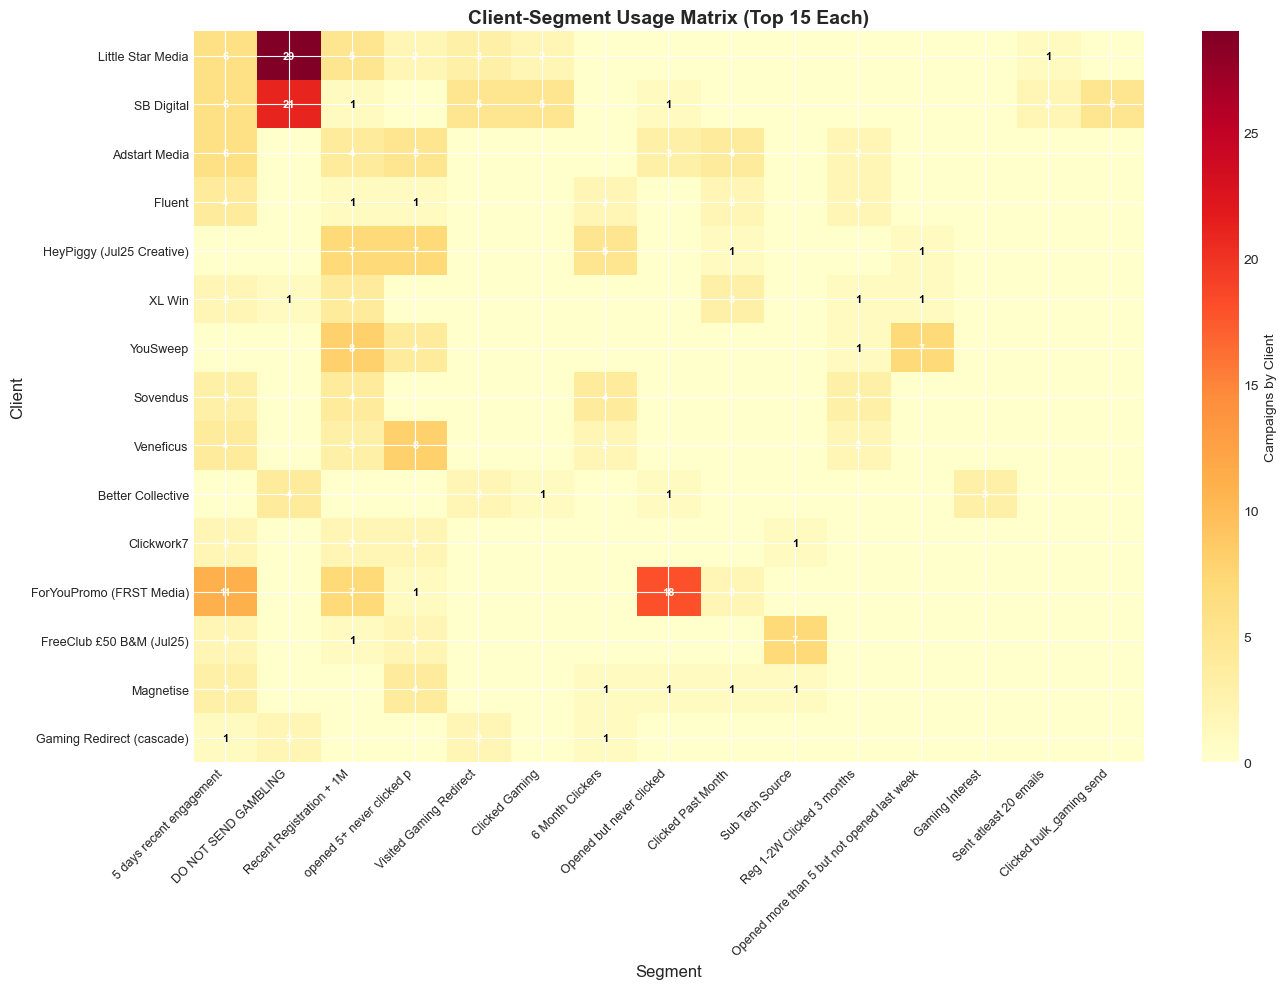

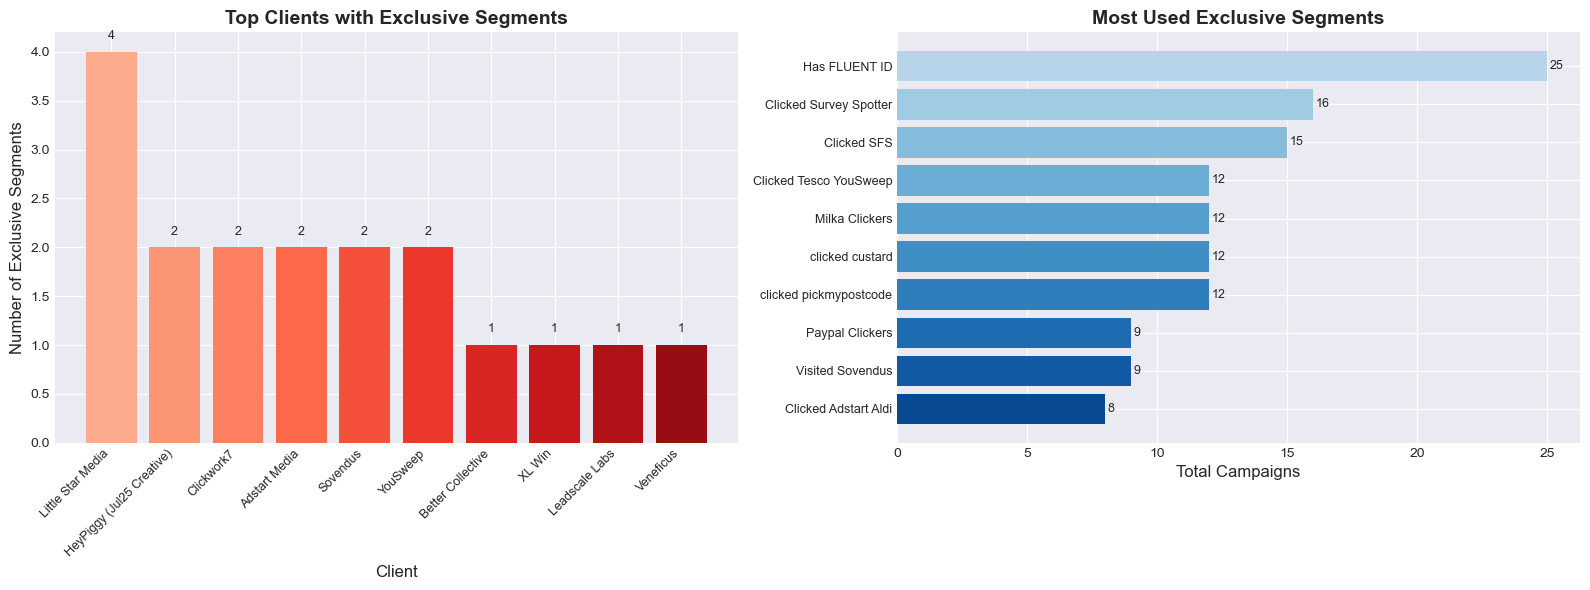

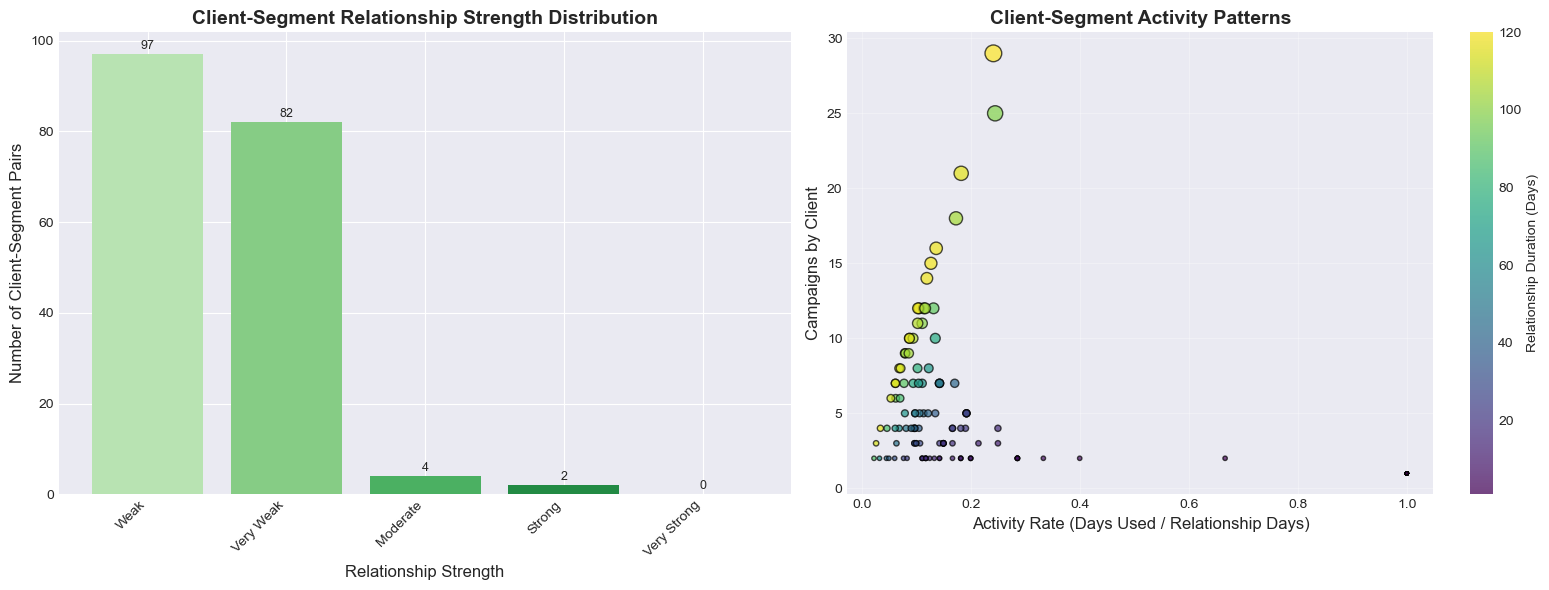

CLIENT-SEGMENT RELATIONSHIP ANALYSIS

📊 OVERVIEW METRICS:
   • Total Client-Segment Relationships: 185
   • Total Unique Clients: 43
   • Total Unique Segments: 47
   • Average Segments per Client: 4.3
   • Average Clients per Segment: 3.9

🏷️ SEGMENT CATEGORIES:
   • EXCLUSIVE: 21 segments (44.7%)
   • STANDARD: 16 segments (34.0%)
   • WIDELY_ADOPTED: 10 segments (21.3%)

🔒 EXCLUSIVE SEGMENTS:
   • 21 segments used by only one client
   • Exclusive segments account for 21.4% of all campaigns
   • Top clients with exclusive segments:
     - Little Star Media: 4 exclusive segments
     - HeyPiggy (Jul25 Creative): 2 exclusive segments
     - Clickwork7: 2 exclusive segments

🌐 WIDELY ADOPTED SEGMENTS:
   • 10 segments adopted by many clients (top 20%)
   • These segments have 11.8 clients on average
   • Most Widely Adopted Segments:
     1. 5 days recent engagement
        - Used by 21 clients
        - 63 total campaigns
     2. DO NOT SEND GAMBLING
        - Used by 19 clients
     

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import networkx as nx
from collections import Counter
warnings.filterwarnings('ignore')

def analyze_client_segment_relationships(df):
    """
    Analyzes client-segment relationships including usage intensity, exclusivity, and patterns.
    
    Parameters:
    df (DataFrame): DataFrame with client-segment usage data including:
        - segment_id, segment_name, client, campaigns_by_client, 
          days_used_by_client, first_used_by_client, last_used_by_client
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['campaigns_by_client', 'days_used_by_client']
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Ensure date columns are properly typed
    date_cols = ['first_used_by_client', 'last_used_by_client']
    for col in date_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_datetime(df_analysis[col], errors='coerce')
    
    # Calculate relationship-level metrics
    df_analysis['campaigns_per_day'] = df_analysis['campaigns_by_client'] / df_analysis['days_used_by_client'].replace(0, np.nan)
    
    # Calculate relationship duration
    df_analysis['relationship_days'] = (df_analysis['last_used_by_client'] - df_analysis['first_used_by_client']).dt.days + 1
    df_analysis['activity_rate'] = df_analysis['days_used_by_client'] / df_analysis['relationship_days'].replace(0, np.nan)
    
    # Calculate recency (days since last use)
    if df_analysis['last_used_by_client'].notna().any():
        latest_date = df_analysis['last_used_by_client'].max()
        df_analysis['days_since_last_use'] = (latest_date - df_analysis['last_used_by_client']).dt.days
    
    # Segment-level analysis (aggregate across clients)
    segment_summary = df_analysis.groupby(['segment_id', 'segment_name']).agg({
        'client': 'nunique',
        'campaigns_by_client': 'sum',
        'days_used_by_client': 'sum',
        'first_used_by_client': 'min',
        'last_used_by_client': 'max'
    }).reset_index()
    
    segment_summary.columns = ['segment_id', 'segment_name', 'unique_clients', 
                               'total_campaigns', 'total_days_used', 
                               'first_used_overall', 'last_used_overall']
    
    # Calculate segment-level metrics
    segment_summary['campaigns_per_client'] = segment_summary['total_campaigns'] / segment_summary['unique_clients']
    segment_summary['days_per_client'] = segment_summary['total_days_used'] / segment_summary['unique_clients']
    segment_summary['segment_lifespan_days'] = (segment_summary['last_used_overall'] - segment_summary['first_used_overall']).dt.days + 1
    
    # Segment categorization based on client adoption
    def categorize_segment(row):
        if row['unique_clients'] == 1:
            return 'EXCLUSIVE'
        elif row['unique_clients'] >= segment_summary['unique_clients'].quantile(0.8):
            return 'WIDELY_ADOPTED'
        elif row['unique_clients'] <= segment_summary['unique_clients'].quantile(0.2):
            return 'LIMITED_ADOPTION'
        elif row['campaigns_per_client'] >= segment_summary['campaigns_per_client'].quantile(0.8):
            return 'INTENSIVE_USE'
        else:
            return 'STANDARD'
    
    segment_summary['segment_category'] = segment_summary.apply(categorize_segment, axis=1)
    
    # Client-level analysis (aggregate across segments)
    client_summary = df_analysis.groupby('client').agg({
        'segment_id': 'nunique',
        'segment_name': lambda x: ','.join(x.unique()),
        'campaigns_by_client': 'sum',
        'days_used_by_client': 'sum',
        'first_used_by_client': 'min',
        'last_used_by_client': 'max'
    }).reset_index()
    
    client_summary.columns = ['client', 'unique_segments', 'segments_used',
                              'total_campaigns', 'total_days_used',
                              'first_segment_use', 'last_segment_use']
    
    # Calculate client-level metrics
    client_summary['campaigns_per_segment'] = client_summary['total_campaigns'] / client_summary['unique_segments']
    client_summary['days_per_segment'] = client_summary['total_days_used'] / client_summary['unique_segments']
    client_summary['client_activity_span'] = (client_summary['last_segment_use'] - client_summary['first_segment_use']).dt.days + 1
    
    # Client categorization
    def categorize_client(row):
        if row['unique_segments'] == 1:
            return 'FOCUSED'
        elif row['unique_segments'] >= client_summary['unique_segments'].quantile(0.8):
            return 'DIVERSIFIED'
        elif row['campaigns_per_segment'] >= client_summary['campaigns_per_segment'].quantile(0.8):
            return 'INTENSIVE_USER'
        elif row['unique_segments'] <= client_summary['unique_segments'].quantile(0.2):
            return 'LIMITED_PORTFOLIO'
        else:
            return 'STANDARD_USER'
    
    client_summary['client_category'] = client_summary.apply(categorize_client, axis=1)
    
    # Relationship-level analysis (client-segment pairs)
    relationship_summary = df_analysis.copy()
    relationship_summary['relationship_strength'] = (
        relationship_summary['campaigns_by_client'] / relationship_summary['campaigns_by_client'].max() * 0.4 +
        relationship_summary['days_used_by_client'] / relationship_summary['days_used_by_client'].max() * 0.3 +
        relationship_summary['activity_rate'].fillna(0) * 0.3
    )
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Client-Segment Relationship Overview
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Client Adoption Distribution
    client_dist = segment_summary['unique_clients'].value_counts().sort_index()
    if len(client_dist) > 0:
        colors1 = plt.cm.viridis(np.linspace(0.3, 0.9, len(client_dist)))
        bars1 = ax1.bar(range(len(client_dist)), client_dist.values, color=colors1)
        ax1.set_xticks(range(len(client_dist)))
        ax1.set_xticklabels(client_dist.index.astype(str), fontsize=10)
        ax1.set_xlabel('Number of Clients per Segment', fontsize=12)
        ax1.set_ylabel('Number of Segments', fontsize=12)
        ax1.set_title('Client Adoption Distribution Across Segments', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Segment Portfolio Size Distribution
    segment_dist = client_summary['unique_segments'].value_counts().sort_index()
    if len(segment_dist) > 0:
        colors2 = plt.cm.plasma(np.linspace(0.3, 0.9, len(segment_dist)))
        bars2 = ax2.bar(range(len(segment_dist)), segment_dist.values, color=colors2)
        ax2.set_xticks(range(len(segment_dist)))
        ax2.set_xticklabels(segment_dist.index.astype(str), fontsize=10)
        ax2.set_xlabel('Number of Segments per Client', fontsize=12)
        ax2.set_ylabel('Number of Clients', fontsize=12)
        ax2.set_title('Segment Portfolio Size Distribution', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Segment Categories Distribution
    segment_cats = segment_summary['segment_category'].value_counts()
    if len(segment_cats) > 0:
        colors3 = plt.cm.Set2(np.arange(len(segment_cats)))
        wedges3, texts3, autotexts3 = ax3.pie(segment_cats.values, labels=segment_cats.index,
                                             autopct='%1.1f%%', colors=colors3,
                                             startangle=90, explode=[0.05]*len(segment_cats))
        ax3.set_title('Segment Categories by Client Adoption', fontsize=14, fontweight='bold')
        
        for autotext in autotexts3:
            autotext.set_fontweight('bold')
    
    # Plot 4: Client Categories Distribution
    client_cats = client_summary['client_category'].value_counts()
    if len(client_cats) > 0:
        colors4 = plt.cm.Set3(np.arange(len(client_cats)))
        wedges4, texts4, autotexts4 = ax4.pie(client_cats.values, labels=client_cats.index,
                                             autopct='%1.1f%%', colors=colors4,
                                             startangle=90, explode=[0.05]*len(client_cats))
        ax4.set_title('Client Categories by Segment Usage', fontsize=14, fontweight='bold')
        
        for autotext in autotexts4:
            autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Top Clients and Segments Analysis
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 5: Top Segments by Client Count
    top_segments_by_clients = segment_summary.nlargest(10, 'unique_clients')
    if len(top_segments_by_clients) > 0:
        y_pos5 = np.arange(len(top_segments_by_clients))
        colors5 = plt.cm.Blues(np.linspace(0.3, 0.9, len(top_segments_by_clients)))
        bars5 = ax5.barh(y_pos5, top_segments_by_clients['unique_clients'], color=colors5)
        ax5.set_yticks(y_pos5)
        ax5.set_yticklabels(top_segments_by_clients['segment_name'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x))
        ax5.invert_yaxis()
        ax5.set_xlabel('Number of Clients', fontsize=12)
        ax5.set_title('Top Segments by Client Adoption', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar, val in zip(bars5, top_segments_by_clients['unique_clients']):
            ax5.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{int(val)}', va='center', fontsize=9)
    
    # Plot 6: Top Clients by Segment Count
    top_clients_by_segments = client_summary.nlargest(10, 'unique_segments')
    if len(top_clients_by_segments) > 0:
        y_pos6 = np.arange(len(top_clients_by_segments))
        colors6 = plt.cm.Greens(np.linspace(0.3, 0.9, len(top_clients_by_segments)))
        bars6 = ax6.barh(y_pos6, top_clients_by_segments['unique_segments'], color=colors6)
        ax6.set_yticks(y_pos6)
        ax6.set_yticklabels(top_clients_by_segments['client'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x))
        ax6.invert_yaxis()
        ax6.set_xlabel('Number of Segments Used', fontsize=12)
        ax6.set_title('Top Clients by Segment Portfolio Size', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar, val in zip(bars6, top_clients_by_segments['unique_segments']):
            ax6.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                    f'{int(val)}', va='center', fontsize=9)
    
    # Plot 7: Top Segments by Total Campaigns
    top_segments_by_campaigns = segment_summary.nlargest(10, 'total_campaigns')
    if len(top_segments_by_campaigns) > 0:
        y_pos7 = np.arange(len(top_segments_by_campaigns))
        colors7 = plt.cm.Oranges(np.linspace(0.3, 0.9, len(top_segments_by_campaigns)))
        bars7 = ax7.barh(y_pos7, top_segments_by_campaigns['total_campaigns'], color=colors7)
        ax7.set_yticks(y_pos7)
        ax7.set_yticklabels(top_segments_by_campaigns['segment_name'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x))
        ax7.invert_yaxis()
        ax7.set_xlabel('Total Campaigns', fontsize=12)
        ax7.set_title('Top Segments by Total Campaign Volume', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar, val in zip(bars7, top_segments_by_campaigns['total_campaigns']):
            ax7.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{int(val)}', va='center', fontsize=9)
    
    # Plot 8: Top Clients by Total Campaigns
    top_clients_by_campaigns = client_summary.nlargest(10, 'total_campaigns')
    if len(top_clients_by_campaigns) > 0:
        y_pos8 = np.arange(len(top_clients_by_campaigns))
        colors8 = plt.cm.Purples(np.linspace(0.3, 0.9, len(top_clients_by_campaigns)))
        bars8 = ax8.barh(y_pos8, top_clients_by_campaigns['total_campaigns'], color=colors8)
        ax8.set_yticks(y_pos8)
        ax8.set_yticklabels(top_clients_by_campaigns['client'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x))
        ax8.invert_yaxis()
        ax8.set_xlabel('Total Campaigns', fontsize=12)
        ax8.set_title('Top Clients by Total Campaign Volume', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar, val in zip(bars8, top_clients_by_campaigns['total_campaigns']):
            ax8.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{int(val)}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Client-Segment Relationship Matrix
    # Create pivot table for heatmap (top clients vs top segments)
    top_clients = client_summary.nlargest(15, 'unique_segments')['client'].tolist()
    top_segments = segment_summary.nlargest(15, 'unique_clients')['segment_name'].tolist()
    
    # Filter data for heatmap
    heatmap_data = df_analysis[
        df_analysis['client'].isin(top_clients) & 
        df_analysis['segment_name'].isin(top_segments)
    ]
    
    if not heatmap_data.empty and len(top_clients) > 1 and len(top_segments) > 1:
        fig3, ax9 = plt.subplots(figsize=(14, 10))
        
        # Create pivot table
        pivot_table = heatmap_data.pivot_table(
            index='client',
            columns='segment_name',
            values='campaigns_by_client',
            aggfunc='sum',
            fill_value=0
        )
        
        # Reindex to ensure order
        pivot_table = pivot_table.reindex(index=top_clients, columns=top_segments, fill_value=0)
        
        # Create heatmap
        im9 = ax9.imshow(pivot_table.values, aspect='auto', cmap='YlOrRd')
        ax9.set_xticks(range(len(pivot_table.columns)))
        ax9.set_yticks(range(len(pivot_table.index)))
        ax9.set_xticklabels(pivot_table.columns, rotation=45, ha='right', fontsize=9)
        ax9.set_yticklabels(pivot_table.index, fontsize=9)
        ax9.set_xlabel('Segment', fontsize=12)
        ax9.set_ylabel('Client', fontsize=12)
        ax9.set_title('Client-Segment Usage Matrix (Top 15 Each)', fontsize=14, fontweight='bold')
        
        # Add colorbar
        cbar9 = fig3.colorbar(im9, ax=ax9)
        cbar9.set_label('Campaigns by Client', fontsize=10)
        
        # Add text annotations for non-zero values
        for i in range(len(pivot_table.index)):
            for j in range(len(pivot_table.columns)):
                value = pivot_table.iloc[i, j]
                if value > 0:
                    text_color = 'white' if value > pivot_table.values.mean() else 'black'
                    ax9.text(j, i, f'{int(value)}', ha='center', va='center',
                            color=text_color, fontsize=8, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Network Analysis of Client-Segment Relationships
    if len(df_analysis) <= 100:  # Only create network if not too large
        fig4, ax10 = plt.subplots(figsize=(14, 10))
        
        # Create bipartite graph
        G = nx.Graph()
        
        # Add nodes with attributes
        for _, row in df_analysis.iterrows():
            # Add client node
            G.add_node(row['client'], bipartite=0, type='client')
            # Add segment node
            G.add_node(row['segment_name'], bipartite=1, type='segment')
            # Add edge with weight based on campaigns
            weight = min(row['campaigns_by_client'] / 5, 5)  # Normalize weight
            G.add_edge(row['client'], row['segment_name'], weight=weight, 
                      campaigns=row['campaigns_by_client'])
        
        # Separate nodes by bipartite sets
        clients = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
        segments = set(G) - clients
        
        # Position nodes
        pos = nx.bipartite_layout(G, clients)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, nodelist=clients, node_color='lightblue',
                              node_size=500, alpha=0.8, ax=ax10, label='Clients')
        nx.draw_networkx_nodes(G, pos, nodelist=segments, node_color='lightgreen',
                              node_size=300, alpha=0.8, ax=ax10, label='Segments')
        
        # Draw edges with varying widths
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights,
                              alpha=0.5, edge_color='gray', ax=ax10)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax10)
        
        ax10.set_title('Client-Segment Relationship Network', fontsize=14, fontweight='bold')
        ax10.axis('off')
        ax10.legend(scatterpoints=1)
        
        plt.tight_layout()
        plt.show()
    
    # 5. Exclusive Segments Analysis
    exclusive_segments = segment_summary[segment_summary['unique_clients'] == 1]
    
    if len(exclusive_segments) > 0:
        fig5, (ax11, ax12) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 11: Exclusive Segments by Client
        exclusive_by_client = df_analysis[df_analysis['segment_id'].isin(exclusive_segments['segment_id'])]
        client_exclusive_counts = exclusive_by_client['client'].value_counts().head(10)
        
        if len(client_exclusive_counts) > 0:
            colors11 = plt.cm.Reds(np.linspace(0.3, 0.9, len(client_exclusive_counts)))
            bars11 = ax11.bar(range(len(client_exclusive_counts)), client_exclusive_counts.values, color=colors11)
            ax11.set_xticks(range(len(client_exclusive_counts)))
            ax11.set_xticklabels(client_exclusive_counts.index, rotation=45, ha='right', fontsize=9)
            ax11.set_xlabel('Client', fontsize=12)
            ax11.set_ylabel('Number of Exclusive Segments', fontsize=12)
            ax11.set_title('Top Clients with Exclusive Segments', fontsize=14, fontweight='bold')
            
            # Add value labels
            for bar in bars11:
                height = bar.get_height()
                ax11.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                         f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        # Plot 12: Exclusive Segments Usage Intensity
        exclusive_usage = exclusive_by_client.groupby('segment_name')['campaigns_by_client'].sum().nlargest(10)
        
        if len(exclusive_usage) > 0:
            colors12 = plt.cm.Blues(np.linspace(0.3, 0.9, len(exclusive_usage)))
            bars12 = ax12.barh(range(len(exclusive_usage)), exclusive_usage.values, color=colors12)
            ax12.set_yticks(range(len(exclusive_usage)))
            ax12.set_yticklabels(exclusive_usage.index, fontsize=9)
            ax12.invert_yaxis()
            ax12.set_xlabel('Total Campaigns', fontsize=12)
            ax12.set_title('Most Used Exclusive Segments', fontsize=14, fontweight='bold')
            
            # Add value labels
            for bar, val in zip(bars12, exclusive_usage.values):
                ax12.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                         f'{int(val)}', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    # 6. Relationship Strength Analysis
    fig6, (ax13, ax14) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 13: Relationship Strength Distribution
    if 'relationship_strength' in relationship_summary.columns:
        strength_counts = pd.cut(relationship_summary['relationship_strength'], 
                                bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                labels=['Very Weak', 'Weak', 'Moderate', 'Strong', 'Very Strong']).value_counts()
        
        colors13 = plt.cm.Greens(np.linspace(0.3, 0.9, len(strength_counts)))
        bars13 = ax13.bar(range(len(strength_counts)), strength_counts.values, color=colors13)
        ax13.set_xticks(range(len(strength_counts)))
        ax13.set_xticklabels(strength_counts.index, rotation=45, ha='right', fontsize=10)
        ax13.set_xlabel('Relationship Strength', fontsize=12)
        ax13.set_ylabel('Number of Client-Segment Pairs', fontsize=12)
        ax13.set_title('Client-Segment Relationship Strength Distribution', fontsize=14, fontweight='bold')
        
        # Add value labels
        for bar in bars13:
            height = bar.get_height()
            ax13.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                     f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    # Plot 14: Activity Rate vs Campaigns
    scatter14 = ax14.scatter(relationship_summary['activity_rate'], 
                            relationship_summary['campaigns_by_client'],
                            s=relationship_summary['days_used_by_client'] * 5,
                            c=relationship_summary['relationship_days'],
                            cmap='viridis', alpha=0.7, edgecolors='black')
    
    ax14.set_xlabel('Activity Rate (Days Used / Relationship Days)', fontsize=12)
    ax14.set_ylabel('Campaigns by Client', fontsize=12)
    ax14.set_title('Client-Segment Activity Patterns', fontsize=14, fontweight='bold')
    ax14.grid(True, alpha=0.3)
    
    cbar14 = fig6.colorbar(scatter14, ax=ax14)
    cbar14.set_label('Relationship Duration (Days)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("CLIENT-SEGMENT RELATIONSHIP ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_relationships = len(df_analysis)
    total_clients = len(client_summary)
    total_segments = len(segment_summary)
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Client-Segment Relationships: {total_relationships}")
    print(f"   • Total Unique Clients: {total_clients}")
    print(f"   • Total Unique Segments: {total_segments}")
    print(f"   • Average Segments per Client: {client_summary['unique_segments'].mean():.1f}")
    print(f"   • Average Clients per Segment: {segment_summary['unique_clients'].mean():.1f}")
    
    # Segment Categories Analysis
    print(f"\n🏷️ SEGMENT CATEGORIES:")
    segment_cat_summary = segment_summary['segment_category'].value_counts()
    for category, count in segment_cat_summary.items():
        percentage = (count / total_segments) * 100
        print(f"   • {category}: {count} segments ({percentage:.1f}%)")
    
    # Exclusive Segments Analysis
    print(f"\n🔒 EXCLUSIVE SEGMENTS:")
    print(f"   • {len(exclusive_segments)} segments used by only one client")
    if len(exclusive_segments) > 0:
        exclusive_campaigns = exclusive_segments['total_campaigns'].sum()
        total_all_campaigns = segment_summary['total_campaigns'].sum()
        exclusive_percentage = (exclusive_campaigns / total_all_campaigns * 100) if total_all_campaigns > 0 else 0
        print(f"   • Exclusive segments account for {exclusive_percentage:.1f}% of all campaigns")
        
        # Top clients with exclusive segments
        if len(exclusive_by_client) > 0:
            top_exclusive_clients = exclusive_by_client['client'].value_counts().head(3)
            print(f"   • Top clients with exclusive segments:")
            for client, count in top_exclusive_clients.items():
                print(f"     - {client}: {count} exclusive segments")
    
    # Widely Adopted Segments
    print(f"\n🌐 WIDELY ADOPTED SEGMENTS:")
    widely_adopted = segment_summary[segment_summary['segment_category'] == 'WIDELY_ADOPTED']
    if len(widely_adopted) > 0:
        print(f"   • {len(widely_adopted)} segments adopted by many clients (top 20%)")
        print(f"   • These segments have {widely_adopted['unique_clients'].mean():.1f} clients on average")
        
        print(f"   • Most Widely Adopted Segments:")
        top_widely = widely_adopted.nlargest(3, 'unique_clients')
        for i, (_, segment) in enumerate(top_widely.iterrows(), 1):
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - Used by {segment['unique_clients']} clients")
            print(f"        - {segment['total_campaigns']} total campaigns")
    
    # Client Categories Analysis
    print(f"\n👥 CLIENT CATEGORIES:")
    client_cat_summary = client_summary['client_category'].value_counts()
    for category, count in client_cat_summary.items():
        percentage = (count / total_clients) * 100
        print(f"   • {category}: {count} clients ({percentage:.1f}%)")
    
    # Diversified Clients Analysis
    print(f"\n🔄 DIVERSIFIED CLIENTS:")
    diversified_clients = client_summary[client_summary['client_category'] == 'DIVERSIFIED']
    if len(diversified_clients) > 0:
        print(f"   • {len(diversified_clients)} clients use many segments (top 20%)")
        print(f"   • These clients use {diversified_clients['unique_segments'].mean():.1f} segments on average")
        
        print(f"   • Most Diversified Clients:")
        top_diversified = diversified_clients.nlargest(3, 'unique_segments')
        for i, (_, client) in enumerate(top_diversified.iterrows(), 1):
            print(f"     {i}. {client['client']}")
            print(f"        - Uses {client['unique_segments']} segments")
            print(f"        - {client['total_campaigns']} total campaigns")
    
    # Focused Clients Analysis
    print(f"\n🎯 FOCUSED CLIENTS:")
    focused_clients = client_summary[client_summary['client_category'] == 'FOCUSED']
    if len(focused_clients) > 0:
        print(f"   • {len(focused_clients)} clients use only one segment")
        
        # What segments do they use?
        focused_relationships = df_analysis[df_analysis['client'].isin(focused_clients['client'])]
        if len(focused_relationships) > 0:
            top_focused_segments = focused_relationships['segment_name'].value_counts().head(3)
            print(f"   • Most common segments for focused clients:")
            for segment, count in top_focused_segments.items():
                print(f"     - {segment}: {count} focused clients")
    
    # Relationship Strength Analysis
    print(f"\n💪 RELATIONSHIP STRENGTH:")
    if 'relationship_strength' in relationship_summary.columns:
        avg_strength = relationship_summary['relationship_strength'].mean()
        strong_relationships = len(relationship_summary[relationship_summary['relationship_strength'] > 0.7])
        strong_percentage = (strong_relationships / total_relationships) * 100
        
        print(f"   • Average relationship strength: {avg_strength:.2f}/1.0")
        print(f"   • {strong_relationships} strong relationships (>0.7): {strong_percentage:.1f}%")
        
        # Identify strongest relationships
        strongest_relationships = relationship_summary.nlargest(3, 'relationship_strength')
        if len(strongest_relationships) > 0:
            print(f"   • Strongest Client-Segment Relationships:")
            for i, (_, rel) in enumerate(strongest_relationships.iterrows(), 1):
                print(f"     {i}. {rel['client']} - {rel['segment_name']}")
                print(f"        - Strength: {rel['relationship_strength']:.2f}")
                print(f"        - Campaigns: {rel['campaigns_by_client']}")
                print(f"        - Days used: {rel['days_used_by_client']}")
    
    # Activity Patterns
    print(f"\n📈 ACTIVITY PATTERNS:")
    avg_activity_rate = relationship_summary['activity_rate'].mean()
    highly_active = len(relationship_summary[relationship_summary['activity_rate'] > 0.8])
    highly_active_percentage = (highly_active / total_relationships) * 100
    
    print(f"   • Average activity rate: {avg_activity_rate:.1%}")
    print(f"   • {highly_active} highly active relationships (>80%): {highly_active_percentage:.1f}%")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Exclusive segments recommendations
    if len(exclusive_segments) > 0:
        exclusive_percentage = (len(exclusive_segments) / total_segments) * 100
        if exclusive_percentage > 30:
            recommendations.append(
                f"• High exclusivity: {exclusive_percentage:.1f}% of segments are client-specific - "
                f"consider if any can be shared with other clients"
            )
        
        # Identify underutilized exclusive segments
        underutilized_exclusive = exclusive_segments[exclusive_segments['total_campaigns'] < 5]
        if len(underutilized_exclusive) > 0:
            recommendations.append(
                f"• {len(underutilized_exclusive)} exclusive segments have <5 campaigns - "
                f"review for potential retirement or broader application"
            )
    
    # Widely adopted segments opportunities
    if len(widely_adopted) > 0:
        # Check if any clients are missing these popular segments
        all_clients = set(client_summary['client'])
        for _, segment in widely_adopted.nlargest(3, 'unique_clients').iterrows():
            segment_users = set(df_analysis[df_analysis['segment_id'] == segment['segment_id']]['client'])
            missing_clients = all_clients - segment_users
            if len(missing_clients) > 0 and len(missing_clients) < 5:  # Small number to target
                recommendations.append(
                    f"• Consider introducing '{segment['segment_name'][:30]}...' to {len(missing_clients)} clients "
                    f"missing this widely adopted segment"
                )
    
    # Diversified clients opportunities
    if len(diversified_clients) > 0:
        # Analyze which segments diversified clients use that others don't
        diversified_segments = set()
        for _, client in diversified_clients.iterrows():
            client_segments = set(df_analysis[df_analysis['client'] == client['client']]['segment_name'])
            diversified_segments.update(client_segments)
        
        # Compare with focused clients
        if len(focused_clients) > 0:
            recommendations.append(
                f"• {len(diversified_clients)} diversified clients use advanced segment strategies - "
                f"share best practices with focused clients"
            )
    
    # Relationship strength optimization
    if 'relationship_strength' in relationship_summary.columns:
        weak_relationships = relationship_summary[relationship_summary['relationship_strength'] < 0.3]
        if len(weak_relationships) > total_relationships * 0.2:
            recommendations.append(
                f"• {len(weak_relationships)} weak relationships identified - "
                f"review for optimization or discontinuation"
            )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Client-segment relationships appear balanced and strategic")
        print("• Continue current approach with regular relationship monitoring")
    
    # Priority Actions
    print(f"\n🎯 PRIORITY ACTIONS:")
    
    priority_actions = []
    
    # 1. Address high exclusivity if applicable
    if len(exclusive_segments) > 0:
        exclusive_percentage = (len(exclusive_segments) / total_segments) * 100
        if exclusive_percentage > 40:
            priority_actions.append(
                f"  1. Reduce segment exclusivity (currently {exclusive_percentage:.1f}% of segments "
                f"are client-specific)"
            )
    
    # 2. Strengthen weak relationships
    if 'relationship_strength' in relationship_summary.columns:
        weak_relationships = relationship_summary[relationship_summary['relationship_strength'] < 0.2]
        if len(weak_relationships) > 0:
            weakest = weak_relationships.nsmallest(1, 'relationship_strength').iloc[0]
            priority_actions.append(
                f"  2. Strengthen weakest relationship: {weakest['client']} - "
                f"{weakest['segment_name'][:30]}... (strength: {weakest['relationship_strength']:.2f})"
            )
    
    # 3. Leverage widely adopted segments
    if len(widely_adopted) > 0:
        most_widely = widely_adopted.nlargest(1, 'unique_clients').iloc[0]
        missing_clients = total_clients - most_widely['unique_clients']
        if missing_clients > 0:
            priority_actions.append(
                f"  3. Expand adoption of '{most_widely['segment_name'][:30]}...' "
                f"(used by {most_widely['unique_clients']}/{total_clients} clients)"
            )
    
    # Default actions if no specific issues
    if not priority_actions:
        priority_actions.append("  1. Monitor client-segment relationship trends")
        priority_actions.append("  2. Regularly review exclusive segments for sharing opportunities")
        if len(diversified_clients) > 0:
            priority_actions.append(f"  3. Learn from {len(diversified_clients)} diversified clients")
    
    for action in priority_actions[:3]:
        print(action)
    
    # Key Insights
    print(f"\n💡 KEY RELATIONSHIP INSIGHTS:")
    
    # Exclusivity insight
    if len(exclusive_segments) > total_segments * 0.5:
        print(f"   • High customization: Majority of segments tailored to specific clients")
    elif len(exclusive_segments) < total_segments * 0.1:
        print(f"   • High sharing: Most segments used across multiple clients")
    
    # Adoption patterns
    avg_clients_per_segment = segment_summary['unique_clients'].mean()
    if avg_clients_per_segment > 3:
        print(f"   • Broad adoption: Segments typically used by multiple clients")
    elif avg_clients_per_segment < 1.5:
        print(f"   • Niche usage: Segments mostly used by 1-2 clients")
    
    # Client behavior
    avg_segments_per_client = client_summary['unique_segments'].mean()
    if avg_segments_per_client > 5:
        print(f"   • Sophisticated clients: Extensive segment usage across client base")
    elif avg_segments_per_client < 2:
        print(f"   • Simple strategies: Clients use few segments")
    
    # Relationship quality
    if 'relationship_strength' in relationship_summary.columns:
        avg_strength = relationship_summary['relationship_strength'].mean()
        if avg_strength > 0.6:
            print(f"   • Strong relationships: High engagement with used segments")
        elif avg_strength < 0.3:
            print(f"   • Weak relationships: Low engagement with used segments")
    
    print("\n" + "="*80)
    
    # Return summary dataframes for further analysis
    return {
        'segment_summary': segment_summary,
        'client_summary': client_summary,
        'relationship_summary': relationship_summary,
        'exclusive_segments': exclusive_segments if 'exclusive_segments' in locals() else pd.DataFrame()
    }

# Usage example:
results = analyze_client_segment_relationships(df)

# -- Check if segments are used alone or with others

In [19]:
SQL_NAME = "2_/2_6"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name  total_campaigns  campaigns_alone  \
0          94      DO NOT SEND GAMBLING              106                1   
1         150  5 days recent engagement               63                2   
2          97  Recent Registration + 1M               60                0   

   campaigns_combined percent_used_alone  
0                 105               0.94  
1                  61               3.17  
2                  60               0.00

ValueError: Bin edges must be unique: array([ 0.,  0.,  0.,  0., 25.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

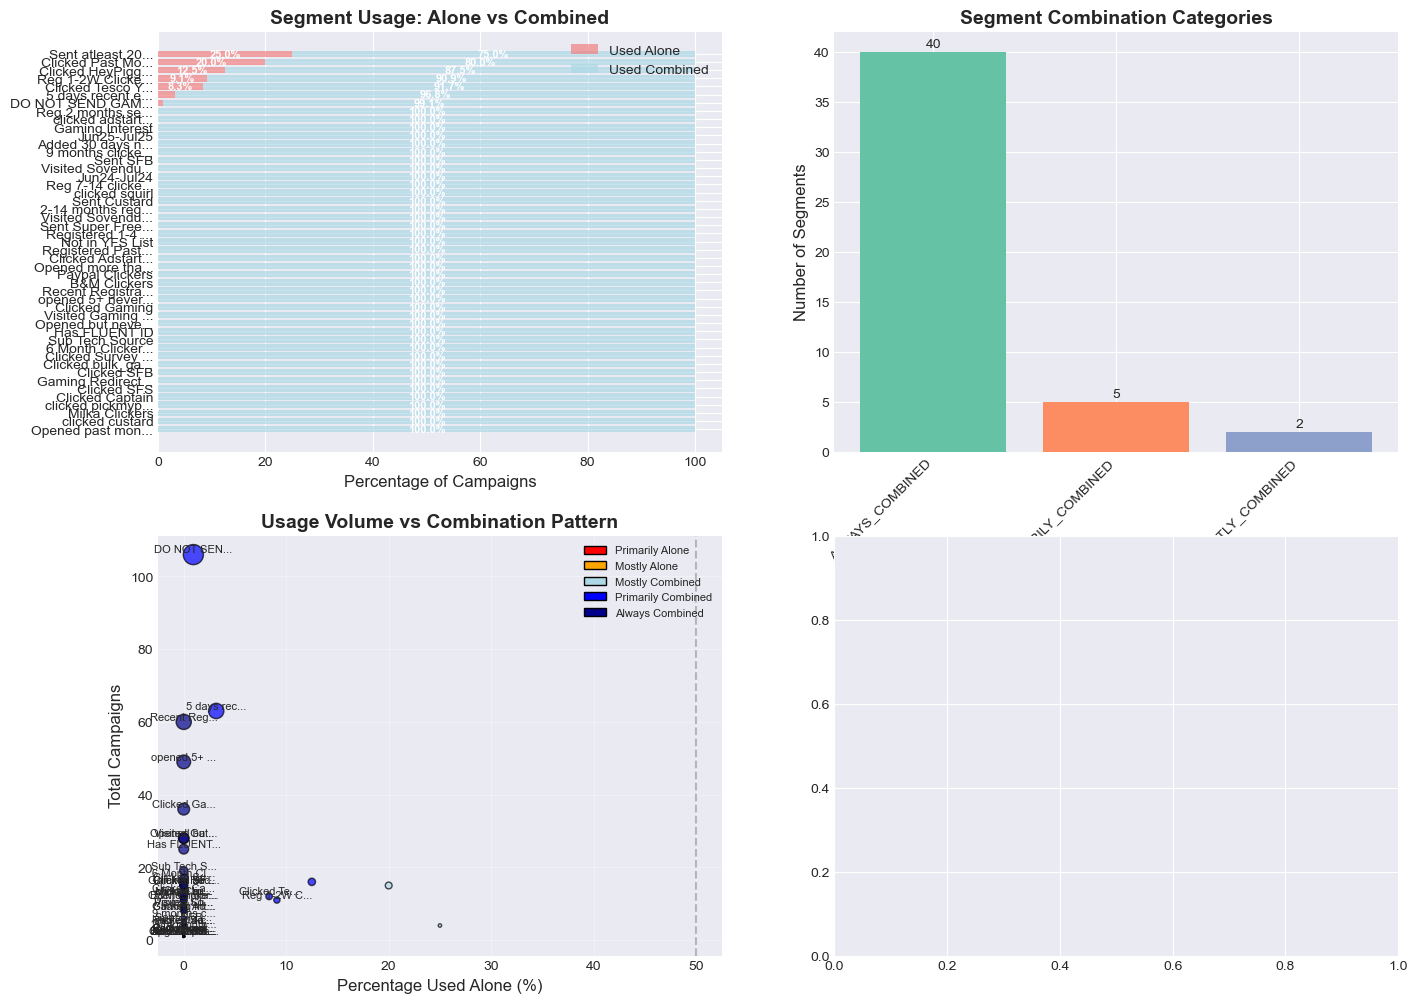

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import textwrap
warnings.filterwarnings('ignore')

def analyze_segment_combination_patterns(df):
    """
    Analyzes segment combination patterns including alone vs combined usage.
    
    Parameters:
    df (DataFrame): DataFrame with segment combination data including:
        - segment_id, segment_name, total_campaigns, campaigns_alone,
          campaigns_combined, percent_used_alone
    
    Returns:
    DataFrame: Enriched dataframe with calculated metrics
    """
    
    # Create a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['total_campaigns', 'campaigns_alone', 'campaigns_combined', 'percent_used_alone']
    for col in numeric_cols:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Calculate additional metrics
    df_analysis['percent_used_combined'] = 100 - df_analysis['percent_used_alone']
    df_analysis['combined_ratio'] = df_analysis['campaigns_combined'] / df_analysis['campaigns_alone'].replace(0, np.nan)
    df_analysis['isolation_index'] = df_analysis['percent_used_alone'] / 100
    df_analysis['integration_index'] = df_analysis['percent_used_combined'] / 100
    
    # Categorize segments based on combination patterns
    def categorize_combination(row):
        if row['percent_used_alone'] >= 80:
            return 'PRIMARILY_ALONE'
        elif row['percent_used_alone'] >= 50:
            return 'MOSTLY_ALONE'
        elif row['percent_used_alone'] >= 20:
            return 'MOSTLY_COMBINED'
        elif row['percent_used_alone'] > 0:
            return 'PRIMARILY_COMBINED'
        else:  # percent_used_alone == 0
            return 'ALWAYS_COMBINED'
    
    df_analysis['combination_category'] = df_analysis.apply(categorize_combination, axis=1)
    
    # Calculate strategic value metrics
    df_analysis['strategic_flexibility'] = 1 - abs(df_analysis['percent_used_alone'] - 50) / 50
    df_analysis['usage_balance_score'] = (
        (df_analysis['campaigns_alone'] / df_analysis['campaigns_alone'].max() * 0.5) +
        (df_analysis['campaigns_combined'] / df_analysis['campaigns_combined'].max() * 0.5)
    )
    
    # Set style for better visualization
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 1. Combination Pattern Overview
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Distribution of Alone vs Combined Usage
    alone_vs_combined = df_analysis[['segment_name', 'percent_used_alone', 'percent_used_combined']].copy()
    alone_vs_combined['segment_short'] = alone_vs_combined['segment_name'].apply(
        lambda x: x[:15] + '...' if len(x) > 15 else x
    )
    
    # Sort by percent_used_alone for better visualization
    alone_vs_combined = alone_vs_combined.sort_values('percent_used_alone', ascending=False)
    
    y_pos = np.arange(len(alone_vs_combined))
    bars1a = ax1.barh(y_pos, alone_vs_combined['percent_used_alone'], 
                     color='lightcoral', label='Used Alone', alpha=0.7)
    bars1b = ax1.barh(y_pos, alone_vs_combined['percent_used_combined'], 
                     left=alone_vs_combined['percent_used_alone'],
                     color='lightblue', label='Used Combined', alpha=0.7)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(alone_vs_combined['segment_short'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Percentage of Campaigns', fontsize=12)
    ax1.set_title('Segment Usage: Alone vs Combined', fontsize=14, fontweight='bold')
    ax1.legend()
    
    # Add percentage labels
    for i, (alone, combined) in enumerate(zip(alone_vs_combined['percent_used_alone'], 
                                              alone_vs_combined['percent_used_combined'])):
        if alone > 5:
            ax1.text(alone/2, i, f'{alone:.1f}%', ha='center', va='center', 
                    color='white', fontsize=8, fontweight='bold')
        if combined > 5:
            ax1.text(alone + combined/2, i, f'{combined:.1f}%', ha='center', va='center',
                    color='white', fontsize=8, fontweight='bold')
    
    # Plot 2: Combination Categories Distribution
    category_counts = df_analysis['combination_category'].value_counts()
    colors2 = plt.cm.Set2(np.arange(len(category_counts)))
    bars2 = ax2.bar(range(len(category_counts)), category_counts.values, color=colors2)
    ax2.set_xticks(range(len(category_counts)))
    ax2.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
    ax2.set_ylabel('Number of Segments', fontsize=12)
    ax2.set_title('Segment Combination Categories', fontsize=14, fontweight='bold')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Total Campaigns vs Combination Pattern
    scatter3 = ax3.scatter(df_analysis['percent_used_alone'], df_analysis['total_campaigns'],
                          s=df_analysis['campaigns_combined']*2,
                          c=df_analysis['combination_category'].map({
                              'PRIMARILY_ALONE': 'red',
                              'MOSTLY_ALONE': 'orange',
                              'MOSTLY_COMBINED': 'lightblue',
                              'PRIMARILY_COMBINED': 'blue',
                              'ALWAYS_COMBINED': 'darkblue'
                          }),
                          alpha=0.7, edgecolors='black')
    
    # Add segment labels for extremes
    extremes = df_analysis[
        (df_analysis['percent_used_alone'] > 90) | 
        (df_analysis['percent_used_alone'] < 10) |
        (df_analysis['total_campaigns'] > df_analysis['total_campaigns'].quantile(0.9))
    ]
    for _, row in extremes.iterrows():
        ax3.annotate(row['segment_name'][:10] + '...',
                    (row['percent_used_alone'], row['total_campaigns']),
                    fontsize=8, ha='center', va='bottom')
    
    ax3.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% Alone')
    ax3.set_xlabel('Percentage Used Alone (%)', fontsize=12)
    ax3.set_ylabel('Total Campaigns', fontsize=12)
    ax3.set_title('Usage Volume vs Combination Pattern', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='Primarily Alone'),
        Patch(facecolor='orange', edgecolor='black', label='Mostly Alone'),
        Patch(facecolor='lightblue', edgecolor='black', label='Mostly Combined'),
        Patch(facecolor='blue', edgecolor='black', label='Primarily Combined'),
        Patch(facecolor='darkblue', edgecolor='black', label='Always Combined')
    ]
    ax3.legend(handles=legend_elements, fontsize=8, loc='upper right')
    
    # Plot 4: Strategic Flexibility Analysis
    # Create 2x2 matrix: Isolation vs Integration
    df_analysis['isolation_quartile'] = pd.qcut(df_analysis['percent_used_alone'], 
                                               q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    df_analysis['volume_quartile'] = pd.qcut(df_analysis['total_campaigns'], 
                                            q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    flexibility_matrix = pd.crosstab(df_analysis['isolation_quartile'], 
                                    df_analysis['volume_quartile'])
    
    im4 = ax4.imshow(flexibility_matrix.values, cmap='RdYlBu', aspect='auto')
    ax4.set_xticks(range(len(flexibility_matrix.columns)))
    ax4.set_yticks(range(len(flexibility_matrix.index)))
    ax4.set_xticklabels(flexibility_matrix.columns)
    ax4.set_yticklabels(flexibility_matrix.index)
    ax4.set_xlabel('Total Campaigns Quartile', fontsize=12)
    ax4.set_ylabel('Isolation (Alone Usage) Quartile', fontsize=12)
    ax4.set_title('Strategic Flexibility Matrix', fontsize=14, fontweight='bold')
    
    # Add quadrant annotations
    ax4.text(0.5, 0.5, 'NICHE\n(Low Volume, Low Alone)', 
             transform=ax4.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    ax4.text(3.5, 0.5, 'INTEGRATED NICHES\n(Low Volume, High Alone)', 
             transform=ax4.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    ax4.text(0.5, 3.5, 'INTEGRATED WORKHORSES\n(High Volume, Low Alone)', 
             transform=ax4.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    ax4.text(3.5, 3.5, 'STANDALONE WORKHORSES\n(High Volume, High Alone)', 
             transform=ax4.transAxes, ha='center', va='center',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    # Add value labels
    for i in range(len(flexibility_matrix.index)):
        for j in range(len(flexibility_matrix.columns)):
            count = flexibility_matrix.iloc[i, j]
            if count > 0:
                text_color = 'white' if count > flexibility_matrix.values.mean() else 'black'
                ax4.text(j, i, f'{count}', ha='center', va='center',
                         color=text_color, fontsize=10, fontweight='bold')
    
    cbar4 = fig1.colorbar(im4, ax=ax4)
    cbar4.set_label('Number of Segments', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Detailed Combination Analysis
    fig2, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 5: Alone vs Combined Campaigns Distribution
    alone_data = df_analysis[['campaigns_alone', 'campaigns_combined']].copy()
    
    # Create grouped bar chart for top segments
    top_segments = df_analysis.nlargest(10, 'total_campaigns')
    if len(top_segments) > 0:
        y_pos5 = np.arange(len(top_segments))
        width = 0.35
        
        bars5a = ax5.bar(y_pos5 - width/2, top_segments['campaigns_alone'], width,
                        color='lightcoral', label='Campaigns Alone', alpha=0.7)
        bars5b = ax5.bar(y_pos5 + width/2, top_segments['campaigns_combined'], width,
                        color='lightblue', label='Campaigns Combined', alpha=0.7)
        
        ax5.set_xticks(y_pos5)
        ax5.set_xticklabels(top_segments['segment_name'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x),
                           rotation=45, ha='right', fontsize=9)
        ax5.set_ylabel('Number of Campaigns', fontsize=12)
        ax5.set_title('Top Segments: Alone vs Combined Campaigns', fontsize=14, fontweight='bold')
        ax5.legend()
        
        # Add value labels on bars
        def add_value_labels(bars):
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'{int(height)}', ha='center', va='bottom', fontsize=8)
        
        add_value_labels(bars5a)
        add_value_labels(bars5b)
    
    # Plot 6: Combination Pattern Spectrum
    # Sort segments by percent_used_alone
    spectrum_data = df_analysis.sort_values('percent_used_alone', ascending=True)
    
    # Create gradient color based on percent_used_alone
    colors6 = plt.cm.RdYlBu(spectrum_data['percent_used_alone'] / 100)
    
    bars6 = ax6.barh(range(len(spectrum_data)), spectrum_data['total_campaigns'], 
                    color=colors6, edgecolor='black')
    ax6.set_yticks(range(len(spectrum_data)))
    ax6.set_yticklabels(spectrum_data['segment_name'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x),
                       fontsize=8)
    ax6.invert_yaxis()
    ax6.set_xlabel('Total Campaigns', fontsize=12)
    ax6.set_title('Segment Combination Spectrum (Red=Alone, Blue=Combined)', fontsize=14, fontweight='bold')
    
    # Add percent_used_alone as text on bars
    for i, (bar, percent) in enumerate(zip(bars6, spectrum_data['percent_used_alone'])):
        ax6.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{percent:.1f}% alone', va='center', fontsize=8)
    
    # Add colorbar legend
    norm = plt.Normalize(spectrum_data['percent_used_alone'].min(), 
                         spectrum_data['percent_used_alone'].max())
    sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
    sm.set_array([])
    cbar6 = fig2.colorbar(sm, ax=ax6, orientation='vertical', pad=0.01)
    cbar6.set_label('Percentage Used Alone', fontsize=10)
    
    # Plot 7: Strategic Balance Analysis
    # Create scatter plot of strategic flexibility vs total campaigns
    if 'strategic_flexibility' in df_analysis.columns:
        scatter7 = ax7.scatter(df_analysis['strategic_flexibility'], df_analysis['total_campaigns'],
                              s=df_analysis['usage_balance_score'] * 200,
                              c=df_analysis['combination_category'].map({
                                  'PRIMARILY_ALONE': 'red',
                                  'MOSTLY_ALONE': 'orange',
                                  'MOSTLY_COMBINED': 'lightblue',
                                  'PRIMARILY_COMBINED': 'blue',
                                  'ALWAYS_COMBINED': 'darkblue'
                              }),
                              alpha=0.7, edgecolors='black')
        
        # Add quadrant lines
        ax7.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
        median_volume = df_analysis['total_campaigns'].median()
        ax7.axhline(y=median_volume, color='gray', linestyle='--', alpha=0.5)
        
        # Add quadrant labels
        ax7.text(0.25, median_volume/2, 'Low Flex,\nLow Volume', 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
        
        ax7.text(0.75, median_volume/2, 'High Flex,\nLow Volume', 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        
        ax7.text(0.25, median_volume*1.5, 'Low Flex,\nHigh Volume', 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        ax7.text(0.75, median_volume*1.5, 'High Flex,\nHigh Volume', 
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        # Label strategic segments
        strategic = df_analysis[
            (df_analysis['strategic_flexibility'] > 0.7) & 
            (df_analysis['total_campaigns'] > median_volume)
        ]
        for _, row in strategic.iterrows():
            ax7.annotate(row['segment_name'][:10] + '...',
                        (row['strategic_flexibility'], row['total_campaigns']),
                        fontsize=8, ha='center', va='bottom')
        
        ax7.set_xlabel('Strategic Flexibility (0=Extreme, 1=Balanced)', fontsize=12)
        ax7.set_ylabel('Total Campaigns', fontsize=12)
        ax7.set_title('Strategic Balance Analysis', fontsize=14, fontweight='bold')
        ax7.grid(True, alpha=0.3)
    
    # Plot 8: Cumulative Impact Analysis
    # Calculate cumulative impact of each category
    category_impact = df_analysis.groupby('combination_category').agg({
        'total_campaigns': 'sum',
        'campaigns_alone': 'sum',
        'campaigns_combined': 'sum',
        'segment_id': 'count'
    }).reset_index()
    
    category_impact['avg_campaigns_per_segment'] = category_impact['total_campaigns'] / category_impact['segment_id']
    
    if len(category_impact) > 0:
        y_pos8 = np.arange(len(category_impact))
        colors8 = plt.cm.Set3(np.arange(len(category_impact)))
        
        # Create subplots for different metrics
        ax8_twin = ax8.twinx()
        
        bars8a = ax8.bar(y_pos8 - 0.2, category_impact['total_campaigns'], 0.4,
                        color=colors8, label='Total Campaigns', alpha=0.7)
        bars8b = ax8.bar(y_pos8 + 0.2, category_impact['avg_campaigns_per_segment'], 0.4,
                        color='darkred', label='Avg/segment', alpha=0.7)
        
        # Add line for segment count
        line8 = ax8_twin.plot(y_pos8, category_impact['segment_id'], 
                             color='green', marker='o', linewidth=2,
                             label='Segment Count', markersize=8)
        
        ax8.set_xticks(y_pos8)
        ax8.set_xticklabels(category_impact['combination_category'], rotation=45, ha='right', fontsize=10)
        ax8.set_ylabel('Campaign Count', fontsize=12)
        ax8_twin.set_ylabel('Number of Segments', fontsize=12, color='green')
        ax8.set_title('Impact by Combination Category', fontsize=14, fontweight='bold')
        
        # Combine legends
        lines, labels = ax8.get_legend_handles_labels()
        lines2, labels2 = ax8_twin.get_legend_handles_labels()
        ax8.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=8)
        
        # Add value labels
        for bars in [bars8a, bars8b]:
            for bar in bars:
                height = bar.get_height()
                ax8.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Advanced Pattern Analysis
    fig3, ((ax9, ax10), (ax11, ax12)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 9: Pattern Evolution Analysis
    # Analyze how combination patterns change with total campaigns
    if len(df_analysis) > 5:
        # Sort by total campaigns to see pattern evolution
        evolution_data = df_analysis.sort_values('total_campaigns')
        
        # Create line plot
        ax9.plot(evolution_data['total_campaigns'], evolution_data['percent_used_alone'],
                marker='o', linewidth=2, color='steelblue', alpha=0.7)
        ax9.fill_between(evolution_data['total_campaigns'], 0, evolution_data['percent_used_alone'],
                        alpha=0.2, color='steelblue')
        
        # Add trend line
        if len(evolution_data) > 3:
            z = np.polyfit(evolution_data['total_campaigns'], evolution_data['percent_used_alone'], 1)
            p = np.poly1d(z)
            ax9.plot(evolution_data['total_campaigns'], p(evolution_data['total_campaigns']),
                    color='red', linestyle='--', linewidth=2, label=f'Trend (slope: {z[0]:.3f})')
            ax9.legend()
        
        ax9.set_xlabel('Total Campaigns (Sorted)', fontsize=12)
        ax9.set_ylabel('Percentage Used Alone (%)', fontsize=12)
        ax9.set_title('Combination Pattern Evolution with Volume', fontsize=14, fontweight='bold')
        ax9.grid(True, alpha=0.3)
        
        # Add annotations for significant points
        max_alone = evolution_data.loc[evolution_data['percent_used_alone'].idxmax()]
        min_alone = evolution_data.loc[evolution_data['percent_used_alone'].idxmin()]
        
        ax9.annotate(f"Max: {max_alone['segment_name'][:10]}...",
                    (max_alone['total_campaigns'], max_alone['percent_used_alone']),
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
        
        ax9.annotate(f"Min: {min_alone['segment_name'][:10]}...",
                    (min_alone['total_campaigns'], min_alone['percent_used_alone']),
                    xytext=(-10, -20), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='blue'),
                    fontsize=9, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # Plot 10: Combination Efficiency Analysis
    # Calculate efficiency score (higher = better balance of alone vs combined)
    df_analysis['efficiency_score'] = (
        (df_analysis['campaigns_alone'] / df_analysis['campaigns_alone'].max() * 0.4) +
        (df_analysis['campaigns_combined'] / df_analysis['campaigns_combined'].max() * 0.4) +
        (df_analysis['strategic_flexibility'] * 0.2)
    )
    
    top_efficient = df_analysis.nlargest(10, 'efficiency_score')
    if len(top_efficient) > 0:
        y_pos10 = np.arange(len(top_efficient))
        colors10 = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_efficient)))
        
        # Create radar-like bar chart with multiple metrics
        metrics = ['efficiency_score', 'strategic_flexibility', 'usage_balance_score']
        metric_colors = ['steelblue', 'orange', 'green']
        
        width = 0.25
        for idx, (metric, color) in enumerate(zip(metrics, metric_colors)):
            values = top_efficient[metric].values
            ax10.bar(y_pos10 + idx*width - width, values, width,
                    color=color, label=metric.replace('_', ' ').title(), alpha=0.7)
        
        ax10.set_xticks(y_pos10)
        ax10.set_xticklabels(top_efficient['segment_name'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x),
                            rotation=45, ha='right', fontsize=9)
        ax10.set_ylabel('Score (0-1)', fontsize=12)
        ax10.set_title('Top Segments by Combination Efficiency', fontsize=14, fontweight='bold')
        ax10.legend(fontsize=8)
        ax10.set_ylim(0, 1.1)
    
    # Plot 11: Risk Analysis
    # Identify segments that might be at risk due to extreme patterns
    risk_analysis = df_analysis.copy()
    
    # Define risk factors
    risk_analysis['isolation_risk'] = np.where(
        risk_analysis['percent_used_alone'] > 90, 1, 0
    )
    risk_analysis['dependency_risk'] = np.where(
        risk_analysis['percent_used_alone'] < 10, 1, 0
    )
    risk_analysis['low_volume_risk'] = np.where(
        risk_analysis['total_campaigns'] < risk_analysis['total_campaigns'].median(), 1, 0
    )
    
    risk_analysis['total_risk_score'] = (
        risk_analysis['isolation_risk'] * 0.4 +
        risk_analysis['dependency_risk'] * 0.4 +
        risk_analysis['low_volume_risk'] * 0.2
    )
    
    high_risk = risk_analysis[risk_analysis['total_risk_score'] > 0.5]
    
    if len(high_risk) > 0:
        # Create risk matrix
        risk_matrix = pd.DataFrame({
            'Segment': high_risk['segment_name'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x),
            'Isolation Risk': high_risk['isolation_risk'],
            'Dependency Risk': high_risk['dependency_risk'],
            'Low Volume Risk': high_risk['low_volume_risk'],
            'Total Risk': high_risk['total_risk_score']
        })
        
        # Create heatmap
        risk_heatmap = risk_matrix.set_index('Segment').drop('Total Risk', axis=1)
        
        im11 = ax11.imshow(risk_heatmap.values, cmap='Reds', aspect='auto')
        ax11.set_xticks(range(len(risk_heatmap.columns)))
        ax11.set_yticks(range(len(risk_heatmap)))
        ax11.set_xticklabels(risk_heatmap.columns, rotation=45, ha='right', fontsize=10)
        ax11.set_yticklabels(risk_heatmap.index, fontsize=9)
        ax11.set_xlabel('Risk Factors', fontsize=12)
        ax11.set_ylabel('High-Risk Segments', fontsize=12)
        ax11.set_title('Segment Combination Risk Analysis', fontsize=14, fontweight='bold')
        
        # Add value labels
        for i in range(len(risk_heatmap)):
            for j in range(len(risk_heatmap.columns)):
                value = risk_heatmap.iloc[i, j]
                if value > 0:
                    ax11.text(j, i, '✓', ha='center', va='center',
                             color='white', fontsize=10, fontweight='bold')
        
        cbar11 = fig3.colorbar(im11, ax=ax11)
        cbar11.set_label('Risk Level', fontsize=10)
    
    # Plot 12: Recommendation Priority Matrix
    # Create priority scores for recommendations
    df_analysis['priority_score'] = (
        (df_analysis['total_campaigns'] / df_analysis['total_campaigns'].max() * 0.3) +
        (1 - df_analysis['strategic_flexibility']) * 0.3 +
        (df_analysis['efficiency_score']) * 0.4
    )
    
    top_priority = df_analysis.nlargest(10, 'priority_score')
    if len(top_priority) > 0:
        # Create detailed recommendation matrix
        rec_data = pd.DataFrame({
            'Segment': top_priority['segment_name'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x),
            'Priority': top_priority['priority_score'],
            'Alone %': top_priority['percent_used_alone'],
            'Combined %': top_priority['percent_used_combined'],
            'Category': top_priority['combination_category']
        })
        
        # Create table visualization
        ax12.axis('tight')
        ax12.axis('off')
        
        table_data = []
        for _, row in rec_data.iterrows():
            table_data.append([
                row['Segment'],
                f"{row['Priority']:.2f}",
                f"{row['Alone %']:.1f}%",
                f"{row['Combined %']:.1f}%",
                row['Category']
            ])
        
        table = ax12.table(cellText=table_data,
                          colLabels=['Segment', 'Priority', 'Alone %', 'Combined %', 'Category'],
                          cellLoc='center',
                          loc='center',
                          colColours=['lightgray']*5)
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        # Style header
        for i in range(5):
            table[(0, i)].set_facecolor('steelblue')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        ax12.set_title('Top Priority Segments for Optimization', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Generate Comprehensive Insights
    print("="*80)
    print("SEGMENT COMBINATION PATTERN ANALYSIS")
    print("="*80)
    
    # Calculate overall metrics
    total_segments = len(df_analysis)
    total_campaigns_all = df_analysis['total_campaigns'].sum()
    total_campaigns_alone = df_analysis['campaigns_alone'].sum()
    total_campaigns_combined = df_analysis['campaigns_combined'].sum()
    
    print(f"\n📊 OVERVIEW METRICS:")
    print(f"   • Total Segments Analyzed: {total_segments}")
    print(f"   • Total Campaigns Analyzed: {total_campaigns_all:,}")
    print(f"   • Campaigns Used Alone: {total_campaigns_alone:,} ({total_campaigns_alone/total_campaigns_all*100:.1f}%)")
    print(f"   • Campaigns Used Combined: {total_campaigns_combined:,} ({total_campaigns_combined/total_campaigns_all*100:.1f}%)")
    print(f"   • Average % Used Alone: {df_analysis['percent_used_alone'].mean():.1f}%")
    print(f"   • Median % Used Alone: {df_analysis['percent_used_alone'].median():.1f}%")
    
    # Combination Categories Analysis
    print(f"\n🏷️ COMBINATION CATEGORIES:")
    category_summary = df_analysis['combination_category'].value_counts()
    for category, count in category_summary.items():
        percentage = (count / total_segments) * 100
        category_campaigns = df_analysis[df_analysis['combination_category'] == category]['total_campaigns'].sum()
        campaign_percentage = (category_campaigns / total_campaigns_all) * 100 if total_campaigns_all > 0 else 0
        
        # Get description for each category
        descriptions = {
            'PRIMARILY_ALONE': 'Used alone ≥80% of time',
            'MOSTLY_ALONE': 'Used alone 50-79% of time',
            'MOSTLY_COMBINED': 'Used alone 20-49% of time',
            'PRIMARILY_COMBINED': 'Used alone 1-19% of time',
            'ALWAYS_COMBINED': 'Never used alone (0%)'
        }
        
        desc = descriptions.get(category, '')
        print(f"   • {category}: {count} segments ({percentage:.1f}%)")
        print(f"        - {desc}")
        print(f"        - {campaign_percentage:.1f}% of total campaigns")
    
    # Always Combined Segments Analysis
    print(f"\n🔗 ALWAYS COMBINED SEGMENTS:")
    always_combined = df_analysis[df_analysis['combination_category'] == 'ALWAYS_COMBINED']
    if len(always_combined) > 0:
        print(f"   • {len(always_combined)} segments are never used alone")
        print(f"   • These segments account for {always_combined['total_campaigns'].sum():,} total campaigns")
        
        print(f"   • Top Always-Combined Segments by Volume:")
        top_always = always_combined.nlargest(3, 'total_campaigns')
        for i, (_, segment) in enumerate(top_always.iterrows(), 1):
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - {segment['total_campaigns']:,} total campaigns")
            print(f"        - Always used with other segments")
    
    # Primarily Alone Segments Analysis
    print(f"\n🎯 PRIMARILY ALONE SEGMENTS:")
    primarily_alone = df_analysis[df_analysis['combination_category'] == 'PRIMARILY_ALONE']
    if len(primarily_alone) > 0:
        print(f"   • {len(primarily_alone)} segments used alone ≥80% of the time")
        
        # Check if any high-volume segments are primarily alone (potential strategic isolation)
        high_volume_alone = primarily_alone[primarily_alone['total_campaigns'] > primarily_alone['total_campaigns'].median()]
        if len(high_volume_alone) > 0:
            print(f"   • {len(high_volume_alone)} high-volume segments are primarily used alone")
            print(f"   • These may represent unique, standalone targeting strategies")
        
        print(f"   • Most Isolated High-Volume Segments:")
        for i, (_, segment) in enumerate(primarily_alone.nlargest(3, 'total_campaigns').iterrows(), 1):
            print(f"     {i}. {segment['segment_name']}")
            print(f"        - {segment['total_campaigns']:,} total campaigns")
            print(f"        - Used alone {segment['percent_used_alone']:.1f}% of the time")
    
    # Strategic Flexibility Analysis
    print(f"\n⚖️ STRATEGIC FLEXIBILITY:")
    if 'strategic_flexibility' in df_analysis.columns:
        avg_flexibility = df_analysis['strategic_flexibility'].mean()
        balanced_segments = len(df_analysis[df_analysis['strategic_flexibility'] > 0.7])
        rigid_segments = len(df_analysis[df_analysis['strategic_flexibility'] < 0.3])
        
        print(f"   • Average Strategic Flexibility: {avg_flexibility:.2f}/1.0")
        print(f"   • {balanced_segments} segments show good flexibility (score > 0.7)")
        print(f"   • {rigid_segments} segments show rigid patterns (score < 0.3)")
        
        # Identify most flexible segments
        most_flexible = df_analysis.nlargest(3, 'strategic_flexibility')
        if len(most_flexible) > 0:
            print(f"   • Most Flexible Segments (balanced alone/combined usage):")
            for i, (_, segment) in enumerate(most_flexible.iterrows(), 1):
                alone_ratio = segment['campaigns_alone'] / max(1, segment['campaigns_combined'])
                print(f"     {i}. {segment['segment_name']}")
                print(f"        - Flexibility: {segment['strategic_flexibility']:.2f}")
                print(f"        - Alone/Combined ratio: {alone_ratio:.2f}")
    
    # Pattern Correlation Analysis
    print(f"\n📈 PATTERN CORRELATIONS:")
    
    # Calculate correlation between volume and alone percentage
    correlation = df_analysis['total_campaigns'].corr(df_analysis['percent_used_alone'])
    print(f"   • Correlation between total campaigns and % used alone: {correlation:.3f}")
    
    if correlation > 0.3:
        print(f"     → Positive correlation: Higher volume segments tend to be used more alone")
    elif correlation < -0.3:
        print(f"     → Negative correlation: Higher volume segments tend to be used more combined")
    else:
        print(f"     → Weak correlation: No strong relationship between volume and combination pattern")
    
    # Identify patterns by volume quartile
    df_analysis['volume_quartile'] = pd.qcut(df_analysis['total_campaigns'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    pattern_by_volume = df_analysis.groupby('volume_quartile')['percent_used_alone'].mean()
    
    print(f"   • Average % Used Alone by Volume Quartile:")
    for quartile, avg_percent in pattern_by_volume.items():
        print(f"     - {quartile}: {avg_percent:.1f}% used alone")
    
    # Risk Analysis Summary
    print(f"\n⚠️ RISK ANALYSIS:")
    
    if 'isolation_risk' in locals():
        isolation_risks = len(df_analysis[df_analysis['percent_used_alone'] > 90])
        dependency_risks = len(df_analysis[df_analysis['percent_used_alone'] < 10])
        
        print(f"   • Isolation Risk Segments (>90% alone): {isolation_risks}")
        print(f"   • Dependency Risk Segments (<10% alone): {dependency_risks}")
        
        if isolation_risks > total_segments * 0.2:
            print(f"   • Warning: High proportion of isolated segments - may limit targeting flexibility")
        
        if dependency_risks > total_segments * 0.3:
            print(f"   • Warning: High proportion of dependent segments - may create complex dependencies")
    
    # Efficiency Analysis
    print(f"\n💡 EFFICIENCY ANALYSIS:")
    
    if 'efficiency_score' in df_analysis.columns:
        avg_efficiency = df_analysis['efficiency_score'].mean()
        high_efficiency = len(df_analysis[df_analysis['efficiency_score'] > 0.7])
        low_efficiency = len(df_analysis[df_analysis['efficiency_score'] < 0.3])
        
        print(f"   • Average Combination Efficiency: {avg_efficiency:.2f}/1.0")
        print(f"   • {high_efficiency} segments show high efficiency (score > 0.7)")
        print(f"   • {low_efficiency} segments show low efficiency (score < 0.3)")
        
        # Most efficient segments
        most_efficient = df_analysis.nlargest(3, 'efficiency_score')
        if len(most_efficient) > 0:
            print(f"   • Most Efficient Segments (optimal alone/combined balance):")
            for i, (_, segment) in enumerate(most_efficient.iterrows(), 1):
                print(f"     {i}. {segment['segment_name']}")
                print(f"        - Efficiency: {segment['efficiency_score']:.2f}")
                print(f"        - Alone: {segment['percent_used_alone']:.1f}%, Combined: {segment['percent_used_combined']:.1f}%")
    
    # Recommendations
    print("\n" + "="*80)
    print("ACTIONABLE RECOMMENDATIONS")
    print("="*80)
    
    recommendations = []
    
    # Recommendations for always combined segments
    if len(always_combined) > 0:
        if len(always_combined) > total_segments * 0.3:
            recommendations.append(
                f"• High dependency risk: {len(always_combined)} segments always used combined - "
                f"consider testing some in isolation to understand standalone value"
            )
        else:
            # Identify always-combined segments with high volume
            high_volume_dependent = always_combined[always_combined['total_campaigns'] > always_combined['total_campaigns'].median()]
            if len(high_volume_dependent) > 0:
                recommendations.append(
                    f"• {len(high_volume_dependent)} high-volume segments always combined - "
                    f"test standalone campaigns to validate dependency needs"
                )
    
    # Recommendations for primarily alone segments
    if len(primarily_alone) > 0:
        # Check if any high-volume segments are rarely combined
        high_volume_isolated = primarily_alone[primarily_alone['total_campaigns'] > primarily_alone['total_campaigns'].median()]
        if len(high_volume_isolated) > 0:
            recommendations.append(
                f"• {len(high_volume_isolated)} high-volume segments rarely combined - "
                f"explore combination opportunities to enhance targeting"
            )
    
    # Recommendations based on strategic flexibility
    if 'strategic_flexibility' in df_analysis.columns:
        rigid_segments = df_analysis[df_analysis['strategic_flexibility'] < 0.3]
        if len(rigid_segments) > total_segments * 0.25:
            recommendations.append(
                f"• High rigidity: {len(rigid_segments)} segments show inflexible patterns - "
                f"encourage experimentation with alternative usage patterns"
            )
    
    # Recommendations for efficiency improvement
    if 'efficiency_score' in df_analysis.columns:
        low_efficiency_segments = df_analysis[df_analysis['efficiency_score'] < 0.3]
        if len(low_efficiency_segments) > 0:
            high_priority_low_efficiency = low_efficiency_segments.nlargest(3, 'total_campaigns')
            if len(high_priority_low_efficiency) > 0:
                recommendations.append(
                    f"• {len(low_efficiency_segments)} low-efficiency segments identified - "
                    f"focus on top {len(high_priority_low_efficiency)} by volume for optimization"
                )
    
    # Pattern optimization recommendations
    # Check for extreme patterns that might indicate suboptimal usage
    extreme_patterns = df_analysis[
        ((df_analysis['percent_used_alone'] > 95) | (df_analysis['percent_used_alone'] < 5)) &
        (df_analysis['total_campaigns'] > df_analysis['total_campaigns'].median())
    ]
    
    if len(extreme_patterns) > 0:
        recommendations.append(
            f"• {len(extreme_patterns)} high-volume segments show extreme patterns - "
            f"consider rebalancing usage for better flexibility"
        )
    
    # Output recommendations
    if recommendations:
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"{i}. {rec}")
        
        if len(recommendations) > 5:
            print(f"... and {len(recommendations) - 5} more specific recommendations")
    else:
        print("• Segment combination patterns appear balanced and strategic")
        print("• Continue current approach with regular pattern monitoring")
    
    # Priority Actions
    print(f"\n🎯 TOP PRIORITY ACTIONS:")
    
    priority_actions = []
    
    # 1. Address dependency risks
    if 'dependency_risk' in locals() and dependency_risks > 0:
        most_dependent = df_analysis[df_analysis['percent_used_alone'] < 10].nlargest(1, 'total_campaigns')
        if len(most_dependent) > 0:
            segment = most_dependent.iloc[0]
            priority_actions.append(
                f"  1. Test standalone campaigns for '{segment['segment_name'][:30]}...' "
                f"(currently {segment['percent_used_alone']:.1f}% alone, {segment['total_campaigns']} campaigns)"
            )
    
    # 2. Address isolation risks
    if 'isolation_risk' in locals() and isolation_risks > 0:
        most_isolated = df_analysis[df_analysis['percent_used_alone'] > 90].nlargest(1, 'total_campaigns')
        if len(most_isolated) > 0:
            segment = most_isolated.iloc[0]
            priority_actions.append(
                f"  2. Test combination opportunities for '{segment['segment_name'][:30]}...' "
                f"(currently {segment['percent_used_alone']:.1f}% alone, {segment['total_campaigns']} campaigns)"
            )
    
    # 3. Optimize strategic flexibility
    if 'strategic_flexibility' in df_analysis.columns:
        least_flexible = df_analysis[df_analysis['strategic_flexibility'] < 0.3].nlargest(1, 'total_campaigns')
        if len(least_flexible) > 0:
            segment = least_flexible.iloc[0]
            priority_actions.append(
                f"  3. Improve flexibility for '{segment['segment_name'][:30]}...' "
                f"(flexibility: {segment['strategic_flexibility']:.2f})"
            )
    
    # Default actions if no specific issues
    if not priority_actions:
        priority_actions.append("  1. Monitor combination pattern trends for high-volume segments")
        priority_actions.append("  2. Regular review of always-combined segments for standalone testing")
        if 'efficiency_score' in df_analysis.columns:
            priority_actions.append("  3. Optimize combination efficiency for key segments")
    
    for action in priority_actions[:3]:
        print(action)
    
    # Key Strategic Insights
    print(f"\n💡 KEY STRATEGIC INSIGHTS:")
    
    # Overall pattern insight
    overall_alone_percentage = (total_campaigns_alone / total_campaigns_all) * 100
    if overall_alone_percentage > 70:
        print(f"   • Standalone Strategy: Most campaigns use segments alone")
    elif overall_alone_percentage < 30:
        print(f"   • Integrated Strategy: Most campaigns combine segments")
    else:
        print(f"   • Balanced Strategy: Good mix of standalone and combined usage")
    
    # Pattern diversity insight
    unique_categories = df_analysis['combination_category'].nunique()
    if unique_categories >= 4:
        print(f"   • Diverse Patterns: Multiple combination strategies in use")
    elif unique_categories <= 2:
        print(f"   • Uniform Patterns: Limited combination strategy diversity")
    
    # Volume-pattern relationship insight
    q1_pattern = pattern_by_volume.get('Q1', 0)
    q4_pattern = pattern_by_volume.get('Q4', 0)
    pattern_diff = q4_pattern - q1_pattern
    
    if abs(pattern_diff) > 20:
        if pattern_diff > 0:
            print(f"   • Volume Effect: Higher volume segments used more alone")
        else:
            print(f"   • Volume Effect: Higher volume segments used more combined")
    
    # Risk concentration insight
    if 'isolation_risk' in locals() and 'dependency_risk' in locals():
        total_risks = isolation_risks + dependency_risks # pyright: ignore[reportOperatorIssue]
        if total_risks > total_segments * 0.4:
            print(f"   • Risk Concentration: Many segments show extreme usage patterns")
    
    print("\n" + "="*80)
    
    # Return enriched dataframe for further analysis
    return df_analysis

# Usage example:
enriched_df = analyze_segment_combination_patterns(df)

# -- Track how frequently same segment is used on consecutive days

In [22]:
SQL_NAME = "2_/2_7"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name  total_days_used  \
0          94      DO NOT SEND GAMBLING               92   
1         150  5 days recent engagement               55   
2          97  Recent Registration + 1M               51   

   consecutive_days_count consecutive_day_percentage  \
0                      73                      79.35   
1                      30                      54.55   
2                      27                      52.94   

                            usage_pattern  
0  HABITUAL USE: Likely automated/routine  
1  HABITUAL USE: Likely automated/routine  
2  HABITUAL USE: Likely automated/routine

SEGMENT USAGE & FREQUENCY ANALYSIS DASHBOARD

Total Segments Analyzed: 3
Date Range: 198 total campaign days
----------------------------------------------------------------------


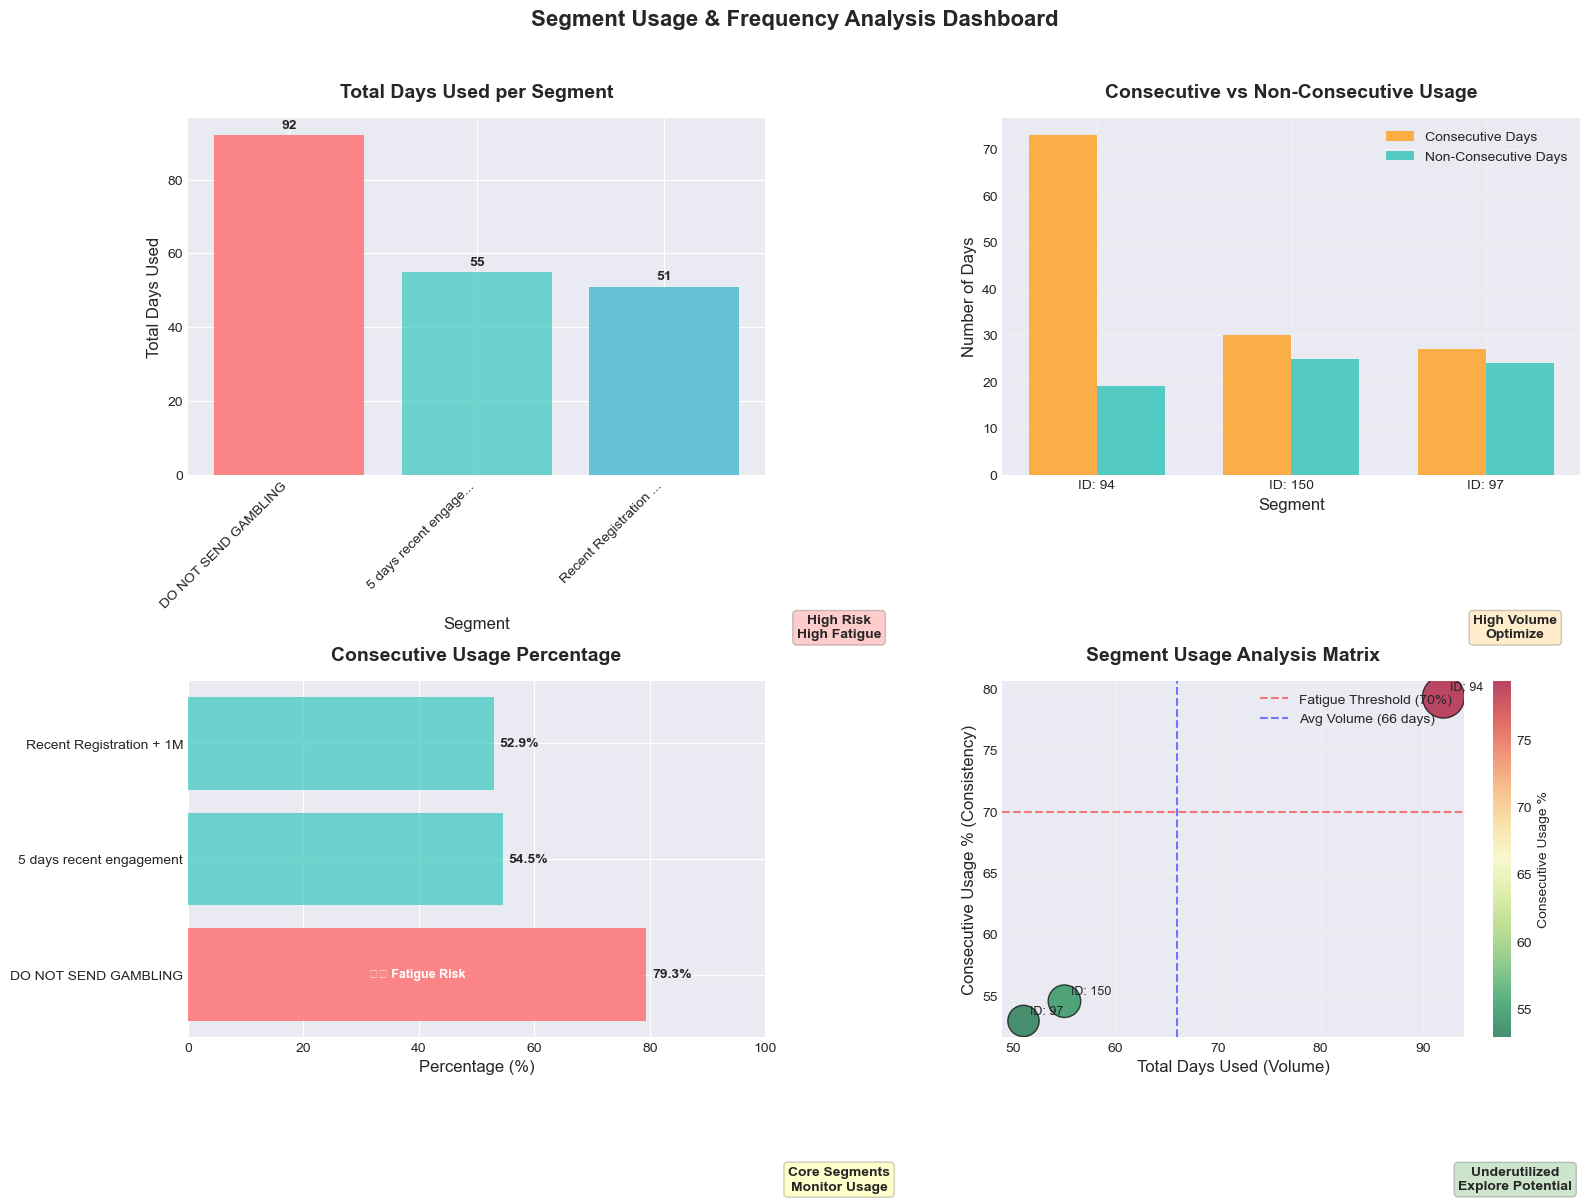


ANALYTICAL INSIGHTS

📊 KEY FINDINGS:
   • Average Segment Usage: 66.0 days
   • Average Consecutive Usage: 62.3%

🚨 FATIGUE RISK ASSESSMENT:
   • 1 segment(s) show high fatigue risk (>70% consecutive usage):
     - DO NOT SEND GAMBLING (ID: 94) - 79.3% consecutive usage

🎯 CORE SEGMENTS (Heavily Used):
   • All segments show moderate usage levels

💡 USAGE PATTERN ANALYSIS:
   • 3 out of 3 segments (100%) show habitual/automated usage patterns

📈 RECOMMENDATIONS:
   1. Monitor Segment 94 for potential fatigue - 79.3% consecutive usage
   2. Review automation rules for habitual use segments
   3. Consider rotating segments with >50% consecutive usage
   4. Explore opportunities to increase usage of lower-frequency segments

END OF ANALYSIS

DETAILED SEGMENT ANALYSIS


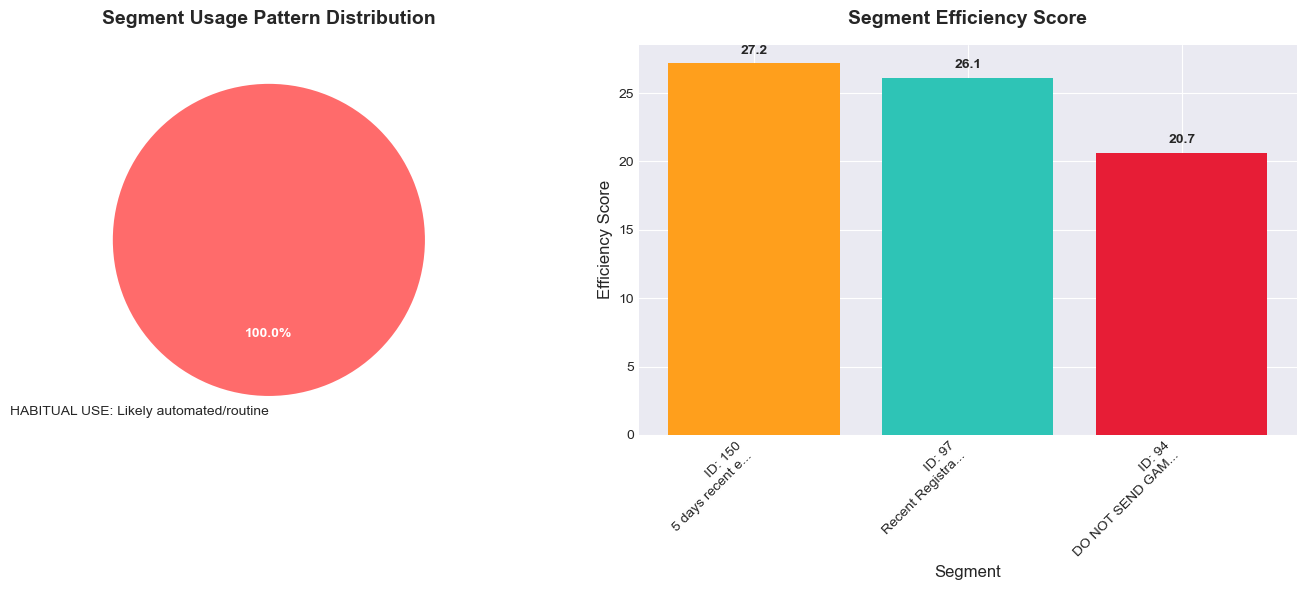


📊 SEGMENT EFFICIENCY RANKING:
----------------------------------------------------------------------
      segment_id              segment_name  total_days_used  consecutive_day_percentage  efficiency_score
Rank                                                                                                     
1            150  5 days recent engagement               55                       54.55              27.2
2             97  Recent Registration + 1M               51                       52.94              26.1
3             94      DO NOT SEND GAMBLING               92                       79.35              20.7


📈 SUMMARY STATISTICS:
----------------------------------------
       segment_id  total_days_used  consecutive_days_count  \
count        3.00             3.00                    3.00   
mean       113.67            66.00                   43.33   
std         31.50            22.61                   25.74   
min         94.00            51.00                   27

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load your data
data = {
    'segment_id': [94, 150, 97],
    'segment_name': ['DO NOT SEND GAMBLING', '5 days recent engagement', 'Recent Registration + 1M'],
    'total_days_used': [92, 55, 51],
    'consecutive_days_count': [73, 30, 27],
    'consecutive_day_percentage': [79.35, 54.55, 52.94],
    'usage_pattern': ['HABITUAL USE: Likely automated/routine', 
                      'HABITUAL USE: Likely automated/routine', 
                      'HABITUAL USE: Likely automated/routine']
}

df = pd.DataFrame(data)

def create_segment_usage_dashboard(df):
    """
    Creates a comprehensive dashboard for segment usage analysis
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing segment usage data with columns:
        - segment_id
        - segment_name
        - total_days_used
        - consecutive_days_count
        - consecutive_day_percentage
        - usage_pattern
    """
    
    print("=" * 70)
    print("SEGMENT USAGE & FREQUENCY ANALYSIS DASHBOARD")
    print("=" * 70)
    print(f"\nTotal Segments Analyzed: {len(df)}")
    print(f"Date Range: {df['total_days_used'].sum()} total campaign days")
    print("-" * 70)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Segment Usage Overview (Top-left)
    ax1 = plt.subplot(2, 2, 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = ax1.bar(range(len(df)), df['total_days_used'], color=colors, alpha=0.8)
    ax1.set_title('Total Days Used per Segment', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Segment', fontsize=12)
    ax1.set_ylabel('Total Days Used', fontsize=12)
    ax1.set_xticks(range(len(df)))
    ax1.set_xticklabels([name[:20] + '...' if len(name) > 20 else name 
                         for name in df['segment_name']], rotation=45, ha='right')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, df['total_days_used'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Consecutive Usage Analysis (Top-right)
    ax2 = plt.subplot(2, 2, 2)
    
    # Prepare data for grouped bar chart
    x = np.arange(len(df))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, df['consecutive_days_count'], width, 
                   label='Consecutive Days', color='#FF9F1C', alpha=0.8)
    bars2 = ax2.bar(x + width/2, df['total_days_used'] - df['consecutive_days_count'], width,
                   label='Non-Consecutive Days', color='#2EC4B6', alpha=0.8)
    
    ax2.set_title('Consecutive vs Non-Consecutive Usage', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Number of Days', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"ID: {id}" for id in df['segment_id']])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Consecutive Usage Percentage (Bottom-left)
    ax3 = plt.subplot(2, 2, 3)
    
    # Sort by consecutive percentage for better visualization
    df_sorted = df.sort_values('consecutive_day_percentage', ascending=False)
    
    # Create horizontal bars
    bars = ax3.barh(range(len(df_sorted)), df_sorted['consecutive_day_percentage'], 
                   color=['#FF6B6B' if pct > 70 else '#4ECDC4' if pct > 50 else '#95E1D3' 
                          for pct in df_sorted['consecutive_day_percentage']], 
                   alpha=0.8)
    
    ax3.set_title('Consecutive Usage Percentage', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Percentage (%)', fontsize=12)
    ax3.set_xlim(0, 100)
    ax3.set_yticks(range(len(df_sorted)))
    ax3.set_yticklabels(df_sorted['segment_name'].apply(lambda x: x[:25] + '...' if len(x) > 25 else x))
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, df_sorted['consecutive_day_percentage'])):
        ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{pct:.1f}%', va='center', fontweight='bold')
        
        # Add fatigue risk indicator
        if pct > 70:
            ax3.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                    '⚠️ Fatigue Risk', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=9)
    
    # 4. Segment Usage Pattern Matrix (Bottom-right)
    ax4 = plt.subplot(2, 2, 4)
    
    # Create a scatter plot for usage analysis
    scatter = ax4.scatter(df['total_days_used'], df['consecutive_day_percentage'],
                         s=df['total_days_used']*10,  # Size by total days
                         c=df['consecutive_day_percentage'],  # Color by consecutive percentage
                         cmap='RdYlGn_r', alpha=0.7, edgecolors='black', linewidth=1)
    
    # Add segment labels
    for i, row in df.iterrows():
        ax4.annotate(f"ID: {row['segment_id']}", 
                    (row['total_days_used'], row['consecutive_day_percentage']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax4.set_title('Segment Usage Analysis Matrix', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Total Days Used (Volume)', fontsize=12)
    ax4.set_ylabel('Consecutive Usage % (Consistency)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add quadrant lines and labels
    x_mean = df['total_days_used'].mean()
    y_mean = df['consecutive_day_percentage'].mean()
    
    ax4.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Fatigue Threshold (70%)')
    ax4.axvline(x=x_mean, color='blue', linestyle='--', alpha=0.5, label=f'Avg Volume ({x_mean:.0f} days)')
    
    # Add quadrant labels
    ax4.text(x_mean/2, 85, 'High Risk\nHigh Fatigue', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    ax4.text(x_mean/2, 40, 'Core Segments\nMonitor Usage', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
    ax4.text(x_mean*1.5, 85, 'High Volume\nOptimize', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.2))
    ax4.text(x_mean*1.5, 40, 'Underutilized\nExplore Potential', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
    
    ax4.legend(loc='upper right')
    
    # Add colorbar for scatter plot
    plt.colorbar(scatter, ax=ax4, label='Consecutive Usage %')
    
    plt.suptitle('Segment Usage & Frequency Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Generate insights based on the data
    print("\n" + "=" * 70)
    print("ANALYTICAL INSIGHTS")
    print("=" * 70)
    
    # Calculate key metrics for insights
    avg_days_used = df['total_days_used'].mean()
    avg_consecutive_pct = df['consecutive_day_percentage'].mean()
    max_consecutive = df.loc[df['consecutive_day_percentage'].idxmax()]
    min_usage = df.loc[df['total_days_used'].idxmin()]
    
    print(f"\n📊 KEY FINDINGS:")
    print(f"   • Average Segment Usage: {avg_days_used:.1f} days")
    print(f"   • Average Consecutive Usage: {avg_consecutive_pct:.1f}%")
    
    print(f"\n🚨 FATIGUE RISK ASSESSMENT:")
    high_fatigue = df[df['consecutive_day_percentage'] > 70]
    if not high_fatigue.empty:
        print(f"   • {len(high_fatigue)} segment(s) show high fatigue risk (>70% consecutive usage):")
        for _, row in high_fatigue.iterrows():
            print(f"     - {row['segment_name']} (ID: {row['segment_id']}) - {row['consecutive_day_percentage']:.1f}% consecutive usage")
    else:
        print(f"   • No segments currently exceed the 70% fatigue risk threshold")
    
    print(f"\n🎯 CORE SEGMENTS (Heavily Used):")
    core_threshold = avg_days_used * 1.5  # 50% above average
    core_segments = df[df['total_days_used'] > core_threshold]
    if not core_segments.empty:
        for _, row in core_segments.iterrows():
            print(f"   • {row['segment_name']}: Used {row['total_days_used']} days "
                  f"({row['consecutive_day_percentage']:.1f}% consecutively)")
    else:
        print(f"   • All segments show moderate usage levels")
    
    print(f"\n💡 USAGE PATTERN ANALYSIS:")
    habitual_count = len(df[df['usage_pattern'].str.contains('HABITUAL')])
    print(f"   • {habitual_count} out of {len(df)} segments ({habitual_count/len(df)*100:.0f}%) "
          f"show habitual/automated usage patterns")
    
    print(f"\n📈 RECOMMENDATIONS:")
    print(f"   1. Monitor Segment {max_consecutive['segment_id']} for potential fatigue - "
          f"{max_consecutive['consecutive_day_percentage']:.1f}% consecutive usage")
    print(f"   2. Review automation rules for habitual use segments")
    print(f"   3. Consider rotating segments with >50% consecutive usage")
    print(f"   4. Explore opportunities to increase usage of lower-frequency segments")
    
    print("\n" + "=" * 70)
    print("END OF ANALYSIS")
    print("=" * 70)

def create_detailed_segment_report(df):
    """
    Creates additional detailed visualizations for segment analysis
    """
    print("\n" + "=" * 70)
    print("DETAILED SEGMENT ANALYSIS")
    print("=" * 70)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Usage Pattern Distribution
    ax1 = axes[0]
    pattern_counts = df['usage_pattern'].value_counts()
    wedges, texts, autotexts = ax1.pie(pattern_counts.values, 
                                       labels=pattern_counts.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=['#FF6B6B', '#4ECDC4', '#95E1D3'])
    
    # Enhance text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax1.set_title('Segment Usage Pattern Distribution', fontsize=14, fontweight='bold', pad=15)
    
    # 2. Segment Efficiency Score
    ax2 = axes[1]
    
    # Calculate efficiency score (lower consecutive percentage is better for fatigue)
    df['fatigue_risk_score'] = df['consecutive_day_percentage'] / 100
    df['volume_score'] = df['total_days_used'] / df['total_days_used'].max()
    df['efficiency_score'] = df['volume_score'] * (1 - df['fatigue_risk_score']) * 100
    
    # Sort by efficiency
    df_efficiency = df.sort_values('efficiency_score', ascending=False)
    
    bars = ax2.bar(range(len(df_efficiency)), df_efficiency['efficiency_score'], 
                  color=['#FF9F1C', '#2EC4B6', '#E71D36'][:len(df_efficiency)])
    
    ax2.set_title('Segment Efficiency Score', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Efficiency Score', fontsize=12)
    ax2.set_xticks(range(len(df_efficiency)))
    ax2.set_xticklabels([f"ID: {id}\n{name[:15]}..." for id, name in 
                        zip(df_efficiency['segment_id'], df_efficiency['segment_name'])],
                       rotation=45, ha='right')
    
    # Add score labels
    for bar, score in zip(bars, df_efficiency['efficiency_score']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Display efficiency table
    print("\n📊 SEGMENT EFFICIENCY RANKING:")
    print("-" * 70)
    efficiency_df = df_efficiency[['segment_id', 'segment_name', 'total_days_used', 
                                  'consecutive_day_percentage', 'efficiency_score']].copy()
    efficiency_df['efficiency_score'] = efficiency_df['efficiency_score'].round(1)
    efficiency_df['Rank'] = range(1, len(efficiency_df) + 1)
    efficiency_df = efficiency_df.set_index('Rank')
    print(efficiency_df.to_string())
    
    print("\n" + "=" * 70)


create_segment_usage_dashboard(df)

# Create detailed report
create_detailed_segment_report(df)

# Print summary statistics
print("\n📈 SUMMARY STATISTICS:")
print("-" * 40)
print(df.describe().round(2))

# -- Classify segments based on usage patterns

In [27]:
SQL_NAME = "2_/2_8"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

segment_id              segment_name  total_campaigns  total_days_used  \
0          94      DO NOT SEND GAMBLING              106               92   
1         150  5 days recent engagement               63               55   
2          97  Recent Registration + 1M               60               51   

   months_active  unique_clients       avg_open_rate_pct  \
0              4              19  0.20789150943396226400   
1              4              21  0.31527301587301587300   
2              4              16  0.17287166666666666700   

           avg_unsub_rate_pct              usage_category       fatigue_risk  \
0  0.002562264150943396226400  CORE SEGMENT: Heavily used  HIGH FATIGUE RISK   
1  0.002679365079365079365100  CORE SEGMENT: Heavily used  HIGH FATIGUE RISK   
2  0.002186666666666666666700  CORE SEGMENT: Heavily used  HIGH FATIGUE RISK   

       utilization_status                    usage_intentionality  
0  APPROPRIATELY UTILIZED  STRATEGIC: Multiple clients find value  
1  APPROPRIATELY UTILIZED  STRATEGIC: Multiple clients find value  
2  APPROPRIATELY UTILIZED  STRATEGIC: Multiple clients find value

SEGMENT CLASSIFICATION & USAGE PATTERN ANALYSIS

Total Segments Analyzed: 47
Total Campaigns: 711
Unique Clients Reached: 185
Average Open Rate: 0.2%
------------------------------------------------------------------------------------------


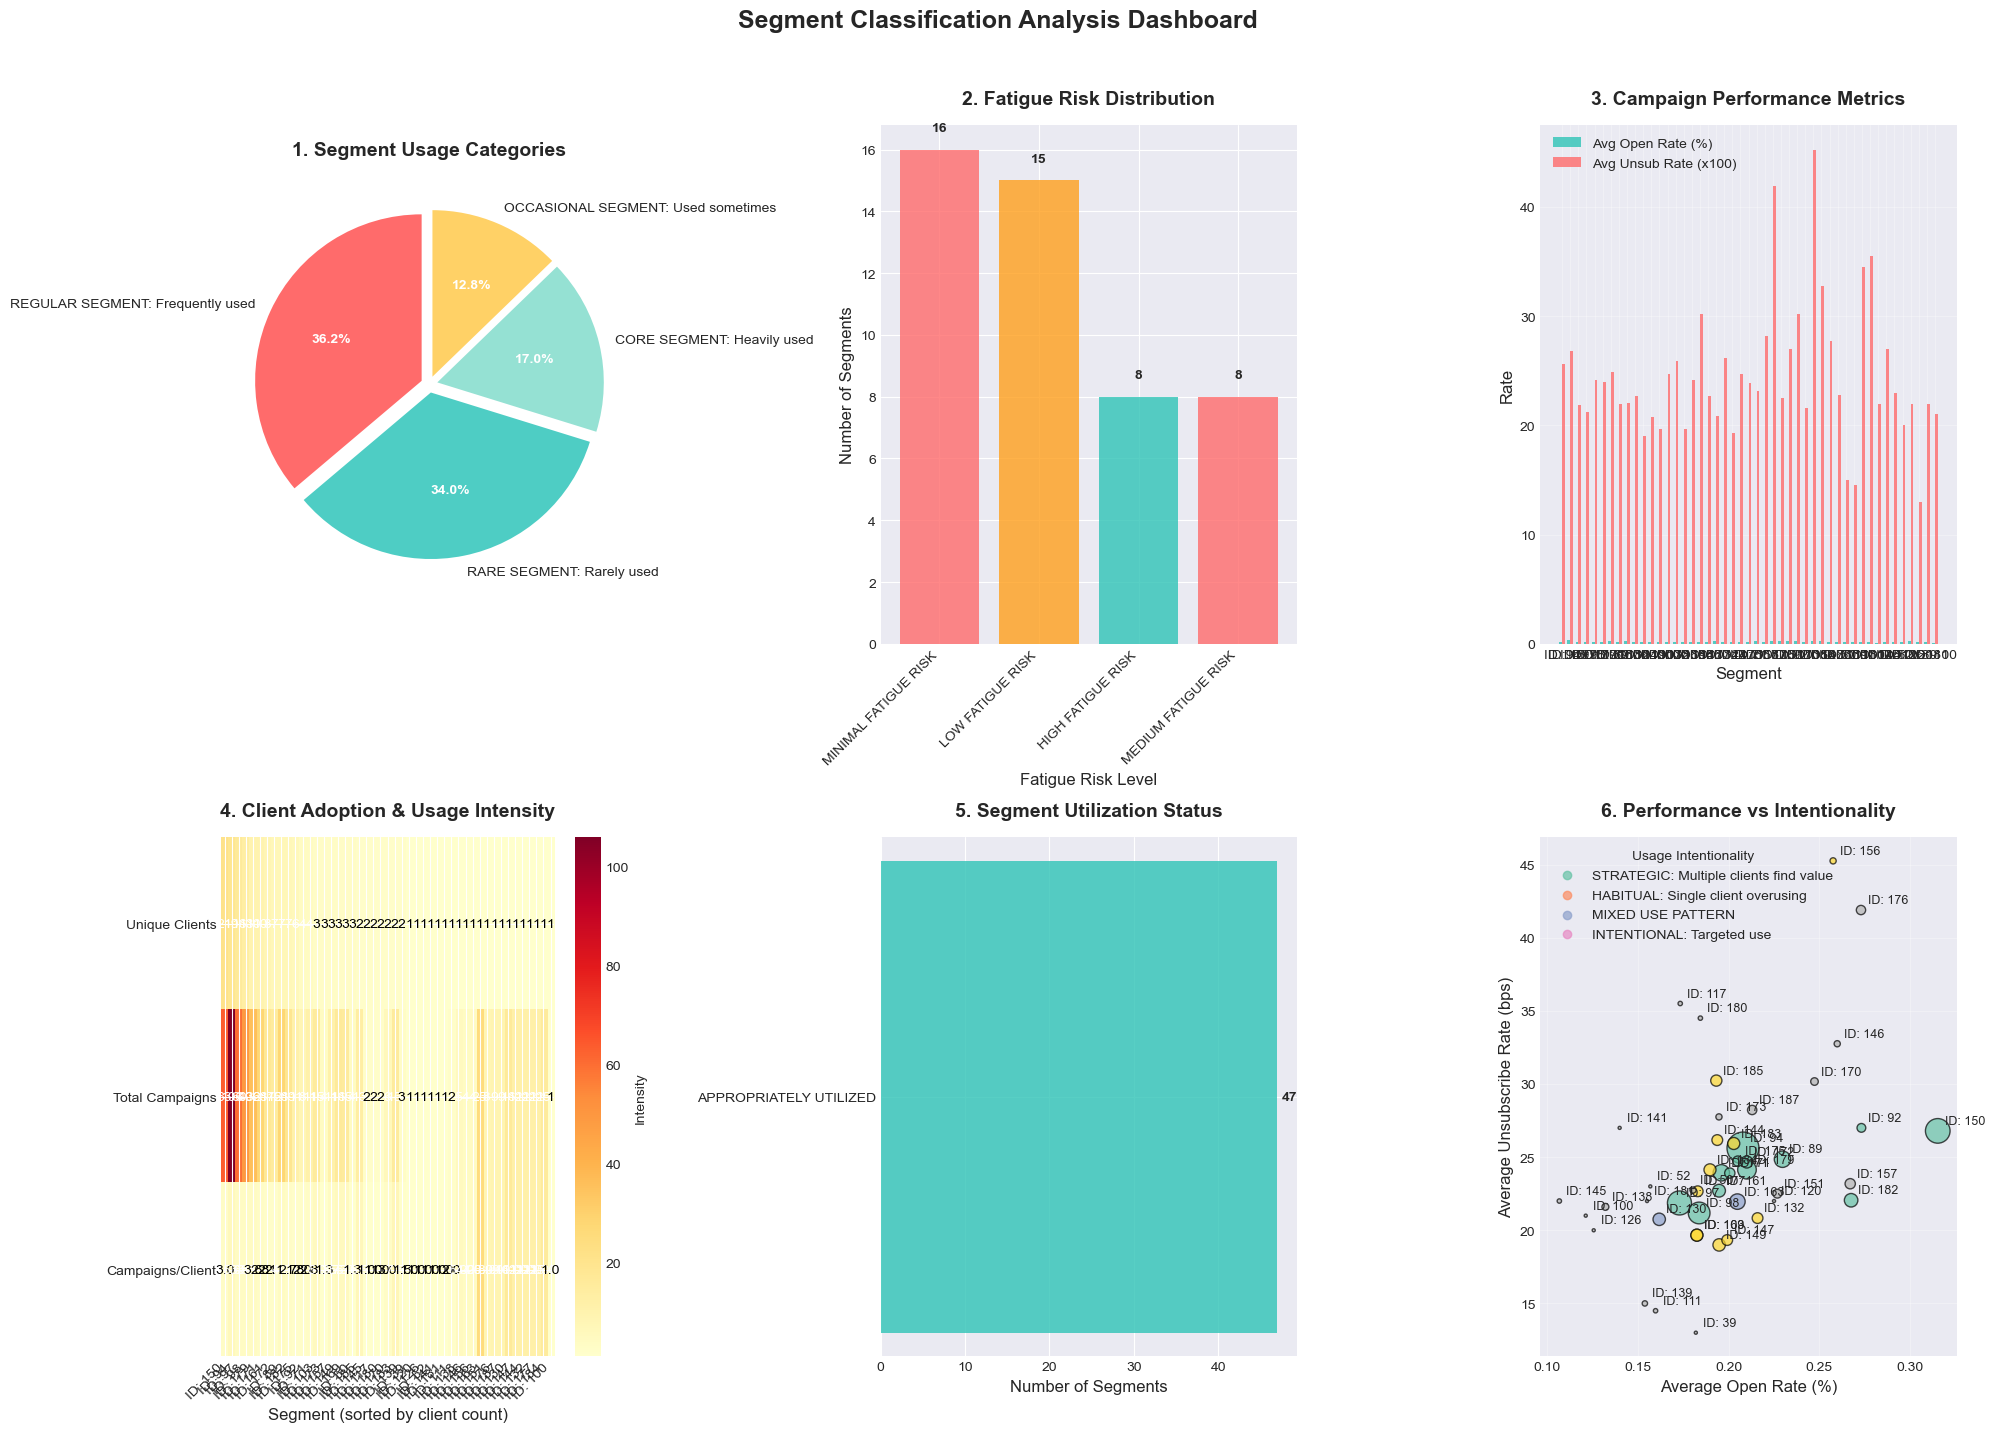


DYNAMIC INSIGHTS GENERATED FROM CLASSIFICATION DATA

📊 CLASSIFICATION OVERVIEW:
   • 8/47 segments (17%) are classified as CORE
   • 8/47 segments (17%) show HIGH FATIGUE RISK
   • 47/47 segments (100%) are APPROPRIATELY UTILIZED
   • 13/47 segments (28%) show STRATEGIC usage

🎯 PERFORMANCE ANALYSIS:
   • Average Open Rate: 0.2% | Average Unsubscribe Rate: 24.45 basis points
   • BEST PERFORMER: Segment 150 (5 days recent engagement...) - 0.3% open rate
   • WORST PERFORMER: Segment 145 (clicked squirl...) - 0.1% open rate
   • MOST EFFICIENT: Segment 39 - Open/Unsub ratio: 139.9

👥 CLIENT ADOPTION INSIGHTS:
   • Segment 150 reaches 21 unique clients (highest adoption)
   • Segment 161 runs 1.2 campaigns per day (highest frequency)
   • 24 segments have been active all 4 months (high consistency)

⚠️  RISK ASSESSMENT:
   • 5 segments combine HIGH FATIGUE with above-average unsubscribe rates:
     ⚠️  ID 94: 25.62 bps unsub rate
     ⚠️  ID 150: 26.79 bps unsub rate
     ⚠️  ID 179: 24

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_classification(df):
    """
    Comprehensive segment classification analysis based on usage patterns
    """
    
    print("=" * 90)
    print("SEGMENT CLASSIFICATION & USAGE PATTERN ANALYSIS")
    print("=" * 90)
    
    # Make a copy to avoid modifying original
    df_analysis = df.copy()
    
    # Ensure numeric columns are properly converted
    numeric_columns = ['total_campaigns', 'total_days_used', 'months_active', 
                      'unique_clients', 'avg_open_rate_pct', 'avg_unsub_rate_pct']
    
    for col in numeric_columns:
        if col in df_analysis.columns:
            df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    print(f"\nTotal Segments Analyzed: {len(df_analysis)}")
    print(f"Total Campaigns: {df_analysis['total_campaigns'].sum():,}")
    print(f"Unique Clients Reached: {df_analysis['unique_clients'].sum():,}")
    print(f"Average Open Rate: {df_analysis['avg_open_rate_pct'].mean():.1f}%")
    print("-" * 90)
    
    # ============================================
    # VISUALIZATION 1: Segment Classification Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 3, figsize=(20, 14))
    fig1.suptitle('Segment Classification Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Segment Usage by Category
    ax1 = axes1[0, 0]
    if 'usage_category' in df_analysis.columns:
        category_counts = df_analysis['usage_category'].value_counts()
        colors1 = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD166'][:len(category_counts)]
        wedges1, texts1, autotexts1 = ax1.pie(category_counts.values, 
                                               labels=category_counts.index,
                                               autopct='%1.1f%%',
                                               startangle=90,
                                               colors=colors1,
                                               explode=[0.05]*len(category_counts))
        
        for autotext in autotexts1:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    ax1.set_title('1. Segment Usage Categories', fontsize=14, fontweight='bold', pad=15)
    
    # 1.2 Fatigue Risk Distribution
    ax2 = axes1[0, 1]
    if 'fatigue_risk' in df_analysis.columns:
        fatigue_counts = df_analysis['fatigue_risk'].value_counts()
        colors2 = ['#FF6B6B', '#FF9F1C', '#2EC4B6'][:len(fatigue_counts)]
        
        bars2 = ax2.bar(range(len(fatigue_counts)), fatigue_counts.values, color=colors2, alpha=0.8)
        ax2.set_title('2. Fatigue Risk Distribution', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('Fatigue Risk Level', fontsize=12)
        ax2.set_ylabel('Number of Segments', fontsize=12)
        ax2.set_xticks(range(len(fatigue_counts)))
        ax2.set_xticklabels(fatigue_counts.index, rotation=45, ha='right')
        
        for bar, count in zip(bars2, fatigue_counts.values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 1.3 Performance Metrics
    ax3 = axes1[0, 2]
    
    x_pos = np.arange(len(df_analysis))
    width = 0.35
    
    # Scale open rates for better visualization
    open_rate_scaled = df_analysis['avg_open_rate_pct']
    
    bars3a = ax3.bar(x_pos - width/2, open_rate_scaled, width, 
                    label='Avg Open Rate (%)', color='#2EC4B6', alpha=0.8)
    bars3b = ax3.bar(x_pos + width/2, df_analysis['avg_unsub_rate_pct'] * 10000, width,
                    label='Avg Unsub Rate (x100)', color='#FF6B6B', alpha=0.8)
    
    ax3.set_title('3. Campaign Performance Metrics', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Rate', fontsize=12)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"ID: {id}" for id in df_analysis['segment_id']])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 1.4 Client Adoption Heatmap
    ax4 = axes1[1, 0]
    
    # Prepare data for heatmap
    heatmap_data = df_analysis[['segment_id', 'unique_clients', 'total_campaigns']].copy()
    heatmap_data['campaigns_per_client'] = heatmap_data['total_campaigns'] / heatmap_data['unique_clients'].replace(0, 1)
    heatmap_data = heatmap_data.sort_values('unique_clients', ascending=False)
    
    # Create a matrix for the heatmap
    matrix_data = heatmap_data[['unique_clients', 'total_campaigns', 'campaigns_per_client']].values.T
    im = ax4.imshow(matrix_data, cmap='YlOrRd', aspect='auto')
    
    ax4.set_title('4. Client Adoption & Usage Intensity', fontsize=14, fontweight='bold', pad=15)
    ax4.set_xlabel('Segment (sorted by client count)', fontsize=12)
    ax4.set_xticks(range(len(heatmap_data)))
    ax4.set_xticklabels([f"ID: {id}" for id in heatmap_data['segment_id']], rotation=45, ha='right')
    ax4.set_yticks([0, 1, 2])
    ax4.set_yticklabels(['Unique Clients', 'Total Campaigns', 'Campaigns/Client'])
    
    # Add value annotations
    for i in range(matrix_data.shape[0]):
        for j in range(matrix_data.shape[1]):
            ax4.text(j, i, f'{matrix_data[i, j]:.0f}' if i != 2 else f'{matrix_data[i, j]:.1f}',
                    ha='center', va='center', color='black' if matrix_data[i, j] < np.median(matrix_data) else 'white')
    
    plt.colorbar(im, ax=ax4, label='Intensity')
    
    # 1.5 Utilization Status
    ax5 = axes1[1, 1]
    if 'utilization_status' in df_analysis.columns:
        utilization_counts = df_analysis['utilization_status'].value_counts()
        colors5 = ['#2EC4B6', '#FF9F1C', '#FF6B6B'][:len(utilization_counts)]
        
        bars5 = ax5.barh(range(len(utilization_counts)), utilization_counts.values, 
                        color=colors5, alpha=0.8)
        ax5.set_title('5. Segment Utilization Status', fontsize=14, fontweight='bold', pad=15)
        ax5.set_xlabel('Number of Segments', fontsize=12)
        ax5.set_yticks(range(len(utilization_counts)))
        ax5.set_yticklabels(utilization_counts.index)
        
        for bar, count in zip(bars5, utilization_counts.values):
            ax5.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{count}', va='center', fontweight='bold')
    
    # 1.6 Usage Intentionality
    ax6 = axes1[1, 2]
    
    # Create a bubble chart for intentionality vs performance
    if 'usage_intentionality' in df_analysis.columns:
        # Create numeric mapping for intentionality
        intentionality_mapping = {val: i for i, val in enumerate(df_analysis['usage_intentionality'].unique())}
        intentionality_numeric = df_analysis['usage_intentionality'].map(intentionality_mapping)
        
        scatter = ax6.scatter(df_analysis['avg_open_rate_pct'], df_analysis['avg_unsub_rate_pct'] * 10000,
                             s=df_analysis['total_campaigns'] * 5,
                             c=intentionality_numeric,
                             cmap='Set2',
                             alpha=0.7,
                             edgecolors='black',
                             linewidth=1)
        
        # Add segment labels
        for idx, row in df_analysis.iterrows():
            ax6.annotate(f"ID: {row['segment_id']}", 
                        (row['avg_open_rate_pct'], row['avg_unsub_rate_pct'] * 10000),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        # Create custom legend for intentionality
        unique_intentionality = df_analysis['usage_intentionality'].unique()
        for i, intent in enumerate(unique_intentionality):
            ax6.scatter([], [], color=plt.cm.Set2(i), label=intent, alpha=0.7)
        ax6.legend(title='Usage Intentionality')
    else:
        scatter = ax6.scatter(df_analysis['avg_open_rate_pct'], df_analysis['avg_unsub_rate_pct'] * 10000,
                             s=df_analysis['total_campaigns'] * 5,
                             alpha=0.7,
                             edgecolors='black',
                             linewidth=1)
        
        for idx, row in df_analysis.iterrows():
            ax6.annotate(f"ID: {row['segment_id']}", 
                        (row['avg_open_rate_pct'], row['avg_unsub_rate_pct'] * 10000),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax6.set_title('6. Performance vs Intentionality', fontsize=14, fontweight='bold', pad=15)
    ax6.set_xlabel('Average Open Rate (%)', fontsize=12)
    ax6.set_ylabel('Average Unsubscribe Rate (bps)', fontsize=12)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # GENERATE DYNAMIC INSIGHTS
    # ============================================
    
    print("\n" + "=" * 90)
    print("DYNAMIC INSIGHTS GENERATED FROM CLASSIFICATION DATA")
    print("=" * 90)
    
    # Calculate key metrics
    total_segments = len(df_analysis)
    total_campaigns = df_analysis['total_campaigns'].sum()
    total_clients = df_analysis['unique_clients'].sum()
    avg_open_rate = df_analysis['avg_open_rate_pct'].mean()
    avg_unsub_rate = df_analysis['avg_unsub_rate_pct'].mean()
    
    # Initialize variables with safe defaults
    best_open_rate_segment = None
    worst_open_rate_segment = None
    most_efficient_segment = None
    highest_client_segment = None
    
    # Find best and worst open rates (only if we have numeric data)
    if not df_analysis['avg_open_rate_pct'].isna().all():
        best_open_rate_idx = df_analysis['avg_open_rate_pct'].idxmax()
        worst_open_rate_idx = df_analysis['avg_open_rate_pct'].idxmin()
        best_open_rate_segment = df_analysis.loc[best_open_rate_idx]
        worst_open_rate_segment = df_analysis.loc[worst_open_rate_idx]
    
    # Find highest client adoption
    if not df_analysis['unique_clients'].isna().all():
        highest_client_idx = df_analysis['unique_clients'].idxmax()
        highest_client_segment = df_analysis.loc[highest_client_idx]
    
    # Calculate efficiency scores
    # Avoid division by zero by adding a small constant
    df_analysis['efficiency_score'] = df_analysis['avg_open_rate_pct'] / (df_analysis['avg_unsub_rate_pct'] + 1e-10)
    
    if not df_analysis['efficiency_score'].isna().all():
        most_efficient_idx = df_analysis['efficiency_score'].idxmax()
        most_efficient_segment = df_analysis.loc[most_efficient_idx]
    
    # Classification counts (with safe checks)
    core_segments_count = 0
    high_fatigue_count = 0
    appropriate_util_count = 0
    strategic_intent_count = 0
    
    if 'usage_category' in df_analysis.columns:
        core_segments_count = df_analysis['usage_category'].str.contains('CORE', case=False, na=False).sum()
    
    if 'fatigue_risk' in df_analysis.columns:
        high_fatigue_count = df_analysis['fatigue_risk'].str.contains('HIGH', case=False, na=False).sum()
    
    if 'utilization_status' in df_analysis.columns:
        appropriate_util_count = df_analysis['utilization_status'].str.contains('APPROPRIATELY', case=False, na=False).sum()
    
    if 'usage_intentionality' in df_analysis.columns:
        strategic_intent_count = df_analysis['usage_intentionality'].str.contains('STRATEGIC', case=False, na=False).sum()
    
    print(f"\n📊 CLASSIFICATION OVERVIEW:")
    print(f"   • {core_segments_count}/{total_segments} segments ({core_segments_count/total_segments*100:.0f}%) are classified as CORE")
    print(f"   • {high_fatigue_count}/{total_segments} segments ({high_fatigue_count/total_segments*100:.0f}%) show HIGH FATIGUE RISK")
    print(f"   • {appropriate_util_count}/{total_segments} segments ({appropriate_util_count/total_segments*100:.0f}%) are APPROPRIATELY UTILIZED")
    print(f"   • {strategic_intent_count}/{total_segments} segments ({strategic_intent_count/total_segments*100:.0f}%) show STRATEGIC usage")
    
    print(f"\n🎯 PERFORMANCE ANALYSIS:")
    print(f"   • Average Open Rate: {avg_open_rate:.1f}% | Average Unsubscribe Rate: {avg_unsub_rate*10000:.2f} basis points")
    
    if best_open_rate_segment is not None:
        print(f"   • BEST PERFORMER: Segment {best_open_rate_segment['segment_id']} ({best_open_rate_segment['segment_name'][:30]}...) - {best_open_rate_segment['avg_open_rate_pct']:.1f}% open rate")
    
    if worst_open_rate_segment is not None:
        print(f"   • WORST PERFORMER: Segment {worst_open_rate_segment['segment_id']} ({worst_open_rate_segment['segment_name'][:30]}...) - {worst_open_rate_segment['avg_open_rate_pct']:.1f}% open rate")
    
    if most_efficient_segment is not None:
        print(f"   • MOST EFFICIENT: Segment {most_efficient_segment['segment_id']} - Open/Unsub ratio: {most_efficient_segment['efficiency_score']:.1f}")
    
    print(f"\n👥 CLIENT ADOPTION INSIGHTS:")
    if highest_client_segment is not None:
        print(f"   • Segment {highest_client_segment['segment_id']} reaches {highest_client_segment['unique_clients']} unique clients (highest adoption)")
    
    # Calculate campaign frequency
    df_analysis['campaigns_per_day'] = df_analysis['total_campaigns'] / df_analysis['total_days_used'].replace(0, 1)
    if not df_analysis['campaigns_per_day'].isna().all():
        highest_freq_idx = df_analysis['campaigns_per_day'].idxmax()
        highest_freq_segment = df_analysis.loc[highest_freq_idx]
        print(f"   • Segment {highest_freq_segment['segment_id']} runs {highest_freq_segment['campaigns_per_day']:.1f} campaigns per day (highest frequency)")
    
    # Analyze segment longevity
    fully_active_segments = df_analysis[df_analysis['months_active'] == df_analysis['months_active'].max()]
    if len(fully_active_segments) > 0:
        print(f"   • {len(fully_active_segments)} segments have been active all {df_analysis['months_active'].max()} months (high consistency)")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    
    # Identify segments with high fatigue AND high unsubscribe rates
    if 'fatigue_risk' in df_analysis.columns:
        high_fatigue_mask = df_analysis['fatigue_risk'].str.contains('HIGH', case=False, na=False)
        median_unsub = df_analysis['avg_unsub_rate_pct'].median()
        high_risk_segments = df_analysis[high_fatigue_mask & (df_analysis['avg_unsub_rate_pct'] > median_unsub)]
        
        if not high_risk_segments.empty:
            print(f"   • {len(high_risk_segments)} segments combine HIGH FATIGUE with above-average unsubscribe rates:")
            for _, row in high_risk_segments.iterrows():
                print(f"     ⚠️  ID {row['segment_id']}: {row['avg_unsub_rate_pct']*10000:.2f} bps unsub rate")
    
    # Identify underperforming core segments
    if 'usage_category' in df_analysis.columns:
        core_mask = df_analysis['usage_category'].str.contains('CORE', case=False, na=False)
        median_open = df_analysis['avg_open_rate_pct'].median()
        underperforming_core = df_analysis[core_mask & (df_analysis['avg_open_rate_pct'] < median_open)]
        
        if not underperforming_core.empty:
            print(f"   • {len(underperforming_core)} CORE segments show below-median open rates - consider optimization")
    
    print(f"\n📈 STRATEGIC RECOMMENDATIONS:")
    
    # Recommendation 1: Address high fatigue
    if high_fatigue_count > 0:
        high_fatigue_ids = df_analysis[df_analysis['fatigue_risk'].str.contains('HIGH', case=False, na=False)]['segment_id'].tolist()
        print(f"   1. IMPLEMENT ROTATION STRATEGY for high-fatigue segments: {', '.join(map(str, high_fatigue_ids))}")
    
    # Recommendation 2: Leverage strategic segments
    if strategic_intent_count > 0:
        strategic_ids = df_analysis[df_analysis['usage_intentionality'].str.contains('STRATEGIC', case=False, na=False)]['segment_id'].tolist()
        print(f"   2. LEVERAGE STRATEGIC SEGMENTS {', '.join(map(str, strategic_ids))} as benchmarks for other campaigns")
    
    # Recommendation 3: Optimize underperformers
    if not df_analysis['avg_open_rate_pct'].isna().all():
        low_open_threshold = df_analysis['avg_open_rate_pct'].quantile(0.25)
        low_open_segments = df_analysis[df_analysis['avg_open_rate_pct'] < low_open_threshold]
        if not low_open_segments.empty:
            low_open_ids = low_open_segments['segment_id'].tolist()
            print(f"   3. REVIEW & OPTIMIZE low-performing segments: {', '.join(map(str, low_open_ids))}")
    
    # Recommendation 4: Expand successful segments
    if not df_analysis['unique_clients'].isna().all():
        high_client_threshold = df_analysis['unique_clients'].quantile(0.75)
        high_client_segments = df_analysis[df_analysis['unique_clients'] > high_client_threshold]
        if not high_client_segments.empty:
            high_client_ids = high_client_segments['segment_id'].tolist()
            print(f"   4. EXPAND successful client-facing segments: {', '.join(map(str, high_client_ids))}")
    
    # Recommendation 5: Monitor unsub rates
    if not df_analysis['avg_unsub_rate_pct'].isna().all():
        high_unsub_threshold = df_analysis['avg_unsub_rate_pct'].quantile(0.75)
        high_unsub_segments = df_analysis[df_analysis['avg_unsub_rate_pct'] > high_unsub_threshold]
        if not high_unsub_segments.empty:
            high_unsub_ids = high_unsub_segments['segment_id'].tolist()
            print(f"   5. CLOSELY MONITOR unsubscribe rates for segments: {', '.join(map(str, high_unsub_ids))}")
    
    print(f"\n   6. SEGMENT HEALTH CHECKLIST:")
    
    # Create a health score for each segment
    # Normalize each component to 0-1 scale
    df_analysis['health_open'] = (df_analysis['avg_open_rate_pct'] - df_analysis['avg_open_rate_pct'].min()) / (df_analysis['avg_open_rate_pct'].max() - df_analysis['avg_open_rate_pct'].min() + 1e-10)
    df_analysis['health_unsub'] = 1 - (df_analysis['avg_unsub_rate_pct'] - df_analysis['avg_unsub_rate_pct'].min()) / (df_analysis['avg_unsub_rate_pct'].max() - df_analysis['avg_unsub_rate_pct'].min() + 1e-10)
    df_analysis['health_clients'] = (df_analysis['unique_clients'] - df_analysis['unique_clients'].min()) / (df_analysis['unique_clients'].max() - df_analysis['unique_clients'].min() + 1e-10)
    
    df_analysis['health_score'] = (
        df_analysis['health_open'] * 40 +
        df_analysis['health_unsub'] * 30 +
        df_analysis['health_clients'] * 20 +
        (df_analysis['total_campaigns'] / df_analysis['total_campaigns'].max()) * 10
    ).fillna(0)
    
    # Classify segment health
    if not df_analysis['health_score'].isna().all():
        health_categories = {
            'Excellent': (0.8, 1.0),
            'Good': (0.6, 0.8),
            'Needs Attention': (0.4, 0.6),
            'Critical': (0, 0.4)
        }
        
        for category, (low, high) in health_categories.items():
            count = ((df_analysis['health_score'] >= low) & (df_analysis['health_score'] < high)).sum()
            if high == 1.0:  # For Excellent category, include upper bound
                count = (df_analysis['health_score'] >= low).sum()
            print(f"      • {count} segments in '{category}' health category")
    else:
        print("      • Health scoring not available due to missing data")
    
    print(f"\n" + "=" * 90)
    print("DETAILED SEGMENT CLASSIFICATION TABLE")
    print("=" * 90)
    
    # Create detailed summary table
    summary_cols = ['segment_id', 'segment_name', 'unique_clients',
                   'total_campaigns', 'avg_open_rate_pct', 'avg_unsub_rate_pct']
    
    # Add classification columns if they exist
    for col in ['usage_category', 'fatigue_risk', 'utilization_status', 'usage_intentionality']:
        if col in df_analysis.columns:
            summary_cols.append(col)
    
    summary_df = df_analysis[summary_cols].copy()
    summary_df['avg_open_rate_pct'] = summary_df['avg_open_rate_pct'].apply(lambda x: f"{x:.1f}%")
    summary_df['avg_unsub_rate_pct'] = summary_df['avg_unsub_rate_pct'].apply(lambda x: f"{x*10000:.2f} bps")
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)
    pd.set_option('display.colheader_justify', 'center')
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 90)
    print("ANALYSIS COMPLETE - KEY FINDINGS")
    print("=" * 90)
    
    # Generate final key findings
    print(f"\n🔑 KEY FINDINGS FROM YOUR DATA:")
    
    # 1. Category distribution
    if 'usage_category' in df_analysis.columns:
        print(f"   1. SEGMENT DISTRIBUTION:")
        category_counts = df_analysis['usage_category'].value_counts()
        for category, count in category_counts.items():
            percentage = (count / total_segments) * 100
            print(f"      • {category}: {count} segments ({percentage:.0f}%)")
    
    # 2. Risk profile
    if 'fatigue_risk' in df_analysis.columns:
        print(f"\n   2. RISK PROFILE:")
        fatigue_dist = df_analysis['fatigue_risk'].value_counts()
        for risk_level, count in fatigue_dist.items():
            percentage = (count / total_segments) * 100
            print(f"      • {risk_level}: {count} segments ({percentage:.0f}%)")
    
    # 3. Performance summary
    print(f"\n   3. PERFORMANCE SUMMARY:")
    print(f"      • Open Rate Range: {df_analysis['avg_open_rate_pct'].min():.1f}% to {df_analysis['avg_open_rate_pct'].max():.1f}%")
    print(f"      • Unsub Rate Range: {df_analysis['avg_unsub_rate_pct'].min()*10000:.2f} to {df_analysis['avg_unsub_rate_pct'].max()*10000:.2f} bps")
    print(f"      • Average Campaigns per Segment: {df_analysis['total_campaigns'].mean():.0f}")
    print(f"      • Average Unique Clients per Segment: {df_analysis['unique_clients'].mean():.0f}")
    
    # 4. Top performers
    print(f"\n   4. TOP PERFORMERS IDENTIFIED:")
    if best_open_rate_segment is not None:
        print(f"      • Highest Open Rate: Segment {best_open_rate_segment['segment_id']} ({best_open_rate_segment['avg_open_rate_pct']:.1f}%)")
    if highest_client_segment is not None:
        print(f"      • Widest Reach: Segment {highest_client_segment['segment_id']} ({highest_client_segment['unique_clients']} clients)")
    if most_efficient_segment is not None:
        print(f"      • Most Efficient: Segment {most_efficient_segment['segment_id']} (Open/Unsub ratio: {most_efficient_segment['efficiency_score']:.1f})")
    
    print(f"\n" + "=" * 90)



# Example of how to run with your data:
analyze_segment_classification(df)